In [1]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
!nvidia-smi

Mon Feb 19 19:28:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   33C    P8              21W / 215W |    600MiB /  8192MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold2/'

cuda


In [7]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [8]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [9]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [10]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13
description: FirConv with fftconv
fe:
  n_block: 2
  n_channel:
  - 128
  - 32
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: stack
  pooling: mean
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer)

In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                              | 0.00205761316872428/10 [00:00<56:29, 338.97s/it]

Train Epoch: 1 [0/11685 (0%)]	Loss: 0.689028
Mem before-during-after: 633344 4366444544 33845760


  1%|▌                                                             | 0.08436213991769549/10 [00:19<38:42, 234.21s/it]

Train Epoch: 1 [1280/11685 (11%)]	Loss: 0.452198
Mem before-during-after: 33698304 4376186880 33812992


  2%|█                                                             | 0.16666666666666657/10 [00:39<38:10, 232.95s/it]

Train Epoch: 1 [2560/11685 (22%)]	Loss: 0.716283
Mem before-during-after: 33698304 4376186880 33812992


  2%|█▌                                                             | 0.2489711934156374/10 [00:58<38:17, 235.57s/it]

Train Epoch: 1 [3840/11685 (33%)]	Loss: 0.080684
Mem before-during-after: 33698304 4376186880 33812992


  3%|██                                                             | 0.3312757201646082/10 [01:17<38:23, 238.23s/it]

Train Epoch: 1 [5120/11685 (44%)]	Loss: 0.525410
Mem before-during-after: 33698304 4376186880 33812992


  4%|██▌                                                           | 0.41358024691357903/10 [01:36<38:26, 240.56s/it]

Train Epoch: 1 [6400/11685 (55%)]	Loss: 0.524632
Mem before-during-after: 33698304 4376186880 33812992


  5%|███                                                           | 0.49588477366254985/10 [01:55<36:52, 232.77s/it]

Train Epoch: 1 [7680/11685 (66%)]	Loss: 0.952072
Mem before-during-after: 33698304 4376186880 33812992


  6%|███▋                                                           | 0.5781893004115227/10 [02:15<38:18, 243.93s/it]

Train Epoch: 1 [8960/11685 (77%)]	Loss: 0.647843
Mem before-during-after: 33698304 4376186880 33812992


  7%|████▏                                                          | 0.6604938271604958/10 [02:34<37:32, 241.14s/it]

Train Epoch: 1 [10240/11685 (88%)]	Loss: 1.007098
Mem before-during-after: 33698304 4376186880 33812992


  7%|████▋                                                          | 0.7427983539094688/10 [02:53<36:53, 239.10s/it]

Train Epoch: 1 [11520/11685 (99%)]	Loss: 0.330031
Mem before-during-after: 33698304 4376186880 33812992


 10%|██████▎                                                        | 1.0000000000000095/10 [03:21<17:07, 114.22s/it]


Test Epoch: 1	Accuracy: 2931/3872 (75%)



 10%|██████▎                                                        | 1.0020576131687338/10 [03:21<22:15, 148.46s/it]

Train Epoch: 2 [0/11685 (0%)]	Loss: 0.155789
Mem before-during-after: 33658368 4377006592 33665536


 11%|██████▊                                                        | 1.0843621399177024/10 [03:41<35:25, 238.38s/it]

Train Epoch: 2 [1280/11685 (11%)]	Loss: 0.402543
Mem before-during-after: 33665536 4377096704 33665536


 12%|███████▍                                                        | 1.166666666666671/10 [04:00<34:58, 237.55s/it]

Train Epoch: 2 [2560/11685 (22%)]	Loss: 0.625641
Mem before-during-after: 33665536 4377096704 33665536


 12%|███████▊                                                       | 1.2489711934156396/10 [04:19<34:57, 239.73s/it]

Train Epoch: 2 [3840/11685 (33%)]	Loss: 0.129803
Mem before-during-after: 33665536 4377096704 33665536


 13%|████████▍                                                      | 1.3312757201646082/10 [04:38<35:22, 244.89s/it]

Train Epoch: 2 [5120/11685 (44%)]	Loss: 0.529565
Mem before-during-after: 33665536 4377096704 33665536


 14%|████████▉                                                      | 1.4135802469135768/10 [04:57<33:50, 236.47s/it]

Train Epoch: 2 [6400/11685 (55%)]	Loss: 0.523674
Mem before-during-after: 33665536 4377096704 33665536


 15%|█████████▍                                                     | 1.4958847736625454/10 [05:16<33:19, 235.16s/it]

Train Epoch: 2 [7680/11685 (66%)]	Loss: 0.761570
Mem before-during-after: 33665536 4377096704 33665536


 16%|██████████                                                      | 1.578189300411514/10 [05:35<32:43, 233.14s/it]

Train Epoch: 2 [8960/11685 (77%)]	Loss: 0.867508
Mem before-during-after: 33665536 4377096704 33665536


 17%|██████████▍                                                    | 1.6604938271604825/10 [05:54<32:40, 235.09s/it]

Train Epoch: 2 [10240/11685 (88%)]	Loss: 1.432669
Mem before-during-after: 33665536 4377096704 33665536


 17%|██████████▉                                                    | 1.7427983539094511/10 [06:13<33:30, 243.47s/it]

Train Epoch: 2 [11520/11685 (99%)]	Loss: 0.341434
Mem before-during-after: 33665536 4377096704 33665536


 20%|████████████▊                                                   | 1.999999999999978/10 [06:40<15:29, 116.24s/it]


Test Epoch: 2	Accuracy: 3040/3872 (78%)



 20%|████████████▌                                                  | 2.0020576131687022/10 [06:41<20:03, 150.49s/it]

Train Epoch: 3 [0/11685 (0%)]	Loss: 0.116790
Mem before-during-after: 33658368 4377022976 33665536


 21%|█████████████▏                                                 | 2.0843621399176797/10 [07:00<30:59, 234.92s/it]

Train Epoch: 3 [1280/11685 (11%)]	Loss: 0.149637
Mem before-during-after: 33681920 4376540160 33681920


 22%|█████████████▊                                                  | 2.166666666666657/10 [07:18<30:33, 234.01s/it]

Train Epoch: 3 [2560/11685 (22%)]	Loss: 0.479353
Mem before-during-after: 33681920 4376540160 33681920


 22%|██████████████▏                                                | 2.2489711934156347/10 [07:38<30:47, 238.36s/it]

Train Epoch: 3 [3840/11685 (33%)]	Loss: 0.057700
Mem before-during-after: 33681920 4376540160 33681920


 23%|██████████████▉                                                 | 2.331275720164612/10 [07:56<29:30, 230.82s/it]

Train Epoch: 3 [5120/11685 (44%)]	Loss: 0.584771
Mem before-during-after: 33681920 4376540160 33681920


 24%|███████████████▏                                               | 2.4135802469135896/10 [08:15<29:44, 235.18s/it]

Train Epoch: 3 [6400/11685 (55%)]	Loss: 0.553933
Mem before-during-after: 33681920 4376540160 33681920


 25%|███████████████▉                                                | 2.495884773662567/10 [08:34<29:35, 236.65s/it]

Train Epoch: 3 [7680/11685 (66%)]	Loss: 1.336816
Mem before-during-after: 33681920 4376540160 33681920


 26%|████████████████▏                                              | 2.5781893004115446/10 [08:53<28:55, 233.84s/it]

Train Epoch: 3 [8960/11685 (77%)]	Loss: 0.516211
Mem before-during-after: 33681920 4376540160 33681920


 27%|█████████████████                                               | 2.660493827160522/10 [09:12<28:39, 234.34s/it]

Train Epoch: 3 [10240/11685 (88%)]	Loss: 1.175461
Mem before-during-after: 33681920 4376540160 33681920


 27%|█████████████████▎                                             | 2.7427983539094996/10 [09:31<28:37, 236.69s/it]

Train Epoch: 3 [11520/11685 (99%)]	Loss: 0.347705
Mem before-during-after: 33681920 4376540160 33681920


 30%|███████████████████▏                                            | 3.000000000000054/10 [09:58<12:22, 106.06s/it]


Test Epoch: 3	Accuracy: 3011/3872 (77%)



 30%|██████████████████▉                                            | 3.0020576131687786/10 [09:59<16:29, 141.40s/it]

Train Epoch: 4 [0/11685 (0%)]	Loss: 0.065549
Mem before-during-after: 33658368 4377088512 34599936


 31%|███████████████████▋                                            | 3.084362139917756/10 [10:18<26:53, 233.38s/it]

Train Epoch: 4 [1280/11685 (11%)]	Loss: 0.488926
Mem before-during-after: 33681920 4376908800 33681920


 32%|███████████████████▉                                           | 3.1666666666667336/10 [10:36<26:45, 234.95s/it]

Train Epoch: 4 [2560/11685 (22%)]	Loss: 0.491513
Mem before-during-after: 33681920 4376908800 33681920


 32%|████████████████████▊                                           | 3.248971193415711/10 [10:56<26:50, 238.55s/it]

Train Epoch: 4 [3840/11685 (33%)]	Loss: 0.058682
Mem before-during-after: 33681920 4376908800 33681920


 33%|████████████████████▉                                          | 3.3312757201646885/10 [11:14<25:59, 233.87s/it]

Train Epoch: 4 [5120/11685 (44%)]	Loss: 0.602836
Mem before-during-after: 33681920 4376908800 33681920


 34%|█████████████████████▊                                          | 3.413580246913666/10 [11:33<25:49, 235.26s/it]

Train Epoch: 4 [6400/11685 (55%)]	Loss: 0.591080
Mem before-during-after: 33681920 4376908800 33681920


 35%|██████████████████████                                         | 3.4958847736626435/10 [11:52<25:16, 233.10s/it]

Train Epoch: 4 [7680/11685 (66%)]	Loss: 1.035605
Mem before-during-after: 33681920 4376908800 33681920


 36%|██████████████████████▉                                         | 3.578189300411621/10 [12:11<25:12, 235.45s/it]

Train Epoch: 4 [8960/11685 (77%)]	Loss: 0.542742
Mem before-during-after: 33681920 4376908800 33681920


 37%|███████████████████████                                        | 3.6604938271605985/10 [12:30<24:43, 233.97s/it]

Train Epoch: 4 [10240/11685 (88%)]	Loss: 1.073852
Mem before-during-after: 33681920 4376908800 33681920


 37%|███████████████████████▉                                        | 3.742798353909576/10 [12:49<24:27, 234.53s/it]

Train Epoch: 4 [11520/11685 (99%)]	Loss: 0.364157
Mem before-during-after: 33681920 4376908800 33681920


 40%|█████████████████████████▌                                      | 4.000000000000131/10 [13:17<10:12, 102.06s/it]


Test Epoch: 4	Accuracy: 2966/3872 (76%)



 40%|█████████████████████████▌                                      | 4.002057613168855/10 [13:17<13:53, 138.98s/it]

Train Epoch: 5 [0/11685 (0%)]	Loss: 0.129887
Mem before-during-after: 33658368 4377088512 34599936


 41%|█████████████████████████▋                                     | 4.0843621399178325/10 [13:36<23:21, 236.90s/it]

Train Epoch: 5 [1280/11685 (11%)]	Loss: 0.118385
Mem before-during-after: 33681920 4376908800 33681920


 42%|███████████████████████████                                      | 4.16666666666681/10 [13:55<22:50, 234.99s/it]

Train Epoch: 5 [2560/11685 (22%)]	Loss: 0.387990
Mem before-during-after: 33681920 4376908800 33681920


 42%|███████████████████████████▏                                    | 4.248971193415787/10 [14:14<22:39, 236.38s/it]

Train Epoch: 5 [3840/11685 (33%)]	Loss: 0.059857
Mem before-during-after: 33681920 4376908800 33681920


 43%|███████████████████████████▋                                    | 4.331275720164765/10 [14:33<22:15, 235.53s/it]

Train Epoch: 5 [5120/11685 (44%)]	Loss: 0.604862
Mem before-during-after: 33681920 4376908800 33681920


 44%|████████████████████████████▏                                   | 4.413580246913742/10 [14:52<21:51, 234.81s/it]

Train Epoch: 5 [6400/11685 (55%)]	Loss: 0.587465
Mem before-during-after: 33681920 4376908800 33681920


 45%|█████████████████████████████▏                                   | 4.49588477366272/10 [15:11<21:42, 236.68s/it]

Train Epoch: 5 [7680/11685 (66%)]	Loss: 1.162580
Mem before-during-after: 33681920 4376908800 33681920


 46%|█████████████████████████████▎                                  | 4.578189300411697/10 [15:30<21:20, 236.23s/it]

Train Epoch: 5 [8960/11685 (77%)]	Loss: 0.464090
Mem before-during-after: 33681920 4376908800 33681920


 47%|█████████████████████████████▊                                  | 4.660493827160675/10 [15:49<20:59, 235.86s/it]

Train Epoch: 5 [10240/11685 (88%)]	Loss: 1.179575
Mem before-during-after: 33681920 4376908800 33681920


 47%|██████████████████████████████▎                                 | 4.742798353909652/10 [16:09<20:36, 235.12s/it]

Train Epoch: 5 [11520/11685 (99%)]	Loss: 0.363355
Mem before-during-after: 33681920 4376908800 33681920


 50%|████████████████████████████████                                | 5.000000000000207/10 [16:36<08:27, 101.42s/it]


Test Epoch: 5	Accuracy: 3112/3872 (80%)



 50%|████████████████████████████████                                | 5.002057613168931/10 [16:37<11:35, 139.10s/it]

Train Epoch: 6 [0/11685 (0%)]	Loss: 0.071908
Mem before-during-after: 33658368 4377088512 34599936


 51%|████████████████████████████████▌                               | 5.084362139917909/10 [16:55<19:22, 236.39s/it]

Train Epoch: 6 [1280/11685 (11%)]	Loss: 0.590674
Mem before-during-after: 33681920 4376908800 33681920


 52%|█████████████████████████████████                               | 5.166666666666886/10 [17:14<18:53, 234.46s/it]

Train Epoch: 6 [2560/11685 (22%)]	Loss: 0.319917
Mem before-during-after: 33681920 4376908800 33681920


 52%|█████████████████████████████████▌                              | 5.248971193415864/10 [17:33<18:35, 234.77s/it]

Train Epoch: 6 [3840/11685 (33%)]	Loss: 0.045800
Mem before-during-after: 33681920 4376908800 33681920


 53%|██████████████████████████████████                              | 5.331275720164841/10 [17:52<18:16, 234.80s/it]

Train Epoch: 6 [5120/11685 (44%)]	Loss: 0.638646
Mem before-during-after: 33681920 4376908800 33681920


 54%|██████████████████████████████████▋                             | 5.413580246913819/10 [18:11<17:52, 233.79s/it]

Train Epoch: 6 [6400/11685 (55%)]	Loss: 0.579741
Mem before-during-after: 33681920 4376908800 33681920


 55%|███████████████████████████████████▏                            | 5.495884773662796/10 [18:30<17:33, 233.79s/it]

Train Epoch: 6 [7680/11685 (66%)]	Loss: 0.941021
Mem before-during-after: 33681920 4376908800 33681920


 56%|███████████████████████████████████▋                            | 5.578189300411774/10 [18:49<17:47, 241.37s/it]

Train Epoch: 6 [8960/11685 (77%)]	Loss: 0.714247
Mem before-during-after: 33681920 4376908800 33681920


 57%|████████████████████████████████████▏                           | 5.660493827160751/10 [19:08<16:54, 233.89s/it]

Train Epoch: 6 [10240/11685 (88%)]	Loss: 0.920916
Mem before-during-after: 33681920 4376908800 33681920


 57%|████████████████████████████████████▊                           | 5.742798353909729/10 [19:28<16:45, 236.28s/it]

Train Epoch: 6 [11520/11685 (99%)]	Loss: 0.366546
Mem before-during-after: 33681920 4376908800 33681920


 60%|██████████████████████████████████████▍                         | 6.000000000000283/10 [19:55<06:48, 102.21s/it]


Test Epoch: 6	Accuracy: 3044/3872 (78%)



 60%|██████████████████████████████████████▍                         | 6.002057613169008/10 [19:55<09:18, 139.70s/it]

Train Epoch: 7 [0/11685 (0%)]	Loss: 0.067056
Mem before-during-after: 33658368 4377088512 34599936


 61%|██████████████████████████████████████▉                         | 6.084362139917985/10 [20:14<15:12, 232.95s/it]

Train Epoch: 7 [1280/11685 (11%)]	Loss: 0.540726
Mem before-during-after: 33681920 4376908800 33681920


 62%|███████████████████████████████████████▍                        | 6.166666666666963/10 [20:33<15:07, 236.65s/it]

Train Epoch: 7 [2560/11685 (22%)]	Loss: 0.289135
Mem before-during-after: 33681920 4376908800 33681920


 62%|████████████████████████████████████████▌                        | 6.24897119341594/10 [20:52<14:31, 232.31s/it]

Train Epoch: 7 [3840/11685 (33%)]	Loss: 0.051640
Mem before-during-after: 33681920 4376908800 33681920


 63%|████████████████████████████████████████▌                       | 6.331275720164918/10 [21:11<14:14, 232.89s/it]

Train Epoch: 7 [5120/11685 (44%)]	Loss: 0.653140
Mem before-during-after: 33681920 4376908800 33681920


 64%|█████████████████████████████████████████                       | 6.413580246913895/10 [21:29<13:58, 233.93s/it]

Train Epoch: 7 [6400/11685 (55%)]	Loss: 0.573788
Mem before-during-after: 33681920 4376908800 33681920


 65%|█████████████████████████████████████████▌                      | 6.495884773662873/10 [21:48<13:38, 233.63s/it]

Train Epoch: 7 [7680/11685 (66%)]	Loss: 1.112275
Mem before-during-after: 33681920 4376908800 33681920


 66%|██████████████████████████████████████████▊                      | 6.57818930041185/10 [22:07<13:20, 234.01s/it]

Train Epoch: 7 [8960/11685 (77%)]	Loss: 0.512638
Mem before-during-after: 33681920 4376908800 33681920


 67%|██████████████████████████████████████████▋                     | 6.660493827160828/10 [22:26<13:09, 236.51s/it]

Train Epoch: 7 [10240/11685 (88%)]	Loss: 1.323099
Mem before-during-after: 33681920 4376908800 33681920


 67%|███████████████████████████████████████████▏                    | 6.742798353909805/10 [22:45<12:44, 234.69s/it]

Train Epoch: 7 [11520/11685 (99%)]	Loss: 0.382617
Mem before-during-after: 33681920 4376908800 33681920


 70%|██████████████████████████████████████████████▏                   | 7.00000000000036/10 [23:12<04:58, 99.59s/it]


Test Epoch: 7	Accuracy: 3113/3872 (80%)



 70%|████████████████████████████████████████████▊                   | 7.002057613169084/10 [23:12<06:55, 138.52s/it]

Train Epoch: 8 [0/11685 (0%)]	Loss: 0.078925
Mem before-during-after: 33658368 4377088512 34599936


 71%|█████████████████████████████████████████████▎                  | 7.084362139918062/10 [23:31<11:16, 231.98s/it]

Train Epoch: 8 [1280/11685 (11%)]	Loss: 0.443540
Mem before-during-after: 33681920 4376908800 33681920


 72%|█████████████████████████████████████████████▊                  | 7.166666666667039/10 [23:50<11:02, 233.86s/it]

Train Epoch: 8 [2560/11685 (22%)]	Loss: 0.247411
Mem before-during-after: 33681920 4376908800 33681920


 72%|██████████████████████████████████████████████▍                 | 7.248971193416017/10 [24:09<10:38, 232.14s/it]

Train Epoch: 8 [3840/11685 (33%)]	Loss: 0.053224
Mem before-during-after: 33681920 4376908800 33681920


 73%|██████████████████████████████████████████████▉                 | 7.331275720164994/10 [24:27<10:21, 232.99s/it]

Train Epoch: 8 [5120/11685 (44%)]	Loss: 0.721430
Mem before-during-after: 33681920 4376908800 33681920


 74%|██████████████████████████████████████████████▋                | 7.4135802469139715/10 [24:46<10:04, 233.68s/it]

Train Epoch: 8 [6400/11685 (55%)]	Loss: 0.529697
Mem before-during-after: 33681920 4376908800 33681920


 75%|███████████████████████████████████████████████▉                | 7.495884773662949/10 [25:05<09:39, 231.22s/it]

Train Epoch: 8 [7680/11685 (66%)]	Loss: 1.010171
Mem before-during-after: 33681920 4376908800 33681920


 76%|███████████████████████████████████████████████▋               | 7.5781893004119265/10 [25:23<09:20, 231.37s/it]

Train Epoch: 8 [8960/11685 (77%)]	Loss: 0.435067
Mem before-during-after: 33681920 4376908800 33681920


 77%|█████████████████████████████████████████████████               | 7.660493827160904/10 [25:42<09:01, 231.38s/it]

Train Epoch: 8 [10240/11685 (88%)]	Loss: 1.575749
Mem before-during-after: 33681920 4376908800 33681920


 77%|████████████████████████████████████████████████▊              | 7.7427983539098815/10 [26:01<08:44, 232.21s/it]

Train Epoch: 8 [11520/11685 (99%)]	Loss: 0.387013
Mem before-during-after: 33681920 4376908800 33681920


 80%|███████████████████████████████████████████████████▏            | 8.000000000000435/10 [26:28<03:25, 102.77s/it]


Test Epoch: 8	Accuracy: 3137/3872 (81%)



 80%|███████████████████████████████████████████████████▏            | 8.002057613169159/10 [26:29<04:40, 140.41s/it]

Train Epoch: 9 [0/11685 (0%)]	Loss: 0.079712
Mem before-during-after: 33658368 4377088512 34599936


 81%|█████████████████████████████████████████████████████▎            | 8.0843621399181/10 [26:47<07:29, 234.89s/it]

Train Epoch: 9 [1280/11685 (11%)]	Loss: 0.354891
Mem before-during-after: 33681920 4376908800 33681920


 82%|████████████████████████████████████████████████████▎           | 8.166666666667043/10 [27:06<07:09, 234.29s/it]

Train Epoch: 9 [2560/11685 (22%)]	Loss: 0.235195
Mem before-during-after: 33681920 4376908800 33681920


 82%|████████████████████████████████████████████████████▊           | 8.248971193415985/10 [27:25<06:48, 233.12s/it]

Train Epoch: 9 [3840/11685 (33%)]	Loss: 0.087500
Mem before-during-after: 33681920 4376908800 33681920


 83%|█████████████████████████████████████████████████████▎          | 8.331275720164927/10 [27:44<06:28, 233.11s/it]

Train Epoch: 9 [5120/11685 (44%)]	Loss: 0.755671
Mem before-during-after: 33681920 4376908800 33681920


 84%|█████████████████████████████████████████████████████▊          | 8.413580246913869/10 [28:02<06:10, 233.23s/it]

Train Epoch: 9 [6400/11685 (55%)]	Loss: 0.495281
Mem before-during-after: 33681920 4376908800 33681920


 85%|███████████████████████████████████████████████████████▏         | 8.49588477366281/10 [28:21<05:52, 234.14s/it]

Train Epoch: 9 [7680/11685 (66%)]	Loss: 1.127084
Mem before-during-after: 33681920 4376908800 33681920


 86%|██████████████████████████████████████████████████████▉         | 8.578189300411752/10 [28:40<05:31, 233.48s/it]

Train Epoch: 9 [8960/11685 (77%)]	Loss: 0.291049
Mem before-during-after: 33681920 4376908800 33681920


 87%|███████████████████████████████████████████████████████▍        | 8.660493827160694/10 [28:59<05:41, 254.70s/it]

Train Epoch: 9 [10240/11685 (88%)]	Loss: 1.789513
Mem before-during-after: 33681920 4376908800 33681920


 87%|███████████████████████████████████████████████████████▉        | 8.742798353909636/10 [29:18<04:54, 234.05s/it]

Train Epoch: 9 [11520/11685 (99%)]	Loss: 0.416963
Mem before-during-after: 33681920 4376908800 33681920


 90%|██████████████████████████████████████████████████████████▌      | 9.00000000000008/10 [29:45<01:42, 102.28s/it]


Test Epoch: 9	Accuracy: 3153/3872 (81%)



 90%|█████████████████████████████████████████████████████████▌      | 9.002057613168803/10 [29:46<02:19, 140.09s/it]

Train Epoch: 10 [0/11685 (0%)]	Loss: 0.064767
Mem before-during-after: 33658368 4377088512 34599936


 91%|██████████████████████████████████████████████████████████▏     | 9.084362139917745/10 [30:04<03:33, 233.67s/it]

Train Epoch: 10 [1280/11685 (11%)]	Loss: 0.241368
Mem before-during-after: 33681920 4376908800 33681920


 92%|██████████████████████████████████████████████████████████▋     | 9.166666666666687/10 [30:23<03:16, 236.18s/it]

Train Epoch: 10 [2560/11685 (22%)]	Loss: 0.293074
Mem before-during-after: 33681920 4376908800 33681920


 92%|████████████████████████████████████████████████████████████     | 9.24897119341563/10 [30:42<02:57, 236.35s/it]

Train Epoch: 10 [3840/11685 (33%)]	Loss: 0.135821
Mem before-during-after: 33681920 4376908800 33681920


 93%|███████████████████████████████████████████████████████████▋    | 9.331275720164571/10 [31:01<02:37, 235.50s/it]

Train Epoch: 10 [5120/11685 (44%)]	Loss: 0.891720
Mem before-during-after: 33681920 4376908800 33681920


 94%|████████████████████████████████████████████████████████████▏   | 9.413580246913513/10 [31:20<02:18, 236.36s/it]

Train Epoch: 10 [6400/11685 (55%)]	Loss: 0.434450
Mem before-during-after: 33681920 4376908800 33681920


 95%|████████████████████████████████████████████████████████████▊   | 9.495884773662455/10 [31:40<01:58, 234.98s/it]

Train Epoch: 10 [7680/11685 (66%)]	Loss: 0.802363
Mem before-during-after: 33681920 4376908800 33681920


 96%|█████████████████████████████████████████████████████████████▎  | 9.578189300411397/10 [31:59<01:39, 234.93s/it]

Train Epoch: 10 [8960/11685 (77%)]	Loss: 0.265936
Mem before-during-after: 33681920 4376908800 33681920


 97%|█████████████████████████████████████████████████████████████▊  | 9.660493827160339/10 [32:17<01:20, 236.49s/it]

Train Epoch: 10 [10240/11685 (88%)]	Loss: 1.882837
Mem before-during-after: 33681920 4376908800 33681920


 97%|██████████████████████████████████████████████████████████████▎ | 9.742798353909281/10 [32:36<01:00, 234.66s/it]

Train Epoch: 10 [11520/11685 (99%)]	Loss: 0.458389
Mem before-during-after: 33681920 4376908800 33681920


100%|███████████████████████████████████████████████████████████████▉| 9.999999999999725/10 [33:04<00:00, 198.46s/it]


Test Epoch: 10	Accuracy: 3203/3872 (82%)



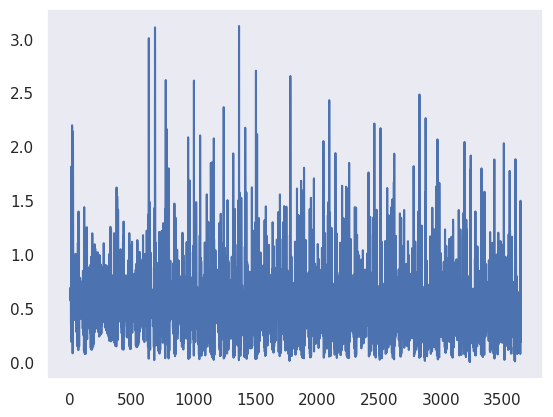

In [14]:
plt.plot(train_losses)

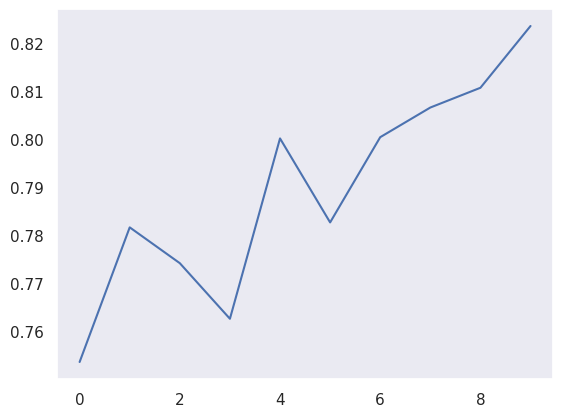

In [15]:
plt.plot(test_accuracy)

In [16]:
model_path = '../physio16k_fold2_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3202/3872 (0.8270)
{'acc_detail': tensor([0.3781, 0.9707], device='cuda:0'),
 'acc_unweighted': tensor(0.6744, device='cuda:0'),
 'acc_weighted': tensor(0.8270, device='cuda:0'),
 'f1s': tensor(0.7046, device='cuda:0'),
 'f1s_detail': tensor([0.5145, 0.8947], device='cuda:0'),
 'precision_detail': tensor([0.8050, 0.8298], device='cuda:0'),
 'recall_detail': tensor([0.3781, 0.9707], device='cuda:0'),
 'rocauc': tensor([0.8350, 0.8350], device='cuda:0'),
 'uar': tensor(0.6744, device='cuda:0'),
 'wap': tensor(0.8238, device='cuda:0')}


tensor([[ 355,  584],
        [  86, 2847]], device='cuda:0')

In [19]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [20]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-1.5854e-16],
        [ 2.8368e-16],
        [ 1.9657e-15],
        [ 3.6834e-17],
        [-1.2409e-16],
        [ 4.9070e-18],
        [ 2.7161e-17],
        [ 8.3160e-16],
        [ 4.8102e-15],
        [ 1.0004e-16],
        [ 1.5453e-16],
        [-1.9227e-18],
        [-8.3442e-16],
        [-2.2009e-14],
        [-1.9990e-18],
        [ 3.0070e-17],
        [ 4.7509e-18],
        [ 1.4955e-18],
        [ 2.2542e-17],
        [-1.5517e-16],
        [-4.7137e-16],
        [-2.5969e-15],
        [-6.5675e-17],
        [ 3.4645e-19],
        [ 1.1091e-17],
        [-1.8229e-17],
        [ 1.0395e-16],
        [ 1.9924e-17],
        [-1.8996e-14],
        [-7.0418e-14],
        [-2.8060e-18],
        [ 0.0000e+00],
        [-6.3082e-17],
        [ 2.7718e-17],
        [-2.7704e-15],
        [ 4.6647e-14],
        [ 7.7191e-17],
        [ 9.7269e-16],
        [ 3.4988e-16],
        [-7.2678e-17],
        [ 5.0819e-17],
        [-9.5599e-18],
        [ 5

[None, None, None]

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

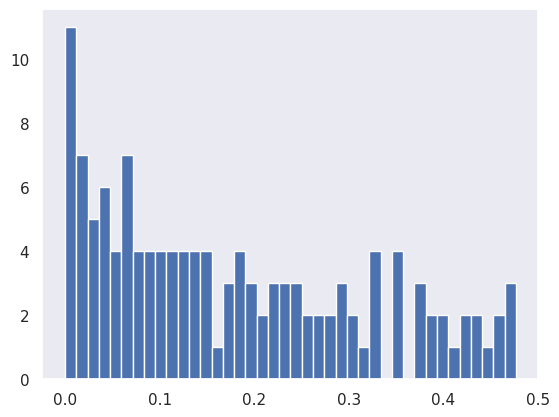

In [21]:
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   2.,   2.,
          3., 116.,   0.,   1.,   0.,   0.,   1.]),
 array([-2.87112483e-13, -2.78768490e-13, -2.70424498e-13, -2.62080532e-13,
        -2.53736539e-13, -2.45392546e-13, -2.37048554e-13, -2.28704561e-13,
        -2.20360581e-13, -2.12016602e-13, -2.03672609e-13, -1.95328630e-13,
        -1.86984637e-13, -1.78640658e-13, -1.70296665e-13, -1.61952672e-13,
        -1.53608693e-13, -1.45264700e-13, -1.36920721e-13, -1.28576728e-13,
        -1.20232735e-13, -1.11888756e-13, -1.03544770e-13, -9.52007841e-14,
        -8.68567913e-14, -7.85128053e-14, -7.01688192e-14, -6.18248332e-14,
        -5.34808471e-14, -4.51368577e-14, -3.67928717e-14, -2.84488856e-14,
        -2.01048979e-14, -1.17609102e-14, -3.41692350e-15,  4.92706360e-15,
         1.32710505e-14,  2.16150374e-14, 

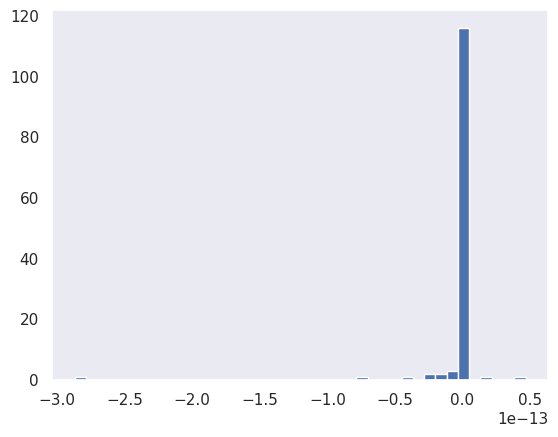

In [22]:
lowbands = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands.flatten(), bins=40)

/tmp/ipykernel_2908535/1402059949.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_2908535/1402059949.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([1., 0., 0., 0., 0., 2., 1., 0., 2., 2., 0., 1., 3., 5., 4., 1., 3.,
        3., 4., 3., 2., 3., 8., 1., 4., 5., 1., 2., 3., 2., 1., 3., 1., 1.,
        0., 0., 0., 1., 0., 1.]),
 array([-44.38695526, -44.04468536, -43.70241547, -43.36014557,
        -43.01787567, -42.67560577, -42.33333588, -41.99106598,
        -41.64879608, -41.30652618, -40.96425629, -40.6219902 ,
        -40.27972031, -39.93745041, -39.59518051, -39.25291061,
        -38.91064072, -38.56837082, -38.22610092, -37.88383102,
        -37.54156113, -37.19929123, -36.85702133, -36.51475143,
        -36.17248154, -35.83021164, -35.48794174, -35.14567184,
        -34.80340195, -34.46113205, -34.11886597, -33.77659607,
        -33.43432617, -33.09205627, -32.74978638, -32.40751648,
        -32.06524658, -31.72297668, -31.38070679, -31.03843689,
        -30.69616699]),
 <BarContainer object of 40 artists>)

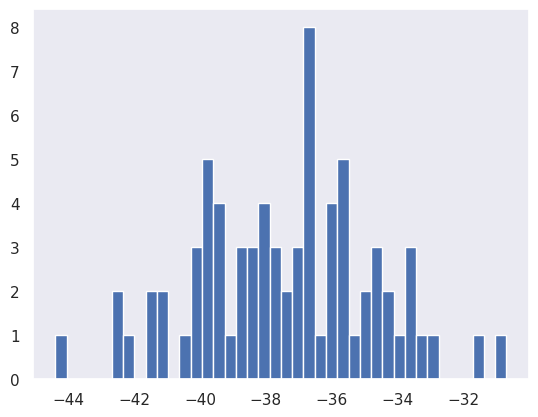

In [93]:
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([ 1.,  3.,  5., 13., 13., 14., 12.,  9.,  2.,  2.]),
 array([-44.38695526, -43.01787567, -41.64879608, -40.27972031,
        -38.91064072, -37.54156113, -36.17248154, -34.80340195,
        -33.43432617, -32.06524658, -30.69616699]),
 <BarContainer object of 10 artists>)

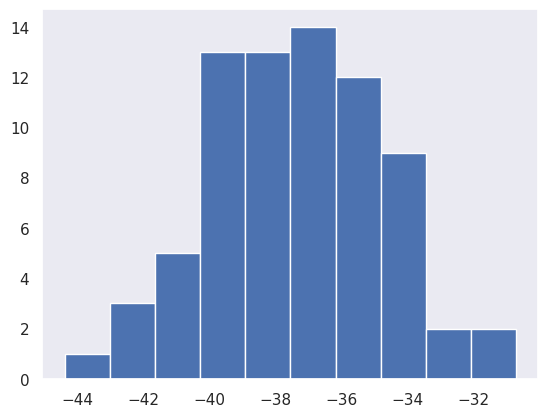

In [96]:
plt.hist(grad_log, bins=10)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

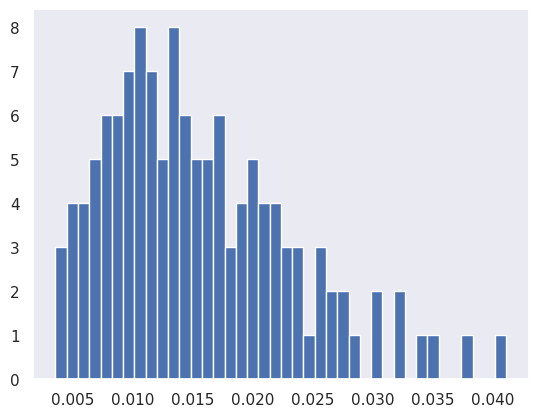

In [23]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
        117.,   5.,   1.,   0.,   0.,   0.,   1.]),
 array([-3.94346353e-14, -3.82666514e-14, -3.70986641e-14, -3.59306802e-14,
        -3.47626929e-14, -3.35947090e-14, -3.24267218e-14, -3.12587379e-14,
        -3.00907540e-14, -2.89227667e-14, -2.77547811e-14, -2.65867972e-14,
        -2.54188116e-14, -2.42508260e-14, -2.30828404e-14, -2.19148548e-14,
        -2.07468693e-14, -1.95788837e-14, -1.84108981e-14, -1.72429142e-14,
        -1.60749286e-14, -1.49069430e-14, -1.37389574e-14, -1.25709718e-14,
        -1.14029871e-14, -1.02350015e-14, -9.06701590e-15, -7.89903031e-15,
        -6.73104515e-15, -5.56305998e-15, -4.39507439e-15, -3.22708923e-15,
        -2.05910385e-15, -8.91118577e-16,  2.76866827e-16,  1.44485218e-15,
         2.61283745e-15,  3.78082304e-15, 

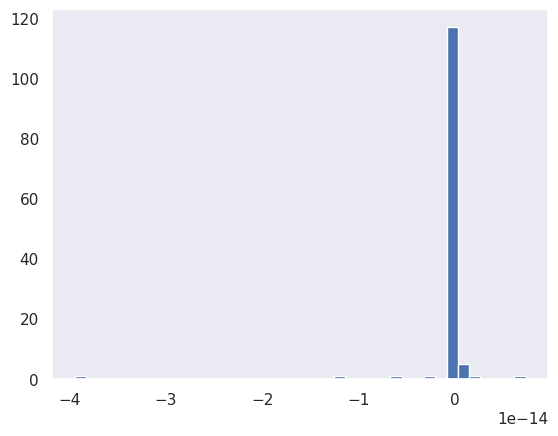

In [24]:
bandwidths = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

/tmp/ipykernel_2908535/1421197636.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths.flatten()), bins=40)


(array([1., 0., 0., 1., 0., 0., 3., 2., 0., 4., 2., 0., 1., 1., 0., 1., 2.,
        7., 3., 4., 6., 5., 3., 5., 7., 4., 3., 2., 1., 2., 0., 3., 1., 0.,
        1., 0., 0., 1., 0., 1.]),
 array([-46.89989471, -46.54122162, -46.18254852, -45.82387543,
        -45.46520233, -45.10653305, -44.74785995, -44.38918686,
        -44.03051376, -43.67184067, -43.31316757, -42.95449448,
        -42.5958252 , -42.2371521 , -41.878479  , -41.51980591,
        -41.16113281, -40.80245972, -40.44378662, -40.08511353,
        -39.72644043, -39.36777115, -39.00909805, -38.65042496,
        -38.29175186, -37.93307877, -37.57440567, -37.21573257,
        -36.85706329, -36.4983902 , -36.1397171 , -35.78104401,
        -35.42237091, -35.06369781, -34.70502472, -34.34635162,
        -33.98767853, -33.62900925, -33.27033615, -32.91166306,
        -32.55298996]),
 <BarContainer object of 40 artists>)

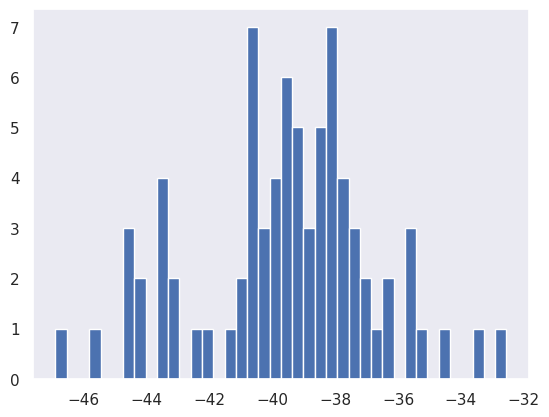

In [44]:
plt.hist(np.log(bandwidths.flatten()), bins=40)

(array([ 1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         2.,  2.,  4.,  5.,  8., 43., 20., 20., 19., 12., 14., 13., 26.,
        15., 11., 18.,  2.,  0.,  0.,  0.,  2.,  2.,  1.,  1.,  3.,  5.,
         2.]),
 array([-2.3013463 , -2.17715669, -2.05296707, -1.92877734, -1.80458772,
        -1.68039811, -1.55620837, -1.43201876, -1.30782914, -1.18363953,
        -1.05944991, -0.93526018, -0.81107056, -0.68688095, -0.56269127,
        -0.43850163, -0.31431198, -0.19012234, -0.06593269,  0.05825695,
         0.1824466 ,  0.30663624,  0.43082589,  0.55501556,  0.67920518,
         0.80339479,  0.92758447,  1.05177414,  1.17596376,  1.30015337,
         1.42434311,  1.54853272,  1.67272234,  1.79691195,  1.92110157,
         2.04529119,  2.1694808 ,  2.29367065,  2.41786027,  2.54204988,
         2.6662395 ]),
 <BarContainer object of 40 artists>)

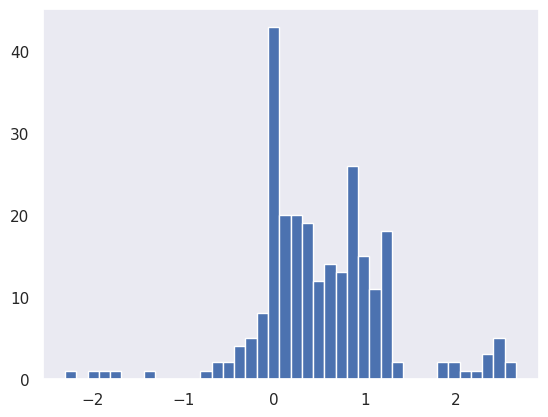

In [25]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([  2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   3.,  14.,  18., 133.,  28.,  33.,  12.,   0.,   0.,
          2.,   2.,   3.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.01675367, -0.01574684, -0.01474002, -0.0137332 , -0.01272638,
        -0.01171956, -0.01071274, -0.00970592, -0.0086991 , -0.00769228,
        -0.00668546, -0.00567864, -0.00467182, -0.003665  , -0.00265818,
        -0.00165135, -0.00064453,  0.00036229,  0.00136911,  0.00237593,
         0.00338275,  0.00438957,  0.00539639,  0.00640321,  0.00741003,
         0.00841685,  0.00942367,  0.01043049,  0.01143731,  0.01244414,
         0.01345096,  0.01445778,  0.0154646 ,  0.01647142,  0.01747824,
         0.01848506,  0.01949188,  0.0204987 ,  0.02150552,  0.02251234,
         0.02351916]),
 <BarContainer object of 40 artists>)

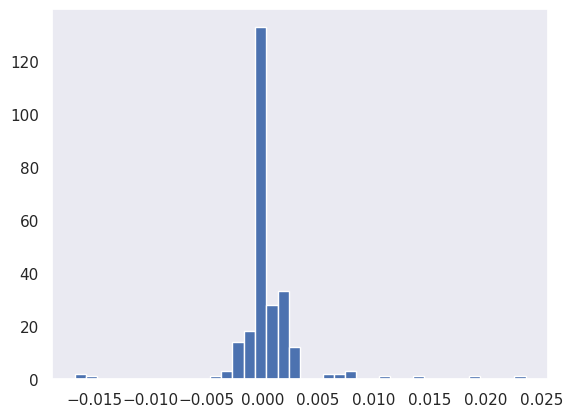

In [26]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

/tmp/ipykernel_2908535/569063560.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(window_params.flatten()), bins=40)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
         0.,  2.,  2.,  3.,  1.,  0.,  2.,  3.,  3.,  2., 10.,  1.,  2.,
         3.,  5.,  8.,  6., 19., 15., 15.,  1.,  0.,  3.,  4.,  1.,  1.,
         2.]),
 array([-15.52318001, -15.22884941, -14.93451786, -14.64018726,
        -14.34585571, -14.05152512, -13.75719357, -13.46286297,
        -13.16853237, -12.87420082, -12.57987022, -12.28553867,
        -11.99120808, -11.69687653, -11.40254593, -11.10821533,
        -10.81388378, -10.51955318, -10.22522163,  -9.93089104,
         -9.63655949,  -9.34222889,  -9.04789829,  -8.75356674,
         -8.45923615,  -8.16490459,  -7.870574  ,  -7.57624292,
         -7.28191185,  -6.98758078,  -6.6932497 ,  -6.39891863,
         -6.10458755,  -5.81025696,  -5.51592588,  -5.22159481,
         -4.92726374,  -4.63293266,  -4.33860159,  -4.04427052,
         -3.74993968]),
 <BarContainer object of 40 artists>)

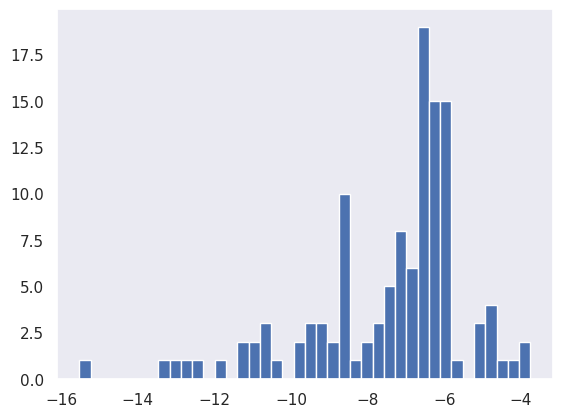

In [46]:
plt.hist(np.log(window_params.flatten()), bins=40)

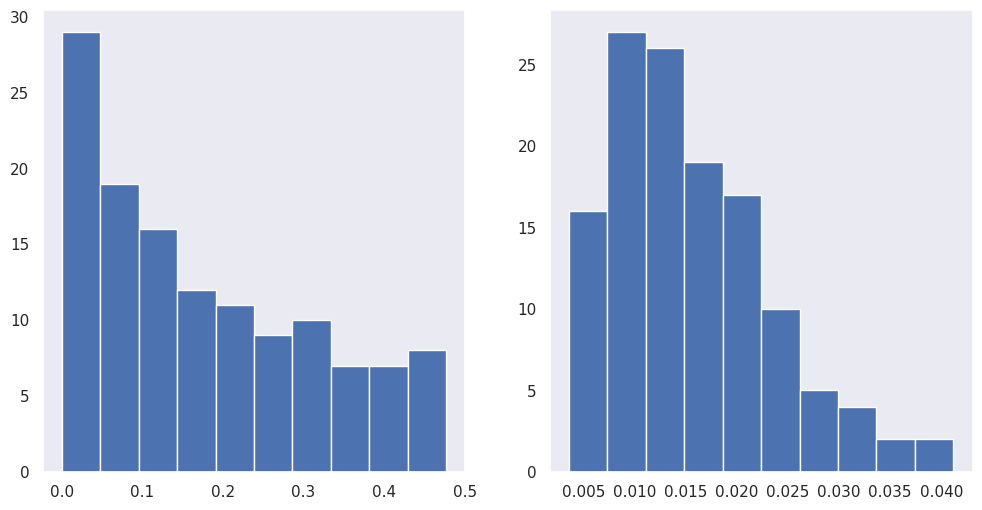

In [27]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


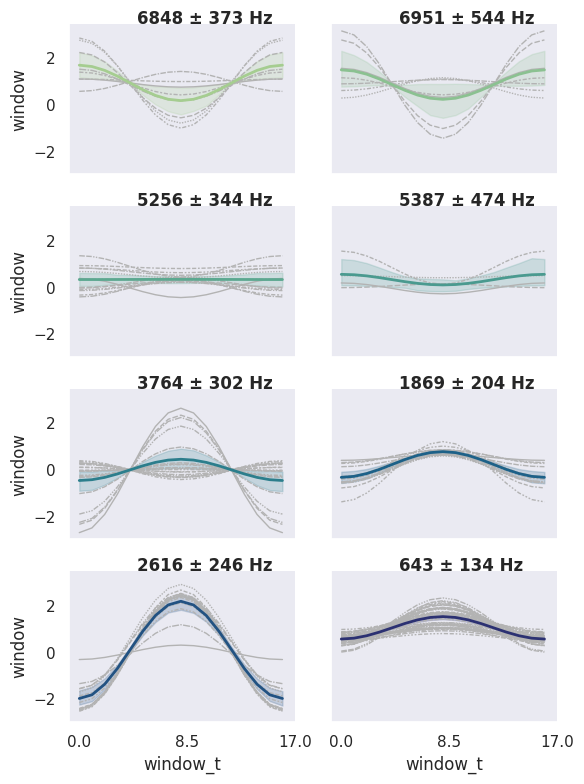

In [28]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


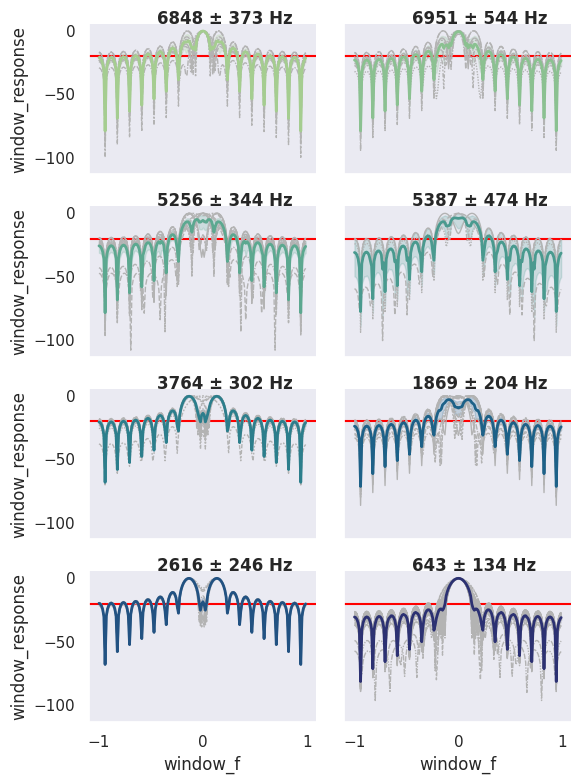

In [29]:
filtviz.visualize_filters(filter_domain='freq')

In [30]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

downsample_factor: 8 => new_sample_rate: 2000


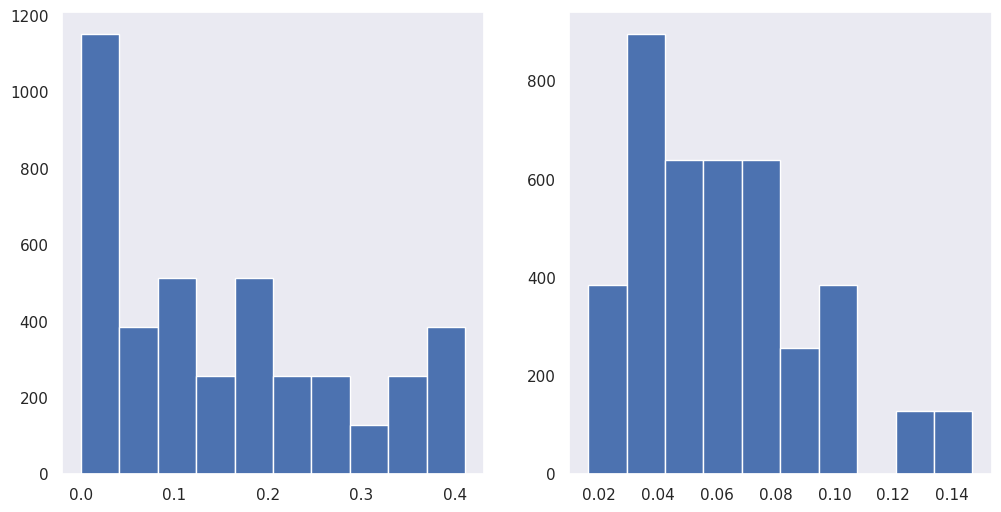

In [35]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


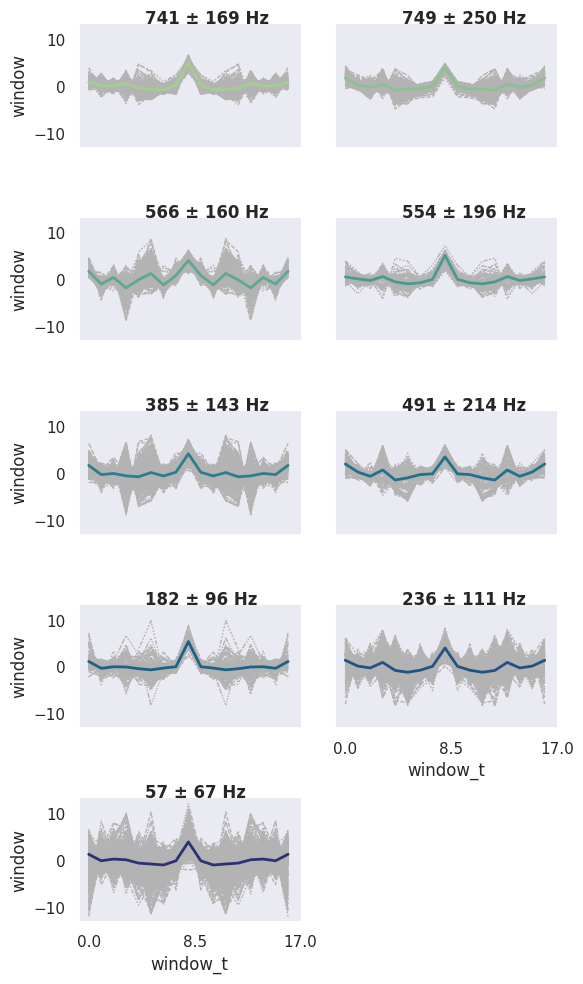

In [36]:
filtviz2.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


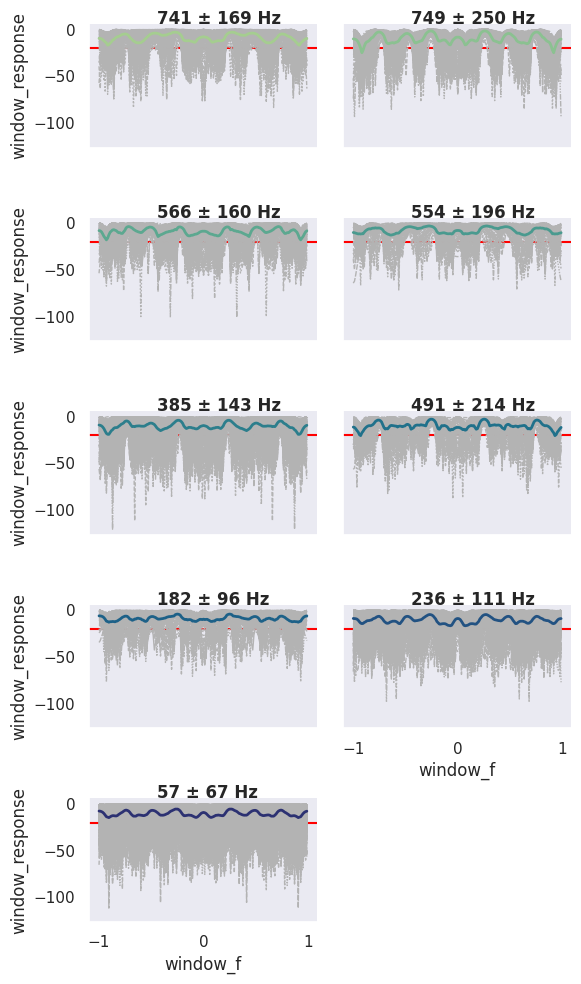

In [37]:
filtviz2.visualize_filters('freq')

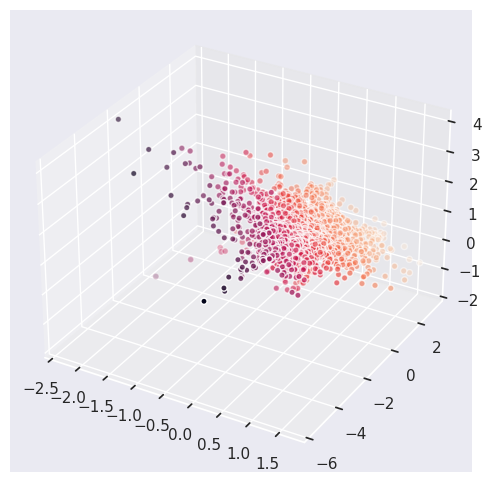

In [38]:
filtviz2.visualize_window_params()

In [34]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                            | 0.00205761316872428/50 [00:00<3:40:24, 264.51s/it]

Train Epoch: 11 [0/11685 (0%)]	Loss: 0.091034
Mem before-during-after: 32568832 4375917056 33811968


  0%|                                                            | 0.08436213991769549/50 [00:21<3:30:18, 252.80s/it]

Train Epoch: 11 [1280/11685 (11%)]	Loss: 0.080744
Mem before-during-after: 33811968 4377243136 33811968


  0%|▏                                                           | 0.16666666666666657/50 [00:41<3:30:35, 253.56s/it]

Train Epoch: 11 [2560/11685 (22%)]	Loss: 0.442821
Mem before-during-after: 33811968 4377243136 33811968


  0%|▎                                                            | 0.2489711934156374/50 [01:02<3:34:50, 259.09s/it]

Train Epoch: 11 [3840/11685 (33%)]	Loss: 0.168017
Mem before-during-after: 33811968 4377243136 33811968


  1%|▍                                                            | 0.3312757201646082/50 [01:23<3:41:51, 268.01s/it]

Train Epoch: 11 [5120/11685 (44%)]	Loss: 0.817388
Mem before-during-after: 33811968 4377243136 33811968


  1%|▍                                                           | 0.41358024691357903/50 [01:44<3:32:36, 257.25s/it]

Train Epoch: 11 [6400/11685 (55%)]	Loss: 0.422350
Mem before-during-after: 33811968 4377243136 33811968


  1%|▌                                                           | 0.49588477366254985/50 [02:05<3:35:11, 260.81s/it]

Train Epoch: 11 [7680/11685 (66%)]	Loss: 0.775115
Mem before-during-after: 33811968 4377243136 33811968


  1%|▋                                                            | 0.5781893004115227/50 [02:26<3:31:38, 256.95s/it]

Train Epoch: 11 [8960/11685 (77%)]	Loss: 0.285931
Mem before-during-after: 33811968 4377243136 33811968


  1%|▊                                                            | 0.6604938271604958/50 [02:46<3:31:07, 256.74s/it]

Train Epoch: 11 [10240/11685 (88%)]	Loss: 1.492215
Mem before-during-after: 33811968 4377243136 33811968


  1%|▉                                                            | 0.7427983539094688/50 [03:07<3:36:16, 263.45s/it]

Train Epoch: 11 [11520/11685 (99%)]	Loss: 0.431931
Mem before-during-after: 33811968 4377243136 33811968


  2%|█▏                                                           | 1.0000000000000095/50 [03:38<1:31:44, 112.33s/it]


Test Epoch: 11	Accuracy: 3275/3872 (84%)



  2%|█▏                                                           | 1.0020576131687338/50 [03:38<2:00:56, 148.10s/it]

Train Epoch: 12 [0/11685 (0%)]	Loss: 0.115468
Mem before-during-after: 33804800 4377169408 33811968


  2%|█▎                                                           | 1.0843621399177024/50 [03:59<3:27:25, 254.44s/it]

Train Epoch: 12 [1280/11685 (11%)]	Loss: 0.113673
Mem before-during-after: 33828352 4376686592 33828352


  2%|█▍                                                            | 1.166666666666671/50 [04:20<3:28:29, 256.16s/it]

Train Epoch: 12 [2560/11685 (22%)]	Loss: 0.278388
Mem before-during-after: 33828352 4376686592 33828352


  2%|█▌                                                           | 1.2489711934156396/50 [04:41<3:26:56, 254.68s/it]

Train Epoch: 12 [3840/11685 (33%)]	Loss: 0.059620
Mem before-during-after: 33828352 4376686592 33828352


  3%|█▌                                                           | 1.3312757201646082/50 [05:01<3:28:17, 256.79s/it]

Train Epoch: 12 [5120/11685 (44%)]	Loss: 0.747878
Mem before-during-after: 33828352 4376686592 33828352


  3%|█▋                                                           | 1.4135802469135768/50 [05:22<3:26:08, 254.56s/it]

Train Epoch: 12 [6400/11685 (55%)]	Loss: 0.400275
Mem before-during-after: 33828352 4376686592 33828352


  3%|█▊                                                           | 1.4958847736625454/50 [05:43<3:25:48, 254.58s/it]

Train Epoch: 12 [7680/11685 (66%)]	Loss: 0.841719
Mem before-during-after: 33828352 4376686592 33828352


  3%|█▉                                                            | 1.578189300411514/50 [06:03<3:26:04, 255.34s/it]

Train Epoch: 12 [8960/11685 (77%)]	Loss: 0.311154
Mem before-during-after: 33828352 4376686592 33828352


  3%|██                                                           | 1.6604938271604825/50 [06:24<3:28:18, 258.56s/it]

Train Epoch: 12 [10240/11685 (88%)]	Loss: 1.691634
Mem before-during-after: 33828352 4376686592 33828352


  3%|██▏                                                          | 1.7427983539094511/50 [06:44<3:26:02, 256.17s/it]

Train Epoch: 12 [11520/11685 (99%)]	Loss: 0.432217
Mem before-during-after: 33828352 4376686592 33828352


  4%|██▍                                                           | 1.999999999999978/50 [07:15<1:30:28, 113.08s/it]


Test Epoch: 12	Accuracy: 3260/3872 (84%)



  4%|██▍                                                          | 2.0020576131687022/50 [07:15<1:59:52, 149.85s/it]

Train Epoch: 13 [0/11685 (0%)]	Loss: 0.074311
Mem before-during-after: 33804800 4377234944 34746368


  4%|██▌                                                          | 2.0843621399176797/50 [07:36<3:28:05, 260.56s/it]

Train Epoch: 13 [1280/11685 (11%)]	Loss: 0.092846
Mem before-during-after: 33828352 4377055232 33828352


  4%|██▋                                                           | 2.166666666666657/50 [07:57<3:25:19, 257.55s/it]

Train Epoch: 13 [2560/11685 (22%)]	Loss: 0.254479
Mem before-during-after: 33828352 4377055232 33828352


  4%|██▋                                                          | 2.2489711934156347/50 [08:17<3:25:26, 258.13s/it]

Train Epoch: 13 [3840/11685 (33%)]	Loss: 0.064365
Mem before-during-after: 33828352 4377055232 33828352


  5%|██▉                                                           | 2.331275720164612/50 [08:38<3:24:21, 257.22s/it]

Train Epoch: 13 [5120/11685 (44%)]	Loss: 0.805858
Mem before-during-after: 33828352 4377055232 33828352


  5%|██▉                                                          | 2.4135802469135896/50 [08:59<3:23:58, 257.19s/it]

Train Epoch: 13 [6400/11685 (55%)]	Loss: 0.371040
Mem before-during-after: 33828352 4377055232 33828352


  5%|███                                                           | 2.495884773662567/50 [09:20<3:24:46, 258.64s/it]

Train Epoch: 13 [7680/11685 (66%)]	Loss: 0.778288
Mem before-during-after: 33828352 4377055232 33828352


  5%|███▏                                                         | 2.5781893004115446/50 [09:40<3:22:55, 256.74s/it]

Train Epoch: 13 [8960/11685 (77%)]	Loss: 0.279779
Mem before-during-after: 33828352 4377055232 33828352


  5%|███▎                                                          | 2.660493827160522/50 [10:01<3:22:33, 256.74s/it]

Train Epoch: 13 [10240/11685 (88%)]	Loss: 1.799001
Mem before-during-after: 33828352 4377055232 33828352


  5%|███▎                                                         | 2.7427983539094996/50 [10:22<3:20:19, 254.34s/it]

Train Epoch: 13 [11520/11685 (99%)]	Loss: 0.465286
Mem before-during-after: 33828352 4377055232 33828352


  6%|███▋                                                          | 3.000000000000054/50 [10:52<1:27:50, 112.14s/it]


Test Epoch: 13	Accuracy: 3244/3872 (83%)



  6%|███▋                                                         | 3.0020576131687786/50 [10:53<1:57:43, 150.30s/it]

Train Epoch: 14 [0/11685 (0%)]	Loss: 0.046771
Mem before-during-after: 33804800 4377234944 34746368


  6%|███▊                                                          | 3.084362139917756/50 [11:14<3:20:24, 256.29s/it]

Train Epoch: 14 [1280/11685 (11%)]	Loss: 0.085924
Mem before-during-after: 33828352 4377055232 33828352


  6%|███▊                                                         | 3.1666666666667336/50 [11:34<3:31:56, 271.52s/it]

Train Epoch: 14 [2560/11685 (22%)]	Loss: 0.286188
Mem before-during-after: 33828352 4377055232 33828352


  6%|████                                                          | 3.248971193415711/50 [11:55<3:19:49, 256.46s/it]

Train Epoch: 14 [3840/11685 (33%)]	Loss: 0.093665
Mem before-during-after: 33828352 4377055232 33828352


  7%|████                                                         | 3.3312757201646885/50 [12:16<3:20:02, 257.19s/it]

Train Epoch: 14 [5120/11685 (44%)]	Loss: 0.831564
Mem before-during-after: 33828352 4377055232 33828352


  7%|████▏                                                         | 3.413580246913666/50 [12:37<3:23:40, 262.32s/it]

Train Epoch: 14 [6400/11685 (55%)]	Loss: 0.385534
Mem before-during-after: 33828352 4377055232 33828352


  7%|████▎                                                        | 3.4958847736626435/50 [12:57<3:16:05, 253.00s/it]

Train Epoch: 14 [7680/11685 (66%)]	Loss: 0.786488
Mem before-during-after: 33828352 4377055232 33828352


  7%|████▍                                                         | 3.578189300411621/50 [13:18<3:21:10, 260.02s/it]

Train Epoch: 14 [8960/11685 (77%)]	Loss: 0.254147
Mem before-during-after: 33828352 4377055232 33828352


  7%|████▍                                                        | 3.6604938271605985/50 [13:39<3:18:18, 256.78s/it]

Train Epoch: 14 [10240/11685 (88%)]	Loss: 1.906783
Mem before-during-after: 33828352 4377055232 33828352


  7%|████▋                                                         | 3.742798353909576/50 [13:59<3:17:43, 256.47s/it]

Train Epoch: 14 [11520/11685 (99%)]	Loss: 0.475371
Mem before-during-after: 33828352 4377055232 33828352


  8%|████▉                                                         | 4.000000000000131/50 [14:30<1:26:34, 112.93s/it]


Test Epoch: 14	Accuracy: 3242/3872 (83%)



  8%|████▉                                                         | 4.002057613168855/50 [14:30<1:56:40, 152.19s/it]

Train Epoch: 15 [0/11685 (0%)]	Loss: 0.037188
Mem before-during-after: 33804800 4377234944 34746368


  8%|████▉                                                        | 4.0843621399178325/50 [14:51<3:14:24, 254.03s/it]

Train Epoch: 15 [1280/11685 (11%)]	Loss: 0.086340
Mem before-during-after: 33828352 4377055232 33828352


  8%|█████▎                                                         | 4.16666666666681/50 [15:12<3:17:28, 258.51s/it]

Train Epoch: 15 [2560/11685 (22%)]	Loss: 0.318867
Mem before-during-after: 33828352 4377055232 33828352


  8%|█████▎                                                        | 4.248971193415787/50 [15:33<3:14:53, 255.58s/it]

Train Epoch: 15 [3840/11685 (33%)]	Loss: 0.129906
Mem before-during-after: 33828352 4377055232 33828352


  9%|█████▎                                                        | 4.331275720164765/50 [15:53<3:16:10, 257.74s/it]

Train Epoch: 15 [5120/11685 (44%)]	Loss: 0.815167
Mem before-during-after: 33828352 4377055232 33828352


  9%|█████▍                                                        | 4.413580246913742/50 [16:14<3:16:53, 259.15s/it]

Train Epoch: 15 [6400/11685 (55%)]	Loss: 0.394286
Mem before-during-after: 33828352 4377055232 33828352


  9%|█████▋                                                         | 4.49588477366272/50 [16:35<3:13:38, 255.32s/it]

Train Epoch: 15 [7680/11685 (66%)]	Loss: 0.793530
Mem before-during-after: 33828352 4377055232 33828352


  9%|█████▋                                                        | 4.578189300411697/50 [16:56<3:13:26, 255.53s/it]

Train Epoch: 15 [8960/11685 (77%)]	Loss: 0.247768
Mem before-during-after: 33828352 4377055232 33828352


  9%|█████▊                                                        | 4.660493827160675/50 [17:17<3:14:32, 257.45s/it]

Train Epoch: 15 [10240/11685 (88%)]	Loss: 2.053262
Mem before-during-after: 33828352 4377055232 33828352


  9%|█████▉                                                        | 4.742798353909652/50 [17:38<3:17:28, 261.81s/it]

Train Epoch: 15 [11520/11685 (99%)]	Loss: 0.479272
Mem before-during-after: 33828352 4377055232 33828352


 10%|██████▏                                                       | 5.000000000000207/50 [18:09<1:23:23, 111.19s/it]


Test Epoch: 15	Accuracy: 3242/3872 (83%)



 10%|██████▏                                                       | 5.002057613168931/50 [18:09<1:51:36, 148.81s/it]

Train Epoch: 16 [0/11685 (0%)]	Loss: 0.029889
Mem before-during-after: 33804800 4377234944 34746368


 10%|██████▎                                                       | 5.084362139917909/50 [18:30<3:12:05, 256.60s/it]

Train Epoch: 16 [1280/11685 (11%)]	Loss: 0.078419
Mem before-during-after: 33828352 4377055232 33828352


 10%|██████▍                                                       | 5.166666666666886/50 [18:51<3:12:05, 257.07s/it]

Train Epoch: 16 [2560/11685 (22%)]	Loss: 0.332709
Mem before-during-after: 33828352 4377055232 33828352


 10%|██████▌                                                       | 5.248971193415864/50 [19:11<3:10:54, 255.95s/it]

Train Epoch: 16 [3840/11685 (33%)]	Loss: 0.162935
Mem before-during-after: 33828352 4377055232 33828352


 11%|██████▌                                                       | 5.331275720164841/50 [19:32<3:13:43, 260.22s/it]

Train Epoch: 16 [5120/11685 (44%)]	Loss: 0.808593
Mem before-during-after: 33828352 4377055232 33828352


 11%|██████▋                                                       | 5.413580246913819/50 [19:53<3:12:21, 258.85s/it]

Train Epoch: 16 [6400/11685 (55%)]	Loss: 0.395893
Mem before-during-after: 33828352 4377055232 33828352


 11%|██████▊                                                       | 5.495884773662796/50 [20:14<3:11:20, 257.96s/it]

Train Epoch: 16 [7680/11685 (66%)]	Loss: 0.803069
Mem before-during-after: 33828352 4377055232 33828352


 11%|██████▉                                                       | 5.578189300411774/50 [20:34<3:09:33, 256.03s/it]

Train Epoch: 16 [8960/11685 (77%)]	Loss: 0.244914
Mem before-during-after: 33828352 4377055232 33828352


 11%|███████                                                       | 5.660493827160751/50 [20:55<3:08:53, 255.61s/it]

Train Epoch: 16 [10240/11685 (88%)]	Loss: 2.080720
Mem before-during-after: 33828352 4377055232 33828352


 11%|███████                                                       | 5.742798353909729/50 [21:16<3:10:23, 258.11s/it]

Train Epoch: 16 [11520/11685 (99%)]	Loss: 0.477332
Mem before-during-after: 33828352 4377055232 33828352


 12%|███████▍                                                      | 6.000000000000283/50 [21:46<1:22:56, 113.11s/it]


Test Epoch: 16	Accuracy: 3247/3872 (83%)



 12%|███████▍                                                      | 6.002057613169008/50 [21:47<1:51:26, 151.98s/it]

Train Epoch: 17 [0/11685 (0%)]	Loss: 0.027325
Mem before-during-after: 33804800 4377234944 34746368


 12%|███████▌                                                      | 6.084362139917985/50 [22:08<3:07:27, 256.11s/it]

Train Epoch: 17 [1280/11685 (11%)]	Loss: 0.072324
Mem before-during-after: 33828352 4377055232 33828352


 12%|███████▋                                                      | 6.166666666666963/50 [22:29<3:07:35, 256.79s/it]

Train Epoch: 17 [2560/11685 (22%)]	Loss: 0.350014
Mem before-during-after: 33828352 4377055232 33828352


 12%|███████▊                                                       | 6.24897119341594/50 [22:49<3:07:53, 257.68s/it]

Train Epoch: 17 [3840/11685 (33%)]	Loss: 0.201654
Mem before-during-after: 33828352 4377055232 33828352


 13%|███████▊                                                      | 6.331275720164918/50 [23:10<3:06:56, 256.85s/it]

Train Epoch: 17 [5120/11685 (44%)]	Loss: 0.794751
Mem before-during-after: 33828352 4377055232 33828352


 13%|███████▉                                                      | 6.413580246913895/50 [23:31<3:06:21, 256.53s/it]

Train Epoch: 17 [6400/11685 (55%)]	Loss: 0.408492
Mem before-during-after: 33828352 4377055232 33828352


 13%|████████                                                      | 6.495884773662873/50 [23:52<3:04:16, 254.15s/it]

Train Epoch: 17 [7680/11685 (66%)]	Loss: 0.812343
Mem before-during-after: 33828352 4377055232 33828352


 13%|████████▎                                                      | 6.57818930041185/50 [24:13<3:04:33, 255.02s/it]

Train Epoch: 17 [8960/11685 (77%)]	Loss: 0.249907
Mem before-during-after: 33828352 4377055232 33828352


 13%|████████▎                                                     | 6.660493827160828/50 [24:33<3:07:43, 259.90s/it]

Train Epoch: 17 [10240/11685 (88%)]	Loss: 2.040443
Mem before-during-after: 33828352 4377055232 33828352


 13%|████████▎                                                     | 6.742798353909805/50 [24:54<3:07:02, 259.44s/it]

Train Epoch: 17 [11520/11685 (99%)]	Loss: 0.472716
Mem before-during-after: 33828352 4377055232 33828352


 14%|████████▊                                                      | 7.00000000000036/50 [25:25<1:20:47, 112.73s/it]


Test Epoch: 17	Accuracy: 3256/3872 (84%)



 14%|████████▋                                                     | 7.002057613169084/50 [25:25<1:52:07, 156.47s/it]

Train Epoch: 18 [0/11685 (0%)]	Loss: 0.025906
Mem before-during-after: 33804800 4377234944 34746368


 14%|████████▊                                                     | 7.084362139918062/50 [25:46<3:03:23, 256.41s/it]

Train Epoch: 18 [1280/11685 (11%)]	Loss: 0.066470
Mem before-during-after: 33828352 4377055232 33828352


 14%|████████▉                                                     | 7.166666666667039/50 [26:07<3:04:11, 258.00s/it]

Train Epoch: 18 [2560/11685 (22%)]	Loss: 0.359052
Mem before-during-after: 33828352 4377055232 33828352


 14%|████████▉                                                     | 7.248971193416017/50 [26:28<3:04:06, 258.38s/it]

Train Epoch: 18 [3840/11685 (33%)]	Loss: 0.227906
Mem before-during-after: 33828352 4377055232 33828352


 15%|█████████                                                     | 7.331275720164994/50 [26:48<3:03:34, 258.14s/it]

Train Epoch: 18 [5120/11685 (44%)]	Loss: 0.816261
Mem before-during-after: 33828352 4377055232 33828352


 15%|█████████                                                    | 7.4135802469139715/50 [27:09<3:02:41, 257.39s/it]

Train Epoch: 18 [6400/11685 (55%)]	Loss: 0.402550
Mem before-during-after: 33828352 4377055232 33828352


 15%|█████████▎                                                    | 7.495884773662949/50 [27:30<3:04:45, 260.80s/it]

Train Epoch: 18 [7680/11685 (66%)]	Loss: 0.808338
Mem before-during-after: 33828352 4377055232 33828352


 15%|█████████▏                                                   | 7.5781893004119265/50 [27:51<3:01:27, 256.66s/it]

Train Epoch: 18 [8960/11685 (77%)]	Loss: 0.257746
Mem before-during-after: 33828352 4377055232 33828352


 15%|█████████▍                                                    | 7.660493827160904/50 [28:12<3:17:49, 280.33s/it]

Train Epoch: 18 [10240/11685 (88%)]	Loss: 2.088548
Mem before-during-after: 33828352 4377055232 33828352


 15%|█████████▍                                                   | 7.7427983539098815/50 [28:33<3:00:37, 256.46s/it]

Train Epoch: 18 [11520/11685 (99%)]	Loss: 0.485831
Mem before-during-after: 33828352 4377055232 33828352


 16%|█████████▉                                                    | 8.000000000000435/50 [29:03<1:18:20, 111.93s/it]


Test Epoch: 18	Accuracy: 3247/3872 (83%)



 16%|█████████▉                                                    | 8.002057613169159/50 [29:04<1:45:40, 150.98s/it]

Train Epoch: 19 [0/11685 (0%)]	Loss: 0.024488
Mem before-during-after: 33804800 4377234944 34746368


 16%|██████████▎                                                     | 8.0843621399181/50 [29:24<3:04:25, 264.00s/it]

Train Epoch: 19 [1280/11685 (11%)]	Loss: 0.057682
Mem before-during-after: 33828352 4377055232 33828352


 16%|██████████▏                                                   | 8.166666666667043/50 [29:45<2:58:02, 255.36s/it]

Train Epoch: 19 [2560/11685 (22%)]	Loss: 0.370455
Mem before-during-after: 33828352 4377055232 33828352


 16%|██████████▏                                                   | 8.248971193415985/50 [30:06<3:00:18, 259.12s/it]

Train Epoch: 19 [3840/11685 (33%)]	Loss: 0.233402
Mem before-during-after: 33828352 4377055232 33828352


 17%|██████████▎                                                   | 8.331275720164927/50 [30:27<3:00:14, 259.53s/it]

Train Epoch: 19 [5120/11685 (44%)]	Loss: 0.785154
Mem before-during-after: 33828352 4377055232 33828352


 17%|██████████▍                                                   | 8.413580246913869/50 [30:47<2:55:25, 253.10s/it]

Train Epoch: 19 [6400/11685 (55%)]	Loss: 0.399948
Mem before-during-after: 33828352 4377055232 33828352


 17%|██████████▋                                                    | 8.49588477366281/50 [31:08<2:57:40, 256.85s/it]

Train Epoch: 19 [7680/11685 (66%)]	Loss: 0.802203
Mem before-during-after: 33828352 4377055232 33828352


 17%|██████████▋                                                   | 8.578189300411752/50 [31:28<2:57:56, 257.75s/it]

Train Epoch: 19 [8960/11685 (77%)]	Loss: 0.262986
Mem before-during-after: 33828352 4377055232 33828352


 17%|██████████▋                                                   | 8.660493827160694/50 [31:50<2:58:32, 259.14s/it]

Train Epoch: 19 [10240/11685 (88%)]	Loss: 2.154812
Mem before-during-after: 33828352 4377055232 33828352


 17%|██████████▊                                                   | 8.742798353909636/50 [32:11<2:58:42, 259.88s/it]

Train Epoch: 19 [11520/11685 (99%)]	Loss: 0.480276
Mem before-during-after: 33828352 4377055232 33828352


 18%|███████████▎                                                   | 9.00000000000008/50 [32:41<1:19:21, 116.13s/it]


Test Epoch: 19	Accuracy: 3267/3872 (84%)



 18%|███████████▏                                                  | 9.002057613168803/50 [32:41<1:43:33, 151.55s/it]

Train Epoch: 20 [0/11685 (0%)]	Loss: 0.023725
Mem before-during-after: 33804800 4377234944 34746368


 18%|███████████▎                                                  | 9.084362139917745/50 [33:02<2:54:40, 256.14s/it]

Train Epoch: 20 [1280/11685 (11%)]	Loss: 0.056885
Mem before-during-after: 33828352 4377055232 33828352


 18%|███████████▎                                                  | 9.166666666666687/50 [33:23<2:53:22, 254.76s/it]

Train Epoch: 20 [2560/11685 (22%)]	Loss: 0.384016
Mem before-during-after: 33828352 4377055232 33828352


 18%|███████████▋                                                   | 9.24897119341563/50 [33:43<2:55:02, 257.72s/it]

Train Epoch: 20 [3840/11685 (33%)]	Loss: 0.241122
Mem before-during-after: 33828352 4377055232 33828352


 19%|███████████▌                                                  | 9.331275720164571/50 [34:04<2:51:46, 253.42s/it]

Train Epoch: 20 [5120/11685 (44%)]	Loss: 0.792115
Mem before-during-after: 33828352 4377055232 33828352


 19%|███████████▋                                                  | 9.413580246913513/50 [34:25<2:53:10, 256.01s/it]

Train Epoch: 20 [6400/11685 (55%)]	Loss: 0.403402
Mem before-during-after: 33828352 4377055232 33828352


 19%|███████████▊                                                  | 9.495884773662455/50 [34:46<2:53:49, 257.49s/it]

Train Epoch: 20 [7680/11685 (66%)]	Loss: 0.804871
Mem before-during-after: 33828352 4377055232 33828352


 19%|███████████▉                                                  | 9.578189300411397/50 [35:07<2:54:14, 258.63s/it]

Train Epoch: 20 [8960/11685 (77%)]	Loss: 0.269422
Mem before-during-after: 33828352 4377055232 33828352


 19%|███████████▉                                                  | 9.660493827160339/50 [35:27<2:50:56, 254.25s/it]

Train Epoch: 20 [10240/11685 (88%)]	Loss: 2.220362
Mem before-during-after: 33828352 4377055232 33828352


 19%|████████████                                                  | 9.742798353909281/50 [35:48<2:50:45, 254.51s/it]

Train Epoch: 20 [11520/11685 (99%)]	Loss: 0.485898
Mem before-during-after: 33828352 4377055232 33828352


 20%|████████████▍                                                 | 9.999999999999725/50 [36:18<1:15:10, 112.75s/it]


Test Epoch: 20	Accuracy: 3268/3872 (84%)



 20%|████████████▏                                                | 10.002057613168448/50 [36:19<1:40:33, 150.84s/it]

Train Epoch: 21 [0/11685 (0%)]	Loss: 0.021913
Mem before-during-after: 33804800 4377234944 34746368


 20%|████████████▌                                                 | 10.08436213991739/50 [36:39<2:51:29, 257.77s/it]

Train Epoch: 21 [1280/11685 (11%)]	Loss: 0.056242
Mem before-during-after: 33828352 4377055232 33828352


 20%|████████████▍                                                | 10.166666666666332/50 [37:00<2:48:09, 253.30s/it]

Train Epoch: 21 [2560/11685 (22%)]	Loss: 0.383361
Mem before-during-after: 33828352 4377055232 33828352


 20%|████████████▌                                                | 10.248971193415274/50 [37:21<2:53:25, 261.75s/it]

Train Epoch: 21 [3840/11685 (33%)]	Loss: 0.266949
Mem before-during-after: 33828352 4377055232 33828352


 21%|████████████▌                                                | 10.331275720164216/50 [37:42<2:52:43, 261.25s/it]

Train Epoch: 21 [5120/11685 (44%)]	Loss: 0.784402
Mem before-during-after: 33828352 4377055232 33828352


 21%|████████████▋                                                | 10.413580246913158/50 [38:03<2:52:27, 261.38s/it]

Train Epoch: 21 [6400/11685 (55%)]	Loss: 0.409241
Mem before-during-after: 33828352 4377055232 33828352


 21%|█████████████▏                                                 | 10.4958847736621/50 [38:24<2:50:59, 259.70s/it]

Train Epoch: 21 [7680/11685 (66%)]	Loss: 0.803218
Mem before-during-after: 33828352 4377055232 33828352


 21%|████████████▉                                                | 10.578189300411042/50 [38:45<2:50:10, 259.02s/it]

Train Epoch: 21 [8960/11685 (77%)]	Loss: 0.277151
Mem before-during-after: 33828352 4377055232 33828352


 21%|█████████████                                                | 10.660493827159984/50 [39:06<2:50:33, 260.14s/it]

Train Epoch: 21 [10240/11685 (88%)]	Loss: 2.206718
Mem before-during-after: 33828352 4377055232 33828352


 21%|█████████████                                                | 10.742798353908926/50 [39:27<2:49:51, 259.62s/it]

Train Epoch: 21 [11520/11685 (99%)]	Loss: 0.506533
Mem before-during-after: 33828352 4377055232 33828352


 22%|█████████████▋                                                | 10.99999999999937/50 [39:58<1:15:59, 116.90s/it]


Test Epoch: 21	Accuracy: 3280/3872 (84%)



 22%|█████████████▍                                               | 11.002057613168093/50 [39:59<1:39:07, 152.52s/it]

Train Epoch: 22 [0/11685 (0%)]	Loss: 0.019911
Mem before-during-after: 33804800 4377234944 34746368


 22%|█████████████▌                                               | 11.084362139917035/50 [40:20<2:50:31, 262.92s/it]

Train Epoch: 22 [1280/11685 (11%)]	Loss: 0.055085
Mem before-during-after: 33828352 4377055232 33828352


 22%|█████████████▌                                               | 11.166666666665977/50 [40:41<2:49:21, 261.68s/it]

Train Epoch: 22 [2560/11685 (22%)]	Loss: 0.382682
Mem before-during-after: 33828352 4377055232 33828352


 22%|█████████████▋                                               | 11.248971193414919/50 [41:02<2:49:26, 262.36s/it]

Train Epoch: 22 [3840/11685 (33%)]	Loss: 0.292556
Mem before-during-after: 33828352 4377055232 33828352


 23%|██████████████                                                | 11.33127572016386/50 [41:23<2:47:55, 260.56s/it]

Train Epoch: 22 [5120/11685 (44%)]	Loss: 0.769239
Mem before-during-after: 33828352 4377055232 33828352


 23%|█████████████▉                                               | 11.413580246912803/50 [41:44<2:46:07, 258.32s/it]

Train Epoch: 22 [6400/11685 (55%)]	Loss: 0.411291
Mem before-during-after: 33828352 4377055232 33828352


 23%|██████████████                                               | 11.495884773661745/50 [42:05<2:46:16, 259.11s/it]

Train Epoch: 22 [7680/11685 (66%)]	Loss: 0.801362
Mem before-during-after: 33828352 4377055232 33828352


 23%|██████████████▏                                              | 11.578189300410687/50 [42:26<2:46:14, 259.61s/it]

Train Epoch: 22 [8960/11685 (77%)]	Loss: 0.276164
Mem before-during-after: 33828352 4377055232 33828352


 23%|██████████████▏                                              | 11.660493827159629/50 [42:47<2:47:23, 261.95s/it]

Train Epoch: 22 [10240/11685 (88%)]	Loss: 2.233342
Mem before-during-after: 33828352 4377055232 33828352


 23%|██████████████▌                                               | 11.74279835390857/50 [43:08<2:49:47, 266.30s/it]

Train Epoch: 22 [11520/11685 (99%)]	Loss: 0.491821
Mem before-during-after: 33828352 4377055232 33828352


 24%|██████████████▋                                              | 11.999999999999014/50 [43:40<1:13:06, 115.43s/it]


Test Epoch: 22	Accuracy: 3282/3872 (84%)



 24%|██████████████▋                                              | 12.002057613167738/50 [43:40<1:35:47, 151.26s/it]

Train Epoch: 23 [0/11685 (0%)]	Loss: 0.020625
Mem before-during-after: 33804800 4377234944 34746368


 24%|██████████████▉                                               | 12.08436213991668/50 [44:01<2:43:41, 259.04s/it]

Train Epoch: 23 [1280/11685 (11%)]	Loss: 0.052299
Mem before-during-after: 33828352 4377055232 33828352


 24%|██████████████▊                                              | 12.166666666665622/50 [44:22<2:40:55, 255.22s/it]

Train Epoch: 23 [2560/11685 (22%)]	Loss: 0.377326
Mem before-during-after: 33828352 4377055232 33828352


 24%|██████████████▉                                              | 12.248971193414564/50 [44:43<2:40:18, 254.79s/it]

Train Epoch: 23 [3840/11685 (33%)]	Loss: 0.285060
Mem before-during-after: 33828352 4377055232 33828352


 25%|███████████████                                              | 12.331275720163505/50 [45:03<2:41:08, 256.67s/it]

Train Epoch: 23 [5120/11685 (44%)]	Loss: 0.764301
Mem before-during-after: 33828352 4377055232 33828352


 25%|███████████████▏                                             | 12.413580246912447/50 [45:24<2:41:39, 258.07s/it]

Train Epoch: 23 [6400/11685 (55%)]	Loss: 0.402173
Mem before-during-after: 33828352 4377055232 33828352


 25%|███████████████▍                                              | 12.49588477366139/50 [45:45<2:38:53, 254.21s/it]

Train Epoch: 23 [7680/11685 (66%)]	Loss: 0.774953
Mem before-during-after: 33828352 4377055232 33828352


 25%|███████████████▎                                             | 12.578189300410331/50 [46:06<2:39:23, 255.56s/it]

Train Epoch: 23 [8960/11685 (77%)]	Loss: 0.280747
Mem before-during-after: 33828352 4377055232 33828352


 25%|███████████████▍                                             | 12.660493827159273/50 [46:26<2:39:08, 255.72s/it]

Train Epoch: 23 [10240/11685 (88%)]	Loss: 2.324115
Mem before-during-after: 33828352 4377055232 33828352


 25%|███████████████▌                                             | 12.742798353908215/50 [46:47<2:40:10, 257.95s/it]

Train Epoch: 23 [11520/11685 (99%)]	Loss: 0.503298
Mem before-during-after: 33828352 4377055232 33828352


 26%|███████████████▊                                             | 12.999999999998659/50 [47:18<1:10:40, 114.60s/it]


Test Epoch: 23	Accuracy: 3284/3872 (84%)



 26%|███████████████▊                                             | 13.002057613167382/50 [47:18<1:32:58, 150.79s/it]

Train Epoch: 24 [0/11685 (0%)]	Loss: 0.019630
Mem before-during-after: 33804800 4377234944 34746368


 26%|███████████████▉                                             | 13.084362139916324/50 [47:39<2:38:55, 258.30s/it]

Train Epoch: 24 [1280/11685 (11%)]	Loss: 0.052276
Mem before-during-after: 33828352 4377055232 33828352


 26%|████████████████                                             | 13.166666666665266/50 [48:00<2:38:21, 257.95s/it]

Train Epoch: 24 [2560/11685 (22%)]	Loss: 0.388235
Mem before-during-after: 33828352 4377055232 33828352


 26%|████████████████▏                                            | 13.248971193414208/50 [48:21<2:36:11, 254.99s/it]

Train Epoch: 24 [3840/11685 (33%)]	Loss: 0.291003
Mem before-during-after: 33828352 4377055232 33828352


 27%|████████████████▌                                             | 13.33127572016315/50 [48:41<2:35:55, 255.13s/it]

Train Epoch: 24 [5120/11685 (44%)]	Loss: 0.763876
Mem before-during-after: 33828352 4377055232 33828352


 27%|████████████████▎                                            | 13.413580246912092/50 [49:02<2:37:15, 257.89s/it]

Train Epoch: 24 [6400/11685 (55%)]	Loss: 0.412921
Mem before-during-after: 33828352 4377055232 33828352


 27%|████████████████▍                                            | 13.495884773661034/50 [49:23<2:36:04, 256.54s/it]

Train Epoch: 24 [7680/11685 (66%)]	Loss: 0.776781
Mem before-during-after: 33828352 4377055232 33828352


 27%|████████████████▌                                            | 13.578189300409976/50 [49:43<2:34:54, 255.18s/it]

Train Epoch: 24 [8960/11685 (77%)]	Loss: 0.291034
Mem before-during-after: 33828352 4377055232 33828352


 27%|████████████████▋                                            | 13.660493827158918/50 [50:04<2:37:23, 259.87s/it]

Train Epoch: 24 [10240/11685 (88%)]	Loss: 2.443615
Mem before-during-after: 33828352 4377055232 33828352


 27%|█████████████████                                             | 13.74279835390786/50 [50:25<2:36:57, 259.73s/it]

Train Epoch: 24 [11520/11685 (99%)]	Loss: 0.489101
Mem before-during-after: 33828352 4377055232 33828352


 28%|█████████████████                                            | 13.999999999998304/50 [50:56<1:08:04, 113.45s/it]


Test Epoch: 24	Accuracy: 3293/3872 (85%)



 28%|█████████████████                                            | 14.002057613167027/50 [50:57<1:31:07, 151.89s/it]

Train Epoch: 25 [0/11685 (0%)]	Loss: 0.021954
Mem before-during-after: 33804800 4377234944 34746368


 28%|█████████████████▏                                           | 14.084362139915969/50 [51:18<2:38:19, 264.51s/it]

Train Epoch: 25 [1280/11685 (11%)]	Loss: 0.046721
Mem before-during-after: 33828352 4377055232 33828352


 28%|█████████████████▎                                           | 14.166666666664911/50 [51:39<2:35:26, 260.28s/it]

Train Epoch: 25 [2560/11685 (22%)]	Loss: 0.390910
Mem before-during-after: 33828352 4377055232 33828352


 28%|█████████████████▍                                           | 14.248971193413853/50 [52:00<2:33:28, 257.58s/it]

Train Epoch: 25 [3840/11685 (33%)]	Loss: 0.307764
Mem before-during-after: 33828352 4377055232 33828352


 29%|█████████████████▍                                           | 14.331275720162795/50 [52:21<2:37:00, 264.11s/it]

Train Epoch: 25 [5120/11685 (44%)]	Loss: 0.758680
Mem before-during-after: 33828352 4377055232 33828352


 29%|█████████████████▌                                           | 14.413580246911737/50 [52:41<2:34:56, 261.24s/it]

Train Epoch: 25 [6400/11685 (55%)]	Loss: 0.408692
Mem before-during-after: 33828352 4377055232 33828352


 29%|█████████████████▋                                           | 14.495884773660679/50 [53:02<2:33:12, 258.90s/it]

Train Epoch: 25 [7680/11685 (66%)]	Loss: 0.777357
Mem before-during-after: 33828352 4377055232 33828352


 29%|██████████████████                                            | 14.57818930040962/50 [53:23<2:37:40, 267.07s/it]

Train Epoch: 25 [8960/11685 (77%)]	Loss: 0.296054
Mem before-during-after: 33828352 4377055232 33828352


 29%|█████████████████▉                                           | 14.660493827158563/50 [53:44<2:33:33, 260.71s/it]

Train Epoch: 25 [10240/11685 (88%)]	Loss: 2.445418
Mem before-during-after: 33828352 4377055232 33828352


 29%|█████████████████▉                                           | 14.742798353907505/50 [54:05<2:33:54, 261.93s/it]

Train Epoch: 25 [11520/11685 (99%)]	Loss: 0.503179
Mem before-during-after: 33828352 4377055232 33828352


 30%|██████████████████▎                                          | 14.999999999997948/50 [54:36<1:05:56, 113.06s/it]


Test Epoch: 25	Accuracy: 3289/3872 (85%)



 30%|██████████████████▎                                          | 15.002057613166672/50 [54:36<1:28:32, 151.79s/it]

Train Epoch: 26 [0/11685 (0%)]	Loss: 0.018369
Mem before-during-after: 33804800 4377234944 34746368


 30%|██████████████████▍                                          | 15.084362139915614/50 [54:57<2:32:34, 262.19s/it]

Train Epoch: 26 [1280/11685 (11%)]	Loss: 0.046852
Mem before-during-after: 33828352 4377055232 33828352


 30%|██████████████████▌                                          | 15.166666666664556/50 [55:19<2:33:07, 263.75s/it]

Train Epoch: 26 [2560/11685 (22%)]	Loss: 0.391170
Mem before-during-after: 33828352 4377055232 33828352


 30%|██████████████████▌                                          | 15.248971193413498/50 [55:40<2:32:43, 263.68s/it]

Train Epoch: 26 [3840/11685 (33%)]	Loss: 0.283358
Mem before-during-after: 33828352 4377055232 33828352


 31%|███████████████████                                           | 15.33127572016244/50 [56:01<2:29:36, 258.91s/it]

Train Epoch: 26 [5120/11685 (44%)]	Loss: 0.739007
Mem before-during-after: 33828352 4377055232 33828352


 31%|██████████████████▊                                          | 15.413580246911382/50 [56:22<2:30:32, 261.15s/it]

Train Epoch: 26 [6400/11685 (55%)]	Loss: 0.407727
Mem before-during-after: 33828352 4377055232 33828352


 31%|██████████████████▉                                          | 15.495884773660324/50 [56:43<2:32:20, 264.91s/it]

Train Epoch: 26 [7680/11685 (66%)]	Loss: 0.775729
Mem before-during-after: 33828352 4377055232 33828352


 31%|███████████████████                                          | 15.578189300409266/50 [57:04<2:29:13, 260.12s/it]

Train Epoch: 26 [8960/11685 (77%)]	Loss: 0.285381
Mem before-during-after: 33828352 4377055232 33828352


 31%|███████████████████                                          | 15.660493827158207/50 [57:24<2:25:17, 253.85s/it]

Train Epoch: 26 [10240/11685 (88%)]	Loss: 2.381160
Mem before-during-after: 33828352 4377055232 33828352


 31%|███████████████████▌                                          | 15.74279835390715/50 [57:46<2:45:58, 290.70s/it]

Train Epoch: 26 [11520/11685 (99%)]	Loss: 0.502473
Mem before-during-after: 33828352 4377055232 33828352


 32%|███████████████████▌                                         | 15.999999999997593/50 [58:17<1:03:45, 112.51s/it]


Test Epoch: 26	Accuracy: 3301/3872 (85%)



 32%|███████████████████▊                                          | 16.00205761316632/50 [58:17<1:25:47, 151.40s/it]

Train Epoch: 27 [0/11685 (0%)]	Loss: 0.018093
Mem before-during-after: 33804800 4377234944 34746368


 32%|███████████████████▉                                          | 16.08436213991526/50 [58:38<2:29:17, 264.11s/it]

Train Epoch: 27 [1280/11685 (11%)]	Loss: 0.045965
Mem before-during-after: 33828352 4377055232 33828352


 32%|███████████████████▋                                         | 16.166666666664202/50 [58:59<2:29:58, 265.98s/it]

Train Epoch: 27 [2560/11685 (22%)]	Loss: 0.394135
Mem before-during-after: 33828352 4377055232 33828352


 32%|███████████████████▊                                         | 16.248971193413144/50 [59:20<2:28:01, 263.16s/it]

Train Epoch: 27 [3840/11685 (33%)]	Loss: 0.279878
Mem before-during-after: 33828352 4377055232 33828352


 33%|███████████████████▉                                         | 16.331275720162086/50 [59:41<2:24:48, 258.05s/it]

Train Epoch: 27 [5120/11685 (44%)]	Loss: 0.732213
Mem before-during-after: 33828352 4377055232 33828352


 33%|███████████████████▎                                       | 16.413580246911028/50 [1:00:01<2:22:11, 254.01s/it]

Train Epoch: 27 [6400/11685 (55%)]	Loss: 0.414548
Mem before-during-after: 33828352 4377055232 33828352


 33%|███████████████████▊                                        | 16.49588477365997/50 [1:00:22<2:23:26, 256.87s/it]

Train Epoch: 27 [7680/11685 (66%)]	Loss: 0.779487
Mem before-during-after: 33828352 4377055232 33828352


 33%|███████████████████▌                                       | 16.578189300408912/50 [1:00:43<2:21:05, 253.29s/it]

Train Epoch: 27 [8960/11685 (77%)]	Loss: 0.284036
Mem before-during-after: 33828352 4377055232 33828352


 33%|███████████████████▋                                       | 16.660493827157854/50 [1:01:03<2:22:31, 256.49s/it]

Train Epoch: 27 [10240/11685 (88%)]	Loss: 2.422062
Mem before-during-after: 33828352 4377055232 33828352


 33%|███████████████████▊                                       | 16.742798353906796/50 [1:01:24<2:21:37, 255.51s/it]

Train Epoch: 27 [11520/11685 (99%)]	Loss: 0.498945
Mem before-during-after: 33828352 4377055232 33828352


 34%|████████████████████▍                                       | 16.99999999999724/50 [1:01:55<1:05:35, 119.26s/it]


Test Epoch: 27	Accuracy: 3298/3872 (85%)



 34%|████████████████████                                       | 17.002057613165963/50 [1:01:55<1:24:06, 152.94s/it]

Train Epoch: 28 [0/11685 (0%)]	Loss: 0.018096
Mem before-during-after: 33804800 4377234944 34746368


 34%|████████████████████▏                                      | 17.084362139914905/50 [1:02:16<2:22:00, 258.85s/it]

Train Epoch: 28 [1280/11685 (11%)]	Loss: 0.044854
Mem before-during-after: 33828352 4377055232 33828352


 34%|████████████████████▎                                      | 17.166666666663847/50 [1:02:37<2:29:46, 273.69s/it]

Train Epoch: 28 [2560/11685 (22%)]	Loss: 0.396203
Mem before-during-after: 33828352 4377055232 33828352


 34%|████████████████████▋                                       | 17.24897119341279/50 [1:02:59<2:57:09, 324.57s/it]

Train Epoch: 28 [3840/11685 (33%)]	Loss: 0.282013
Mem before-during-after: 33828352 4377055232 33828352


 35%|████████████████████▊                                       | 17.33127572016173/50 [1:03:21<2:22:24, 261.55s/it]

Train Epoch: 28 [5120/11685 (44%)]	Loss: 0.739559
Mem before-during-after: 33828352 4377055232 33828352


 35%|████████████████████▌                                      | 17.413580246910673/50 [1:03:42<2:22:28, 262.34s/it]

Train Epoch: 28 [6400/11685 (55%)]	Loss: 0.426111
Mem before-during-after: 33828352 4377055232 33828352


 35%|████████████████████▋                                      | 17.495884773659615/50 [1:04:03<2:20:19, 259.01s/it]

Train Epoch: 28 [7680/11685 (66%)]	Loss: 0.785138
Mem before-during-after: 33828352 4377055232 33828352


 35%|████████████████████▋                                      | 17.578189300408557/50 [1:04:24<2:31:18, 280.02s/it]

Train Epoch: 28 [8960/11685 (77%)]	Loss: 0.282704
Mem before-during-after: 33828352 4377055232 33828352


 35%|█████████████████████▌                                       | 17.6604938271575/50 [1:04:46<2:22:06, 263.65s/it]

Train Epoch: 28 [10240/11685 (88%)]	Loss: 2.448069
Mem before-during-after: 33828352 4377055232 33828352


 35%|█████████████████████▎                                      | 17.74279835390644/50 [1:05:07<2:18:34, 257.74s/it]

Train Epoch: 28 [11520/11685 (99%)]	Loss: 0.490689
Mem before-during-after: 33828352 4377055232 33828352


 36%|█████████████████████▏                                     | 17.999999999996884/50 [1:05:38<1:00:15, 112.98s/it]


Test Epoch: 28	Accuracy: 3304/3872 (85%)



 36%|█████████████████████▏                                     | 18.002057613165608/50 [1:05:38<1:20:43, 151.37s/it]

Train Epoch: 29 [0/11685 (0%)]	Loss: 0.020031
Mem before-during-after: 33804800 4377234944 34746368


 36%|█████████████████████▋                                      | 18.08436213991455/50 [1:06:00<2:20:26, 264.03s/it]

Train Epoch: 29 [1280/11685 (11%)]	Loss: 0.040930
Mem before-during-after: 33828352 4377055232 33828352


 36%|█████████████████████▊                                      | 18.16666666666349/50 [1:06:21<2:17:22, 258.93s/it]

Train Epoch: 29 [2560/11685 (22%)]	Loss: 0.391058
Mem before-during-after: 33828352 4377055232 33828352


 36%|█████████████████████▌                                     | 18.248971193412434/50 [1:06:42<2:15:40, 256.38s/it]

Train Epoch: 29 [3840/11685 (33%)]	Loss: 0.273752
Mem before-during-after: 33828352 4377055232 33828352


 37%|█████████████████████▋                                     | 18.331275720161376/50 [1:07:03<2:17:34, 260.64s/it]

Train Epoch: 29 [5120/11685 (44%)]	Loss: 0.734952
Mem before-during-after: 33828352 4377055232 33828352


 37%|█████████████████████▋                                     | 18.413580246910318/50 [1:07:24<2:14:27, 255.42s/it]

Train Epoch: 29 [6400/11685 (55%)]	Loss: 0.421867
Mem before-during-after: 33828352 4377055232 33828352


 37%|██████████████████████▏                                     | 18.49588477365926/50 [1:07:45<2:13:39, 254.57s/it]

Train Epoch: 29 [7680/11685 (66%)]	Loss: 0.801840
Mem before-during-after: 33828352 4377055232 33828352


 37%|██████████████████████▋                                      | 18.5781893004082/50 [1:08:05<2:13:19, 254.60s/it]

Train Epoch: 29 [8960/11685 (77%)]	Loss: 0.288564
Mem before-during-after: 33828352 4377055232 33828352


 37%|██████████████████████                                     | 18.660493827157143/50 [1:08:26<2:12:30, 253.69s/it]

Train Epoch: 29 [10240/11685 (88%)]	Loss: 2.538382
Mem before-during-after: 33828352 4377055232 33828352


 37%|██████████████████████                                     | 18.742798353906085/50 [1:08:47<2:13:09, 255.61s/it]

Train Epoch: 29 [11520/11685 (99%)]	Loss: 0.481794
Mem before-during-after: 33828352 4377055232 33828352


 38%|███████████████████████▌                                      | 18.99999999999653/50 [1:09:17<58:12, 112.65s/it]


Test Epoch: 29	Accuracy: 3318/3872 (85%)



 38%|██████████████████████▍                                    | 19.002057613165253/50 [1:09:17<1:17:41, 150.38s/it]

Train Epoch: 30 [0/11685 (0%)]	Loss: 0.022071
Mem before-during-after: 33804800 4377234944 34746368


 38%|██████████████████████▌                                    | 19.084362139914195/50 [1:09:38<2:12:21, 256.87s/it]

Train Epoch: 30 [1280/11685 (11%)]	Loss: 0.038752
Mem before-during-after: 33828352 4377055232 33828352


 38%|██████████████████████▌                                    | 19.166666666663136/50 [1:09:59<2:14:24, 261.56s/it]

Train Epoch: 30 [2560/11685 (22%)]	Loss: 0.382434
Mem before-during-after: 33828352 4377055232 33828352


 38%|███████████████████████                                     | 19.24897119341208/50 [1:10:20<2:11:55, 257.39s/it]

Train Epoch: 30 [3840/11685 (33%)]	Loss: 0.279149
Mem before-during-after: 33828352 4377055232 33828352


 39%|███████████████████████▏                                    | 19.33127572016102/50 [1:10:41<2:11:51, 257.95s/it]

Train Epoch: 30 [5120/11685 (44%)]	Loss: 0.746094
Mem before-during-after: 33828352 4377055232 33828352


 39%|██████████████████████▉                                    | 19.413580246909962/50 [1:11:02<2:11:54, 258.77s/it]

Train Epoch: 30 [6400/11685 (55%)]	Loss: 0.414679
Mem before-during-after: 33828352 4377055232 33828352


 39%|███████████████████████                                    | 19.495884773658904/50 [1:11:24<2:16:01, 267.55s/it]

Train Epoch: 30 [7680/11685 (66%)]	Loss: 0.787640
Mem before-during-after: 33828352 4377055232 33828352


 39%|███████████████████████                                    | 19.578189300407846/50 [1:11:45<2:15:24, 267.05s/it]

Train Epoch: 30 [8960/11685 (77%)]	Loss: 0.288726
Mem before-during-after: 33828352 4377055232 33828352


 39%|███████████████████████▏                                   | 19.660493827156788/50 [1:12:06<2:09:55, 256.95s/it]

Train Epoch: 30 [10240/11685 (88%)]	Loss: 2.683674
Mem before-during-after: 33828352 4377055232 33828352


 39%|███████████████████████▋                                    | 19.74279835390573/50 [1:12:27<2:10:55, 259.61s/it]

Train Epoch: 30 [11520/11685 (99%)]	Loss: 0.486251
Mem before-during-after: 33828352 4377055232 33828352


 40%|████████████████████████▍                                    | 19.999999999996174/50 [1:12:59<56:51, 113.70s/it]


Test Epoch: 30	Accuracy: 3314/3872 (85%)



 40%|███████████████████████▌                                   | 20.002057613164897/50 [1:12:59<1:15:53, 151.79s/it]

Train Epoch: 31 [0/11685 (0%)]	Loss: 0.021650
Mem before-during-after: 33804800 4377234944 34746368


 40%|████████████████████████                                    | 20.08436213991384/50 [1:13:21<2:08:33, 257.84s/it]

Train Epoch: 31 [1280/11685 (11%)]	Loss: 0.037161
Mem before-during-after: 33828352 4377055232 33828352


 40%|████████████████████████▏                                   | 20.16666666666278/50 [1:13:42<2:07:25, 256.27s/it]

Train Epoch: 31 [2560/11685 (22%)]	Loss: 0.380820
Mem before-during-after: 33828352 4377055232 33828352


 40%|███████████████████████▉                                   | 20.248971193411723/50 [1:14:02<2:07:08, 256.40s/it]

Train Epoch: 31 [3840/11685 (33%)]	Loss: 0.265706
Mem before-during-after: 33828352 4377055232 33828352


 41%|███████████████████████▉                                   | 20.331275720160665/50 [1:14:23<2:10:47, 264.52s/it]

Train Epoch: 31 [5120/11685 (44%)]	Loss: 0.757447
Mem before-during-after: 33828352 4377055232 33828352


 41%|████████████████████████                                   | 20.413580246909607/50 [1:14:44<2:08:28, 260.55s/it]

Train Epoch: 31 [6400/11685 (55%)]	Loss: 0.412836
Mem before-during-after: 33828352 4377055232 33828352


 41%|████████████████████████▌                                   | 20.49588477365855/50 [1:15:05<2:07:58, 260.24s/it]

Train Epoch: 31 [7680/11685 (66%)]	Loss: 0.787725
Mem before-during-after: 33828352 4377055232 33828352


 41%|████████████████████████▋                                   | 20.57818930040749/50 [1:15:27<2:12:01, 269.24s/it]

Train Epoch: 31 [8960/11685 (77%)]	Loss: 0.286524
Mem before-during-after: 33828352 4377055232 33828352


 41%|████████████████████████▍                                  | 20.660493827156433/50 [1:15:48<2:08:50, 263.47s/it]

Train Epoch: 31 [10240/11685 (88%)]	Loss: 2.558942
Mem before-during-after: 33828352 4377055232 33828352


 41%|████████████████████████▍                                  | 20.742798353905375/50 [1:16:09<2:05:41, 257.78s/it]

Train Epoch: 31 [11520/11685 (99%)]	Loss: 0.484791
Mem before-during-after: 33828352 4377055232 33828352


 42%|██████████████████████████                                    | 20.99999999999582/50 [1:16:40<55:30, 114.84s/it]


Test Epoch: 31	Accuracy: 3324/3872 (85%)



 42%|████████████████████████▊                                  | 21.002057613164542/50 [1:16:40<1:13:24, 151.87s/it]

Train Epoch: 32 [0/11685 (0%)]	Loss: 0.023922
Mem before-during-after: 33804800 4377234944 34746368


 42%|████████████████████████▉                                  | 21.084362139913484/50 [1:17:01<2:20:02, 290.58s/it]

Train Epoch: 32 [1280/11685 (11%)]	Loss: 0.036296
Mem before-during-after: 33828352 4377055232 33828352


 42%|████████████████████████▉                                  | 21.166666666662426/50 [1:17:22<2:04:21, 258.77s/it]

Train Epoch: 32 [2560/11685 (22%)]	Loss: 0.394491
Mem before-during-after: 33828352 4377055232 33828352


 42%|█████████████████████████                                  | 21.248971193411368/50 [1:17:43<2:03:08, 256.97s/it]

Train Epoch: 32 [3840/11685 (33%)]	Loss: 0.274673
Mem before-during-after: 33828352 4377055232 33828352


 43%|█████████████████████████▌                                  | 21.33127572016031/50 [1:18:04<2:03:46, 259.05s/it]

Train Epoch: 32 [5120/11685 (44%)]	Loss: 0.747876
Mem before-during-after: 33828352 4377055232 33828352


 43%|█████████████████████████▋                                  | 21.41358024690925/50 [1:18:25<2:03:46, 259.80s/it]

Train Epoch: 32 [6400/11685 (55%)]	Loss: 0.417486
Mem before-during-after: 33828352 4377055232 33828352


 43%|█████████████████████████▎                                 | 21.495884773658194/50 [1:18:46<2:04:12, 261.46s/it]

Train Epoch: 32 [7680/11685 (66%)]	Loss: 0.784407
Mem before-during-after: 33828352 4377055232 33828352


 43%|█████████████████████████▍                                 | 21.578189300407136/50 [1:19:07<2:03:16, 260.24s/it]

Train Epoch: 32 [8960/11685 (77%)]	Loss: 0.269208
Mem before-during-after: 33828352 4377055232 33828352


 43%|█████████████████████████▌                                 | 21.660493827156078/50 [1:19:28<2:04:46, 264.16s/it]

Train Epoch: 32 [10240/11685 (88%)]	Loss: 2.503817
Mem before-during-after: 33828352 4377055232 33828352


 43%|██████████████████████████                                  | 21.74279835390502/50 [1:19:49<2:00:53, 256.70s/it]

Train Epoch: 32 [11520/11685 (99%)]	Loss: 0.502339
Mem before-during-after: 33828352 4377055232 33828352


 44%|██████████████████████████▊                                  | 21.999999999995463/50 [1:20:21<53:26, 114.51s/it]


Test Epoch: 32	Accuracy: 3319/3872 (85%)



 44%|█████████████████████████▉                                 | 22.002057613164187/50 [1:20:21<1:12:25, 155.22s/it]

Train Epoch: 33 [0/11685 (0%)]	Loss: 0.022037
Mem before-during-after: 33804800 4377234944 34746368


 44%|██████████████████████████▌                                 | 22.08436213991313/50 [1:20:43<2:04:16, 267.12s/it]

Train Epoch: 33 [1280/11685 (11%)]	Loss: 0.033820
Mem before-during-after: 33828352 4377055232 33828352


 44%|██████████████████████████▌                                 | 22.16666666666207/50 [1:21:04<2:00:20, 259.42s/it]

Train Epoch: 33 [2560/11685 (22%)]	Loss: 0.392241
Mem before-during-after: 33828352 4377055232 33828352


 44%|██████████████████████████▎                                | 22.248971193411013/50 [1:21:26<2:02:20, 264.52s/it]

Train Epoch: 33 [3840/11685 (33%)]	Loss: 0.294486
Mem before-during-after: 33828352 4377055232 33828352


 45%|██████████████████████████▎                                | 22.331275720159955/50 [1:21:47<2:01:58, 264.51s/it]

Train Epoch: 33 [5120/11685 (44%)]	Loss: 0.742016
Mem before-during-after: 33828352 4377055232 33828352


 45%|██████████████████████████▍                                | 22.413580246908896/50 [1:22:09<2:01:57, 265.27s/it]

Train Epoch: 33 [6400/11685 (55%)]	Loss: 0.426364
Mem before-during-after: 33828352 4377055232 33828352


 45%|██████████████████████████▉                                 | 22.49588477365784/50 [1:22:30<2:01:10, 264.33s/it]

Train Epoch: 33 [7680/11685 (66%)]	Loss: 0.788395
Mem before-during-after: 33828352 4377055232 33828352


 45%|███████████████████████████                                 | 22.57818930040678/50 [1:22:52<2:01:19, 265.46s/it]

Train Epoch: 33 [8960/11685 (77%)]	Loss: 0.276050
Mem before-during-after: 33828352 4377055232 33828352


 45%|██████████████████████████▋                                | 22.660493827155722/50 [1:23:13<1:58:17, 259.62s/it]

Train Epoch: 33 [10240/11685 (88%)]	Loss: 2.445631
Mem before-during-after: 33828352 4377055232 33828352


 45%|██████████████████████████▊                                | 22.742798353904664/50 [1:23:34<1:56:59, 257.55s/it]

Train Epoch: 33 [11520/11685 (99%)]	Loss: 0.499069
Mem before-during-after: 33828352 4377055232 33828352


 46%|████████████████████████████                                 | 22.999999999995108/50 [1:24:06<50:34, 112.40s/it]


Test Epoch: 33	Accuracy: 3323/3872 (85%)



 46%|███████████████████████████▌                                | 23.00205761316383/50 [1:24:06<1:07:32, 150.10s/it]

Train Epoch: 34 [0/11685 (0%)]	Loss: 0.020369
Mem before-during-after: 33804800 4377234944 34746368


 46%|███████████████████████████▏                               | 23.084362139912773/50 [1:24:27<1:54:38, 255.55s/it]

Train Epoch: 34 [1280/11685 (11%)]	Loss: 0.033529
Mem before-during-after: 33828352 4377055232 33828352


 46%|███████████████████████████▎                               | 23.166666666661715/50 [1:24:48<1:55:34, 258.44s/it]

Train Epoch: 34 [2560/11685 (22%)]	Loss: 0.396465
Mem before-during-after: 33828352 4377055232 33828352


 46%|███████████████████████████▍                               | 23.248971193410657/50 [1:25:09<1:54:51, 257.63s/it]

Train Epoch: 34 [3840/11685 (33%)]	Loss: 0.279673
Mem before-during-after: 33828352 4377055232 33828352


 47%|████████████████████████████▍                                | 23.3312757201596/50 [1:25:31<1:58:43, 267.10s/it]

Train Epoch: 34 [5120/11685 (44%)]	Loss: 0.754887
Mem before-during-after: 33828352 4377055232 33828352


 47%|████████████████████████████                                | 23.41358024690854/50 [1:25:52<1:57:28, 265.12s/it]

Train Epoch: 34 [6400/11685 (55%)]	Loss: 0.425038
Mem before-during-after: 33828352 4377055232 33828352


 47%|███████████████████████████▋                               | 23.495884773657483/50 [1:26:13<1:56:44, 264.29s/it]

Train Epoch: 34 [7680/11685 (66%)]	Loss: 0.807864
Mem before-during-after: 33828352 4377055232 33828352


 47%|███████████████████████████▊                               | 23.578189300406425/50 [1:26:34<1:57:12, 266.15s/it]

Train Epoch: 34 [8960/11685 (77%)]	Loss: 0.261896
Mem before-during-after: 33828352 4377055232 33828352


 47%|███████████████████████████▉                               | 23.660493827155367/50 [1:26:55<1:54:40, 261.23s/it]

Train Epoch: 34 [10240/11685 (88%)]	Loss: 2.459467
Mem before-during-after: 33828352 4377055232 33828352


 47%|████████████████████████████▍                               | 23.74279835390431/50 [1:27:17<1:53:25, 259.19s/it]

Train Epoch: 34 [11520/11685 (99%)]	Loss: 0.484666
Mem before-during-after: 33828352 4377055232 33828352


 48%|█████████████████████████████▎                               | 23.999999999994753/50 [1:27:47<48:58, 113.03s/it]


Test Epoch: 34	Accuracy: 3331/3872 (86%)



 48%|████████████████████████████▎                              | 24.002057613163476/50 [1:27:48<1:05:04, 150.20s/it]

Train Epoch: 35 [0/11685 (0%)]	Loss: 0.022573
Mem before-during-after: 33804800 4377234944 34746368


 48%|████████████████████████████▍                              | 24.084362139912418/50 [1:28:09<1:51:42, 258.63s/it]

Train Epoch: 35 [1280/11685 (11%)]	Loss: 0.031682
Mem before-during-after: 33828352 4377055232 33828352


 48%|████████████████████████████▉                               | 24.16666666666136/50 [1:28:30<1:51:30, 258.98s/it]

Train Epoch: 35 [2560/11685 (22%)]	Loss: 0.386149
Mem before-during-after: 33828352 4377055232 33828352


 48%|████████████████████████████▌                              | 24.248971193410302/50 [1:28:51<1:51:39, 260.15s/it]

Train Epoch: 35 [3840/11685 (33%)]	Loss: 0.296660
Mem before-during-after: 33828352 4377055232 33828352


 49%|████████████████████████████▋                              | 24.331275720159244/50 [1:29:12<1:50:39, 258.67s/it]

Train Epoch: 35 [5120/11685 (44%)]	Loss: 0.752530
Mem before-during-after: 33828352 4377055232 33828352


 49%|████████████████████████████▊                              | 24.413580246908186/50 [1:29:33<1:51:30, 261.50s/it]

Train Epoch: 35 [6400/11685 (55%)]	Loss: 0.438987
Mem before-during-after: 33828352 4377055232 33828352


 49%|████████████████████████████▉                              | 24.495884773657128/50 [1:29:54<1:52:03, 263.64s/it]

Train Epoch: 35 [7680/11685 (66%)]	Loss: 0.816266
Mem before-during-after: 33828352 4377055232 33828352


 49%|█████████████████████████████▍                              | 24.57818930040607/50 [1:30:15<1:50:56, 261.84s/it]

Train Epoch: 35 [8960/11685 (77%)]	Loss: 0.265409
Mem before-during-after: 33828352 4377055232 33828352


 49%|█████████████████████████████                              | 24.660493827155012/50 [1:30:36<1:51:10, 263.26s/it]

Train Epoch: 35 [10240/11685 (88%)]	Loss: 2.441409
Mem before-during-after: 33828352 4377055232 33828352


 49%|█████████████████████████████▏                             | 24.742798353903954/50 [1:30:57<1:50:45, 263.10s/it]

Train Epoch: 35 [11520/11685 (99%)]	Loss: 0.488142
Mem before-during-after: 33828352 4377055232 33828352


 50%|██████████████████████████████▍                              | 24.999999999994397/50 [1:31:28<47:20, 113.62s/it]


Test Epoch: 35	Accuracy: 3331/3872 (86%)



 50%|██████████████████████████████                              | 25.00205761316312/50 [1:31:29<1:02:07, 149.12s/it]

Train Epoch: 36 [0/11685 (0%)]	Loss: 0.023786
Mem before-during-after: 33804800 4377234944 34746368


 50%|█████████████████████████████▌                             | 25.084362139912063/50 [1:31:50<1:48:22, 260.97s/it]

Train Epoch: 36 [1280/11685 (11%)]	Loss: 0.028675
Mem before-during-after: 33828352 4377055232 33828352


 50%|█████████████████████████████▋                             | 25.166666666661005/50 [1:32:10<1:46:14, 256.71s/it]

Train Epoch: 36 [2560/11685 (22%)]	Loss: 0.417695
Mem before-during-after: 33828352 4377055232 33828352


 50%|█████████████████████████████▊                             | 25.248971193409947/50 [1:32:31<1:47:36, 260.86s/it]

Train Epoch: 36 [3840/11685 (33%)]	Loss: 0.265822
Mem before-during-after: 33828352 4377055232 33828352


 51%|██████████████████████████████▍                             | 25.33127572015889/50 [1:32:52<1:45:14, 255.97s/it]

Train Epoch: 36 [5120/11685 (44%)]	Loss: 0.762882
Mem before-during-after: 33828352 4377055232 33828352


 51%|██████████████████████████████▍                             | 25.41358024690783/50 [1:33:13<1:45:39, 257.85s/it]

Train Epoch: 36 [6400/11685 (55%)]	Loss: 0.434366
Mem before-during-after: 33828352 4377055232 33828352


 51%|██████████████████████████████                             | 25.495884773656773/50 [1:33:34<1:45:16, 257.79s/it]

Train Epoch: 36 [7680/11685 (66%)]	Loss: 0.857074
Mem before-during-after: 33828352 4377055232 33828352


 51%|██████████████████████████████▏                            | 25.578189300405715/50 [1:33:54<1:44:41, 257.20s/it]

Train Epoch: 36 [8960/11685 (77%)]	Loss: 0.267599
Mem before-during-after: 33828352 4377055232 33828352


 51%|██████████████████████████████▎                            | 25.660493827154657/50 [1:34:15<1:44:08, 256.72s/it]

Train Epoch: 36 [10240/11685 (88%)]	Loss: 2.589778
Mem before-during-after: 33828352 4377055232 33828352


 51%|███████████████████████████████▍                             | 25.7427983539036/50 [1:34:36<1:44:27, 258.39s/it]

Train Epoch: 36 [11520/11685 (99%)]	Loss: 0.537548
Mem before-during-after: 33828352 4377055232 33828352


 52%|███████████████████████████████▋                             | 25.999999999994042/50 [1:35:07<46:02, 115.10s/it]


Test Epoch: 36	Accuracy: 3358/3872 (86%)



 52%|██████████████████████████████▋                            | 26.002057613162766/50 [1:35:07<1:00:53, 152.26s/it]

Train Epoch: 37 [0/11685 (0%)]	Loss: 0.021929
Mem before-during-after: 33804800 4377234944 34746368


 52%|██████████████████████████████▊                            | 26.084362139911708/50 [1:35:29<1:45:47, 265.41s/it]

Train Epoch: 37 [1280/11685 (11%)]	Loss: 0.043439
Mem before-during-after: 33828352 4377055232 33828352


 52%|███████████████████████████████▍                            | 26.16666666666065/50 [1:35:50<1:43:01, 259.36s/it]

Train Epoch: 37 [2560/11685 (22%)]	Loss: 0.434875
Mem before-during-after: 33828352 4377055232 33828352


 52%|███████████████████████████████▍                            | 26.24897119340959/50 [1:36:11<1:42:25, 258.77s/it]

Train Epoch: 37 [3840/11685 (33%)]	Loss: 0.251673
Mem before-during-after: 33828352 4377055232 33828352


 53%|███████████████████████████████                            | 26.331275720158533/50 [1:36:32<1:42:06, 258.83s/it]

Train Epoch: 37 [5120/11685 (44%)]	Loss: 0.749228
Mem before-during-after: 33828352 4377055232 33828352


 53%|███████████████████████████████▏                           | 26.413580246907475/50 [1:36:53<1:41:59, 259.46s/it]

Train Epoch: 37 [6400/11685 (55%)]	Loss: 0.438122
Mem before-during-after: 33828352 4377055232 33828352


 53%|███████████████████████████████▎                           | 26.495884773656417/50 [1:37:13<1:40:51, 257.48s/it]

Train Epoch: 37 [7680/11685 (66%)]	Loss: 0.868385
Mem before-during-after: 33828352 4377055232 33828352


 53%|███████████████████████████████▉                            | 26.57818930040536/50 [1:37:34<1:39:01, 253.66s/it]

Train Epoch: 37 [8960/11685 (77%)]	Loss: 0.245062
Mem before-during-after: 33828352 4377055232 33828352


 53%|████████████████████████████████▌                            | 26.6604938271543/50 [1:37:55<1:40:55, 259.44s/it]

Train Epoch: 37 [10240/11685 (88%)]	Loss: 2.805589
Mem before-during-after: 33828352 4377055232 33828352


 53%|███████████████████████████████▌                           | 26.742798353903243/50 [1:38:16<1:41:09, 260.96s/it]

Train Epoch: 37 [11520/11685 (99%)]	Loss: 0.544945
Mem before-during-after: 33828352 4377055232 33828352


 54%|████████████████████████████████▉                            | 26.999999999993687/50 [1:38:48<45:30, 118.73s/it]


Test Epoch: 37	Accuracy: 3359/3872 (86%)



 54%|█████████████████████████████████▍                            | 27.00205761316241/50 [1:38:48<59:57, 156.43s/it]

Train Epoch: 38 [0/11685 (0%)]	Loss: 0.021475
Mem before-during-after: 33804800 4377234944 34746368


 54%|███████████████████████████████▉                           | 27.084362139911352/50 [1:39:10<1:43:17, 270.44s/it]

Train Epoch: 38 [1280/11685 (11%)]	Loss: 0.041896
Mem before-during-after: 33828352 4377055232 33828352


 54%|████████████████████████████████                           | 27.166666666660294/50 [1:39:32<1:43:06, 270.95s/it]

Train Epoch: 38 [2560/11685 (22%)]	Loss: 0.433223
Mem before-during-after: 33828352 4377055232 33828352


 54%|████████████████████████████████▏                          | 27.248971193409236/50 [1:39:54<1:42:03, 269.14s/it]

Train Epoch: 38 [3840/11685 (33%)]	Loss: 0.256925
Mem before-during-after: 33828352 4377055232 33828352


 55%|████████████████████████████████▎                          | 27.331275720158178/50 [1:40:16<1:42:17, 270.73s/it]

Train Epoch: 38 [5120/11685 (44%)]	Loss: 0.752011
Mem before-during-after: 33828352 4377055232 33828352


 55%|████████████████████████████████▉                           | 27.41358024690712/50 [1:40:38<1:43:37, 275.27s/it]

Train Epoch: 38 [6400/11685 (55%)]	Loss: 0.424333
Mem before-during-after: 33828352 4377055232 33828352


 55%|████████████████████████████████▍                          | 27.495884773656062/50 [1:41:00<1:40:10, 267.07s/it]

Train Epoch: 38 [7680/11685 (66%)]	Loss: 0.840444
Mem before-during-after: 33828352 4377055232 33828352


 55%|████████████████████████████████▌                          | 27.578189300405004/50 [1:41:21<1:39:43, 266.85s/it]

Train Epoch: 38 [8960/11685 (77%)]	Loss: 0.222607
Mem before-during-after: 33828352 4377055232 33828352


 55%|████████████████████████████████▋                          | 27.660493827153946/50 [1:41:43<1:40:21, 269.56s/it]

Train Epoch: 38 [10240/11685 (88%)]	Loss: 2.589051
Mem before-during-after: 33828352 4377055232 33828352


 55%|████████████████████████████████▋                          | 27.742798353902888/50 [1:42:05<1:42:02, 275.10s/it]

Train Epoch: 38 [11520/11685 (99%)]	Loss: 0.572151
Mem before-during-after: 33828352 4377055232 33828352


 56%|██████████████████████████████████▋                           | 27.99999999999333/50 [1:42:39<46:47, 127.63s/it]


Test Epoch: 38	Accuracy: 3336/3872 (86%)



 56%|█████████████████████████████████                          | 28.002057613162055/50 [1:42:40<1:02:01, 169.16s/it]

Train Epoch: 39 [0/11685 (0%)]	Loss: 0.015724
Mem before-during-after: 33804800 4377234944 34746368


 56%|█████████████████████████████████▏                         | 28.084362139910997/50 [1:43:02<1:38:10, 268.77s/it]

Train Epoch: 39 [1280/11685 (11%)]	Loss: 0.045543
Mem before-during-after: 33828352 4377055232 33828352


 56%|█████████████████████████████████▊                          | 28.16666666665994/50 [1:43:24<1:38:39, 271.11s/it]

Train Epoch: 39 [2560/11685 (22%)]	Loss: 0.421874
Mem before-during-after: 33828352 4377055232 33828352


 56%|█████████████████████████████████▉                          | 28.24897119340888/50 [1:43:46<1:38:13, 270.94s/it]

Train Epoch: 39 [3840/11685 (33%)]	Loss: 0.249043
Mem before-during-after: 33828352 4377055232 33828352


 57%|█████████████████████████████████▍                         | 28.331275720157823/50 [1:44:08<1:38:34, 272.97s/it]

Train Epoch: 39 [5120/11685 (44%)]	Loss: 0.755863
Mem before-during-after: 33828352 4377055232 33828352


 57%|█████████████████████████████████▌                         | 28.413580246906765/50 [1:44:29<1:37:29, 271.00s/it]

Train Epoch: 39 [6400/11685 (55%)]	Loss: 0.438384
Mem before-during-after: 33828352 4377055232 33828352


 57%|█████████████████████████████████▋                         | 28.495884773655707/50 [1:44:52<1:38:01, 273.52s/it]

Train Epoch: 39 [7680/11685 (66%)]	Loss: 0.828356
Mem before-during-after: 33828352 4377055232 33828352


 57%|██████████████████████████████████▎                         | 28.57818930040465/50 [1:45:14<1:37:16, 272.45s/it]

Train Epoch: 39 [8960/11685 (77%)]	Loss: 0.222380
Mem before-during-after: 33828352 4377055232 33828352


 57%|██████████████████████████████████▍                         | 28.66049382715359/50 [1:45:36<1:36:58, 272.64s/it]

Train Epoch: 39 [10240/11685 (88%)]	Loss: 2.607652
Mem before-during-after: 33828352 4377055232 33828352


 57%|█████████████████████████████████▉                         | 28.742798353902533/50 [1:45:57<1:35:33, 269.71s/it]

Train Epoch: 39 [11520/11685 (99%)]	Loss: 0.564297
Mem before-during-after: 33828352 4377055232 33828352


 58%|███████████████████████████████████▍                         | 28.999999999992976/50 [1:46:32<44:15, 126.47s/it]


Test Epoch: 39	Accuracy: 3356/3872 (86%)



 58%|████████████████████████████████████▌                          | 29.0020576131617/50 [1:46:32<59:11, 169.14s/it]

Train Epoch: 40 [0/11685 (0%)]	Loss: 0.021192
Mem before-during-after: 33804800 4377234944 34746368


 58%|██████████████████████████████████▎                        | 29.084362139910642/50 [1:46:54<1:33:48, 269.11s/it]

Train Epoch: 40 [1280/11685 (11%)]	Loss: 0.044060
Mem before-during-after: 33828352 4377055232 33828352


 58%|██████████████████████████████████▍                        | 29.166666666659584/50 [1:47:16<1:33:37, 269.66s/it]

Train Epoch: 40 [2560/11685 (22%)]	Loss: 0.432749
Mem before-during-after: 33828352 4377055232 33828352


 58%|██████████████████████████████████▌                        | 29.248971193408526/50 [1:47:38<1:32:49, 268.37s/it]

Train Epoch: 40 [3840/11685 (33%)]	Loss: 0.259531
Mem before-during-after: 33828352 4377055232 33828352


 59%|██████████████████████████████████▌                        | 29.331275720157468/50 [1:48:00<1:34:17, 273.71s/it]

Train Epoch: 40 [5120/11685 (44%)]	Loss: 0.755031
Mem before-during-after: 33828352 4377055232 33828352


 59%|███████████████████████████████████▎                        | 29.41358024690641/50 [1:48:21<1:31:52, 267.78s/it]

Train Epoch: 40 [6400/11685 (55%)]	Loss: 0.420168
Mem before-during-after: 33828352 4377055232 33828352


 59%|███████████████████████████████████▍                        | 29.49588477365535/50 [1:48:43<1:32:07, 269.59s/it]

Train Epoch: 40 [7680/11685 (66%)]	Loss: 0.843256
Mem before-during-after: 33828352 4377055232 33828352


 59%|██████████████████████████████████▉                        | 29.578189300404294/50 [1:49:05<1:31:25, 268.60s/it]

Train Epoch: 40 [8960/11685 (77%)]	Loss: 0.225890
Mem before-during-after: 33828352 4377055232 33828352


 59%|██████████████████████████████████▉                        | 29.660493827153235/50 [1:49:27<1:31:49, 270.86s/it]

Train Epoch: 40 [10240/11685 (88%)]	Loss: 2.677273
Mem before-during-after: 33828352 4377055232 33828352


 59%|███████████████████████████████████                        | 29.742798353902177/50 [1:49:48<1:30:02, 266.67s/it]

Train Epoch: 40 [11520/11685 (99%)]	Loss: 0.537525
Mem before-during-after: 33828352 4377055232 33828352


 60%|█████████████████████████████████████▏                        | 29.99999999999262/50 [1:50:23<42:03, 126.16s/it]


Test Epoch: 40	Accuracy: 3374/3872 (87%)



 60%|████████████████████████████████████▌                        | 30.002057613161345/50 [1:50:23<55:12, 165.66s/it]

Train Epoch: 41 [0/11685 (0%)]	Loss: 0.020028
Mem before-during-after: 33804800 4377234944 34746368


 60%|███████████████████████████████████▍                       | 30.084362139910287/50 [1:50:45<1:30:10, 271.69s/it]

Train Epoch: 41 [1280/11685 (11%)]	Loss: 0.046586
Mem before-during-after: 33828352 4377055232 33828352


 60%|████████████████████████████████████▏                       | 30.16666666665923/50 [1:51:07<1:29:08, 269.65s/it]

Train Epoch: 41 [2560/11685 (22%)]	Loss: 0.428088
Mem before-during-after: 33828352 4377055232 33828352


 60%|████████████████████████████████████▎                       | 30.24897119340817/50 [1:51:29<1:29:10, 270.91s/it]

Train Epoch: 41 [3840/11685 (33%)]	Loss: 0.246766
Mem before-during-after: 33828352 4377055232 33828352


 61%|███████████████████████████████████▊                       | 30.331275720157112/50 [1:51:51<1:28:36, 270.29s/it]

Train Epoch: 41 [5120/11685 (44%)]	Loss: 0.747364
Mem before-during-after: 33828352 4377055232 33828352


 61%|███████████████████████████████████▉                       | 30.413580246906054/50 [1:52:13<1:28:25, 270.85s/it]

Train Epoch: 41 [6400/11685 (55%)]	Loss: 0.441482
Mem before-during-after: 33828352 4377055232 33828352


 61%|███████████████████████████████████▉                       | 30.495884773654996/50 [1:52:35<1:28:36, 272.61s/it]

Train Epoch: 41 [7680/11685 (66%)]	Loss: 0.830725
Mem before-during-after: 33828352 4377055232 33828352


 61%|████████████████████████████████████▋                       | 30.57818930040394/50 [1:52:57<1:28:32, 273.53s/it]

Train Epoch: 41 [8960/11685 (77%)]	Loss: 0.200721
Mem before-during-after: 33828352 4377055232 33828352


 61%|████████████████████████████████████▊                       | 30.66049382715288/50 [1:53:19<1:27:33, 271.66s/it]

Train Epoch: 41 [10240/11685 (88%)]	Loss: 2.777941
Mem before-during-after: 33828352 4377055232 33828352


 61%|████████████████████████████████████▎                      | 30.742798353901822/50 [1:53:40<1:26:28, 269.43s/it]

Train Epoch: 41 [11520/11685 (99%)]	Loss: 0.553715
Mem before-during-after: 33828352 4377055232 33828352


 62%|█████████████████████████████████████▊                       | 30.999999999992266/50 [1:54:15<40:02, 126.47s/it]


Test Epoch: 41	Accuracy: 3369/3872 (87%)



 62%|██████████████████████████████████████▍                       | 31.00205761316099/50 [1:54:15<52:04, 164.48s/it]

Train Epoch: 42 [0/11685 (0%)]	Loss: 0.018734
Mem before-during-after: 33804800 4377234944 34746368


 62%|█████████████████████████████████████▎                      | 31.08436213990993/50 [1:54:37<1:24:50, 269.14s/it]

Train Epoch: 42 [1280/11685 (11%)]	Loss: 0.050847
Mem before-during-after: 33828352 4377055232 33828352


 62%|████████████████████████████████████▊                      | 31.166666666658873/50 [1:54:59<1:25:15, 271.62s/it]

Train Epoch: 42 [2560/11685 (22%)]	Loss: 0.429594
Mem before-during-after: 33828352 4377055232 33828352


 62%|████████████████████████████████████▊                      | 31.248971193407815/50 [1:55:21<1:25:26, 273.40s/it]

Train Epoch: 42 [3840/11685 (33%)]	Loss: 0.230352
Mem before-during-after: 33828352 4377055232 33828352


 63%|████████████████████████████████████▉                      | 31.331275720156757/50 [1:55:43<1:24:08, 270.41s/it]

Train Epoch: 42 [5120/11685 (44%)]	Loss: 0.762241
Mem before-during-after: 33828352 4377055232 33828352


 63%|██████████████████████████████████████▎                      | 31.4135802469057/50 [1:56:04<1:23:55, 270.91s/it]

Train Epoch: 42 [6400/11685 (55%)]	Loss: 0.433050
Mem before-during-after: 33828352 4377055232 33828352


 63%|█████████████████████████████████████▊                      | 31.49588477365464/50 [1:56:26<1:23:22, 270.35s/it]

Train Epoch: 42 [7680/11685 (66%)]	Loss: 0.830245
Mem before-during-after: 33828352 4377055232 33828352


 63%|█████████████████████████████████████▎                     | 31.578189300403583/50 [1:56:48<1:23:00, 270.35s/it]

Train Epoch: 42 [8960/11685 (77%)]	Loss: 0.193163
Mem before-during-after: 33828352 4377055232 33828352


 63%|█████████████████████████████████████▎                     | 31.660493827152525/50 [1:57:10<1:22:16, 269.16s/it]

Train Epoch: 42 [10240/11685 (88%)]	Loss: 2.742671
Mem before-during-after: 33828352 4377055232 33828352


 63%|█████████████████████████████████████▍                     | 31.742798353901467/50 [1:57:31<1:21:45, 268.68s/it]

Train Epoch: 42 [11520/11685 (99%)]	Loss: 0.558669
Mem before-during-after: 33828352 4377055232 33828352


 64%|███████████████████████████████████████▋                      | 31.99999999999191/50 [1:58:06<38:13, 127.40s/it]


Test Epoch: 42	Accuracy: 3365/3872 (87%)



 64%|███████████████████████████████████████▋                      | 32.00205761316064/50 [1:58:06<49:46, 165.92s/it]

Train Epoch: 43 [0/11685 (0%)]	Loss: 0.021054
Mem before-during-after: 33804800 4377234944 34746368


 64%|██████████████████████████████████████▌                     | 32.08436213990958/50 [1:58:28<1:19:54, 267.61s/it]

Train Epoch: 43 [1280/11685 (11%)]	Loss: 0.050234
Mem before-during-after: 33828352 4377055232 33828352


 64%|██████████████████████████████████████▌                     | 32.16666666665852/50 [1:58:50<1:20:52, 272.13s/it]

Train Epoch: 43 [2560/11685 (22%)]	Loss: 0.445883
Mem before-during-after: 33828352 4377055232 33828352


 64%|██████████████████████████████████████▋                     | 32.24897119340746/50 [1:59:11<1:19:09, 267.58s/it]

Train Epoch: 43 [3840/11685 (33%)]	Loss: 0.234186
Mem before-during-after: 33828352 4377055232 33828352


 65%|██████████████████████████████████████▏                    | 32.331275720156405/50 [1:59:33<1:19:17, 269.27s/it]

Train Epoch: 43 [5120/11685 (44%)]	Loss: 0.761872
Mem before-during-after: 33828352 4377055232 33828352


 65%|██████████████████████████████████████▉                     | 32.41358024690535/50 [1:59:55<1:19:04, 269.78s/it]

Train Epoch: 43 [6400/11685 (55%)]	Loss: 0.411818
Mem before-during-after: 33828352 4377055232 33828352


 65%|██████████████████████████████████████▉                     | 32.49588477365429/50 [2:00:17<1:18:51, 270.34s/it]

Train Epoch: 43 [7680/11685 (66%)]	Loss: 0.824207
Mem before-during-after: 33828352 4377055232 33828352


 65%|███████████████████████████████████████                     | 32.57818930040323/50 [2:00:39<1:18:07, 269.07s/it]

Train Epoch: 43 [8960/11685 (77%)]	Loss: 0.173002
Mem before-during-after: 33828352 4377055232 33828352


 65%|███████████████████████████████████████▏                    | 32.66049382715217/50 [2:01:00<1:16:54, 266.15s/it]

Train Epoch: 43 [10240/11685 (88%)]	Loss: 2.461211
Mem before-during-after: 33828352 4377055232 33828352


 65%|██████████████████████████████████████▋                    | 32.742798353901115/50 [2:01:22<1:20:25, 279.63s/it]

Train Epoch: 43 [11520/11685 (99%)]	Loss: 0.548346
Mem before-during-after: 33828352 4377055232 33828352


 66%|████████████████████████████████████████▉                     | 32.99999999999156/50 [2:01:56<35:39, 125.85s/it]


Test Epoch: 43	Accuracy: 3375/3872 (87%)



 66%|████████████████████████████████████████▉                     | 33.00205761316028/50 [2:01:57<46:39, 164.69s/it]

Train Epoch: 44 [0/11685 (0%)]	Loss: 0.018634
Mem before-during-after: 33804800 4377234944 34746368


 66%|███████████████████████████████████████                    | 33.084362139909224/50 [2:02:18<1:15:26, 267.59s/it]

Train Epoch: 44 [1280/11685 (11%)]	Loss: 0.047528
Mem before-during-after: 33828352 4377055232 33828352


 66%|███████████████████████████████████████▏                   | 33.166666666658166/50 [2:02:40<1:15:36, 269.47s/it]

Train Epoch: 44 [2560/11685 (22%)]	Loss: 0.457840
Mem before-during-after: 33828352 4377055232 33828352


 66%|███████████████████████████████████████▉                    | 33.24897119340711/50 [2:03:02<1:15:15, 269.57s/it]

Train Epoch: 44 [3840/11685 (33%)]	Loss: 0.227906
Mem before-during-after: 33828352 4377055232 33828352


 67%|███████████████████████████████████████▉                    | 33.33127572015605/50 [2:03:24<1:15:41, 272.44s/it]

Train Epoch: 44 [5120/11685 (44%)]	Loss: 0.764990
Mem before-during-after: 33828352 4377055232 33828352


 67%|████████████████████████████████████████                    | 33.41358024690499/50 [2:03:46<1:14:52, 270.88s/it]

Train Epoch: 44 [6400/11685 (55%)]	Loss: 0.435247
Mem before-during-after: 33828352 4377055232 33828352


 67%|███████████████████████████████████████▌                   | 33.495884773653934/50 [2:04:07<1:13:47, 268.27s/it]

Train Epoch: 44 [7680/11685 (66%)]	Loss: 0.814712
Mem before-during-after: 33828352 4377055232 33828352


 67%|███████████████████████████████████████▌                   | 33.578189300402876/50 [2:04:29<1:13:18, 267.82s/it]

Train Epoch: 44 [8960/11685 (77%)]	Loss: 0.166220
Mem before-during-after: 33828352 4377055232 33828352


 67%|████████████████████████████████████████▍                   | 33.66049382715182/50 [2:04:51<1:14:12, 272.50s/it]

Train Epoch: 44 [10240/11685 (88%)]	Loss: 2.670437
Mem before-during-after: 33828352 4377055232 33828352


 67%|████████████████████████████████████████▍                   | 33.74279835390076/50 [2:05:13<1:13:09, 270.03s/it]

Train Epoch: 44 [11520/11685 (99%)]	Loss: 0.548112
Mem before-during-after: 33828352 4377055232 33828352


 68%|██████████████████████████████████████████▊                    | 33.9999999999912/50 [2:05:47<34:58, 131.14s/it]


Test Epoch: 44	Accuracy: 3380/3872 (87%)



 68%|██████████████████████████████████████████▏                   | 34.00205761315993/50 [2:05:48<45:36, 171.06s/it]

Train Epoch: 45 [0/11685 (0%)]	Loss: 0.019387
Mem before-during-after: 33804800 4377234944 34746368


 68%|████████████████████████████████████████▉                   | 34.08436213990887/50 [2:06:10<1:11:06, 268.10s/it]

Train Epoch: 45 [1280/11685 (11%)]	Loss: 0.050612
Mem before-during-after: 33828352 4377055232 33828352


 68%|████████████████████████████████████████▉                   | 34.16666666665781/50 [2:06:31<1:11:01, 269.16s/it]

Train Epoch: 45 [2560/11685 (22%)]	Loss: 0.459001
Mem before-during-after: 33828352 4377055232 33828352


 68%|█████████████████████████████████████████                   | 34.24897119340675/50 [2:06:53<1:15:17, 286.80s/it]

Train Epoch: 45 [3840/11685 (33%)]	Loss: 0.203566
Mem before-during-after: 33828352 4377055232 33828352


 69%|████████████████████████████████████████▌                  | 34.331275720155695/50 [2:07:15<1:10:29, 269.93s/it]

Train Epoch: 45 [5120/11685 (44%)]	Loss: 0.759461
Mem before-during-after: 33828352 4377055232 33828352


 69%|█████████████████████████████████████████▎                  | 34.41358024690464/50 [2:07:37<1:10:00, 269.47s/it]

Train Epoch: 45 [6400/11685 (55%)]	Loss: 0.423225
Mem before-during-after: 33828352 4377055232 33828352


 69%|█████████████████████████████████████████▍                  | 34.49588477365358/50 [2:07:58<1:09:37, 269.42s/it]

Train Epoch: 45 [7680/11685 (66%)]	Loss: 0.816858
Mem before-during-after: 33828352 4377055232 33828352


 69%|█████████████████████████████████████████▍                  | 34.57818930040252/50 [2:08:20<1:09:25, 270.08s/it]

Train Epoch: 45 [8960/11685 (77%)]	Loss: 0.154838
Mem before-during-after: 33828352 4377055232 33828352


 69%|█████████████████████████████████████████▌                  | 34.66049382715146/50 [2:08:42<1:08:54, 269.51s/it]

Train Epoch: 45 [10240/11685 (88%)]	Loss: 2.732976
Mem before-during-after: 33828352 4377055232 33828352


 69%|████████████████████████████████████████▉                  | 34.742798353900405/50 [2:09:04<1:08:34, 269.69s/it]

Train Epoch: 45 [11520/11685 (99%)]	Loss: 0.537841
Mem before-during-after: 33828352 4377055232 33828352


 70%|███████████████████████████████████████████▍                  | 34.99999999999085/50 [2:09:38<32:34, 130.31s/it]


Test Epoch: 45	Accuracy: 3379/3872 (87%)



 70%|███████████████████████████████████████████▍                  | 35.00205761315957/50 [2:09:39<42:42, 170.84s/it]

Train Epoch: 46 [0/11685 (0%)]	Loss: 0.018956
Mem before-during-after: 33804800 4377234944 34746368


 70%|█████████████████████████████████████████▍                 | 35.084362139908514/50 [2:10:00<1:06:49, 268.79s/it]

Train Epoch: 46 [1280/11685 (11%)]	Loss: 0.052306
Mem before-during-after: 33828352 4377055232 33828352


 70%|█████████████████████████████████████████▍                 | 35.166666666657456/50 [2:10:23<1:06:25, 268.67s/it]

Train Epoch: 46 [2560/11685 (22%)]	Loss: 0.453765
Mem before-during-after: 33828352 4377055232 33828352


 70%|███████████████████████████████████████████                  | 35.2489711934064/50 [2:10:44<1:05:54, 268.07s/it]

Train Epoch: 46 [3840/11685 (33%)]	Loss: 0.241504
Mem before-during-after: 33828352 4377055232 33828352


 71%|██████████████████████████████████████████▍                 | 35.33127572015534/50 [2:11:06<1:06:26, 271.76s/it]

Train Epoch: 46 [5120/11685 (44%)]	Loss: 0.775621
Mem before-during-after: 33828352 4377055232 33828352


 71%|██████████████████████████████████████████▍                 | 35.41358024690428/50 [2:11:28<1:05:23, 269.01s/it]

Train Epoch: 46 [6400/11685 (55%)]	Loss: 0.427985
Mem before-during-after: 33828352 4377055232 33828352


 71%|██████████████████████████████████████████▌                 | 35.49588477365322/50 [2:11:50<1:05:18, 270.14s/it]

Train Epoch: 46 [7680/11685 (66%)]	Loss: 0.788958
Mem before-during-after: 33828352 4377055232 33828352


 71%|█████████████████████████████████████████▉                 | 35.578189300402165/50 [2:12:12<1:04:42, 269.21s/it]

Train Epoch: 46 [8960/11685 (77%)]	Loss: 0.166170
Mem before-during-after: 33828352 4377055232 33828352


 71%|██████████████████████████████████████████▊                 | 35.66049382715111/50 [2:12:33<1:03:38, 266.29s/it]

Train Epoch: 46 [10240/11685 (88%)]	Loss: 2.610281
Mem before-during-after: 33828352 4377055232 33828352


 71%|██████████████████████████████████████████▉                 | 35.74279835390005/50 [2:12:55<1:04:14, 270.34s/it]

Train Epoch: 46 [11520/11685 (99%)]	Loss: 0.559934
Mem before-during-after: 33828352 4377055232 33828352


 72%|████████████████████████████████████████████▋                 | 35.99999999999049/50 [2:13:29<29:16, 125.44s/it]


Test Epoch: 46	Accuracy: 3381/3872 (87%)



 72%|████████████████████████████████████████████▋                 | 36.00205761315922/50 [2:13:30<38:23, 164.58s/it]

Train Epoch: 47 [0/11685 (0%)]	Loss: 0.018308
Mem before-during-after: 33804800 4377234944 34746368


 72%|███████████████████████████████████████████▎                | 36.08436213990816/50 [2:13:52<1:02:05, 267.69s/it]

Train Epoch: 47 [1280/11685 (11%)]	Loss: 0.048502
Mem before-during-after: 33828352 4377055232 33828352


 72%|████████████████████████████████████████████                 | 36.1666666666571/50 [2:14:13<1:02:07, 269.49s/it]

Train Epoch: 47 [2560/11685 (22%)]	Loss: 0.446241
Mem before-during-after: 33828352 4377055232 33828352


 72%|███████████████████████████████████████████▍                | 36.24897119340604/50 [2:14:35<1:02:26, 272.48s/it]

Train Epoch: 47 [3840/11685 (33%)]	Loss: 0.254616
Mem before-during-after: 33828352 4377055232 33828352


 73%|██████████████████████████████████████████▊                | 36.331275720154984/50 [2:14:57<1:01:01, 267.85s/it]

Train Epoch: 47 [5120/11685 (44%)]	Loss: 0.778696
Mem before-during-after: 33828352 4377055232 33828352


 73%|██████████████████████████████████████████▉                | 36.413580246903926/50 [2:15:19<1:00:43, 268.14s/it]

Train Epoch: 47 [6400/11685 (55%)]	Loss: 0.411791
Mem before-during-after: 33828352 4377055232 33828352


 73%|███████████████████████████████████████████▊                | 36.49588477365287/50 [2:15:40<1:00:10, 267.38s/it]

Train Epoch: 47 [7680/11685 (66%)]	Loss: 0.777223
Mem before-during-after: 33828352 4377055232 33828352


 73%|███████████████████████████████████████████▉                | 36.57818930040181/50 [2:16:02<1:00:38, 271.11s/it]

Train Epoch: 47 [8960/11685 (77%)]	Loss: 0.172528
Mem before-during-after: 33828352 4377055232 33828352


 73%|█████████████████████████████████████████████▍                | 36.66049382715075/50 [2:16:24<59:43, 268.63s/it]

Train Epoch: 47 [10240/11685 (88%)]	Loss: 2.627724
Mem before-during-after: 33828352 4377055232 33828352


 73%|████████████████████████████████████████████▊                | 36.742798353899694/50 [2:16:46<59:52, 270.96s/it]

Train Epoch: 47 [11520/11685 (99%)]	Loss: 0.537862
Mem before-during-after: 33828352 4377055232 33828352


 74%|█████████████████████████████████████████████▉                | 36.99999999999014/50 [2:17:20<28:24, 131.15s/it]


Test Epoch: 47	Accuracy: 3382/3872 (87%)



 74%|█████████████████████████████████████████████▉                | 37.00205761315886/50 [2:17:21<37:05, 171.24s/it]

Train Epoch: 48 [0/11685 (0%)]	Loss: 0.018270
Mem before-during-after: 33804800 4377234944 34746368


 74%|██████████████████████████████████████████████▋                | 37.0843621399078/50 [2:17:42<58:01, 269.52s/it]

Train Epoch: 48 [1280/11685 (11%)]	Loss: 0.050819
Mem before-during-after: 33828352 4377055232 33828352


 74%|█████████████████████████████████████████████▎               | 37.166666666656745/50 [2:18:04<58:02, 271.38s/it]

Train Epoch: 48 [2560/11685 (22%)]	Loss: 0.454398
Mem before-during-after: 33828352 4377055232 33828352


 74%|████████████████████████████████████████████▋               | 37.24897119340569/50 [2:18:26<1:01:12, 287.99s/it]

Train Epoch: 48 [3840/11685 (33%)]	Loss: 0.177714
Mem before-during-after: 33828352 4377055232 33828352


 75%|██████████████████████████████████████████████▎               | 37.33127572015463/50 [2:18:48<57:09, 270.74s/it]

Train Epoch: 48 [5120/11685 (44%)]	Loss: 0.788336
Mem before-during-after: 33828352 4377055232 33828352


 75%|██████████████████████████████████████████████▍               | 37.41358024690357/50 [2:19:10<55:59, 266.89s/it]

Train Epoch: 48 [6400/11685 (55%)]	Loss: 0.433191
Mem before-during-after: 33828352 4377055232 33828352


 75%|██████████████████████████████████████████████▍               | 37.49588477365251/50 [2:19:32<56:03, 268.95s/it]

Train Epoch: 48 [7680/11685 (66%)]	Loss: 0.810673
Mem before-during-after: 33828352 4377055232 33828352


 75%|█████████████████████████████████████████████▊               | 37.578189300401455/50 [2:19:54<55:45, 269.32s/it]

Train Epoch: 48 [8960/11685 (77%)]	Loss: 0.143824
Mem before-during-after: 33828352 4377055232 33828352


 75%|███████████████████████████████████████████████▍               | 37.6604938271504/50 [2:20:16<56:28, 274.64s/it]

Train Epoch: 48 [10240/11685 (88%)]	Loss: 2.959446
Mem before-during-after: 33828352 4377055232 33828352


 75%|██████████████████████████████████████████████▊               | 37.74279835389934/50 [2:20:38<55:35, 272.10s/it]

Train Epoch: 48 [11520/11685 (99%)]	Loss: 0.561949
Mem before-during-after: 33828352 4377055232 33828352


 76%|███████████████████████████████████████████████               | 37.99999999998978/50 [2:21:12<26:10, 130.91s/it]


Test Epoch: 48	Accuracy: 3387/3872 (87%)



 76%|██████████████████████████████████████████████▎              | 38.002057613158506/50 [2:21:13<34:27, 172.34s/it]

Train Epoch: 49 [0/11685 (0%)]	Loss: 0.019470
Mem before-during-after: 33804800 4377234944 34746368


 76%|███████████████████████████████████████████████▏              | 38.08436213990745/50 [2:21:35<52:55, 266.51s/it]

Train Epoch: 49 [1280/11685 (11%)]	Loss: 0.043185
Mem before-during-after: 33828352 4377055232 33828352


 76%|███████████████████████████████████████████████▎              | 38.16666666665639/50 [2:21:56<53:22, 270.60s/it]

Train Epoch: 49 [2560/11685 (22%)]	Loss: 0.451423
Mem before-during-after: 33828352 4377055232 33828352


 76%|███████████████████████████████████████████████▍              | 38.24897119340533/50 [2:22:18<52:28, 267.95s/it]

Train Epoch: 49 [3840/11685 (33%)]	Loss: 0.234131
Mem before-during-after: 33828352 4377055232 33828352


 77%|██████████████████████████████████████████████▊              | 38.331275720154274/50 [2:22:40<52:07, 268.06s/it]

Train Epoch: 49 [5120/11685 (44%)]	Loss: 0.745835
Mem before-during-after: 33828352 4377055232 33828352


 77%|██████████████████████████████████████████████▊              | 38.413580246903216/50 [2:23:01<51:39, 267.53s/it]

Train Epoch: 49 [6400/11685 (55%)]	Loss: 0.401038
Mem before-during-after: 33828352 4377055232 33828352


 77%|███████████████████████████████████████████████▋              | 38.49588477365216/50 [2:23:23<51:27, 268.40s/it]

Train Epoch: 49 [7680/11685 (66%)]	Loss: 0.776257
Mem before-during-after: 33828352 4377055232 33828352


 77%|████████████████████████████████████████████████▌              | 38.5781893004011/50 [2:23:45<50:58, 267.76s/it]

Train Epoch: 49 [8960/11685 (77%)]	Loss: 0.146376
Mem before-during-after: 33828352 4377055232 33828352


 77%|███████████████████████████████████████████████▉              | 38.66049382715004/50 [2:24:06<50:52, 269.20s/it]

Train Epoch: 49 [10240/11685 (88%)]	Loss: 2.853519
Mem before-during-after: 33828352 4377055232 33828352


 77%|████████████████████████████████████████████████              | 38.74279835389898/50 [2:24:28<52:32, 280.06s/it]

Train Epoch: 49 [11520/11685 (99%)]	Loss: 0.560432
Mem before-during-after: 33828352 4377055232 33828352


 78%|████████████████████████████████████████████████▎             | 38.99999999998943/50 [2:25:03<23:48, 129.88s/it]


Test Epoch: 49	Accuracy: 3385/3872 (87%)



 78%|████████████████████████████████████████████████▎             | 39.00205761315815/50 [2:25:03<31:11, 170.21s/it]

Train Epoch: 50 [0/11685 (0%)]	Loss: 0.016516
Mem before-during-after: 33804800 4377234944 34746368


 78%|████████████████████████████████████████████████▍             | 39.08436213990709/50 [2:25:25<49:54, 274.35s/it]

Train Epoch: 50 [1280/11685 (11%)]	Loss: 0.048273
Mem before-during-after: 33828352 4377055232 33828352


 78%|███████████████████████████████████████████████▊             | 39.166666666656035/50 [2:25:47<51:49, 287.07s/it]

Train Epoch: 50 [2560/11685 (22%)]	Loss: 0.457733
Mem before-during-after: 33828352 4377055232 33828352


 78%|████████████████████████████████████████████████▋             | 39.24897119340498/50 [2:26:09<48:51, 272.64s/it]

Train Epoch: 50 [3840/11685 (33%)]	Loss: 0.170531
Mem before-during-after: 33828352 4377055232 33828352


 79%|████████████████████████████████████████████████▊             | 39.33127572015392/50 [2:26:31<49:01, 275.70s/it]

Train Epoch: 50 [5120/11685 (44%)]	Loss: 0.775660
Mem before-during-after: 33828352 4377055232 33828352


 79%|████████████████████████████████████████████████▊             | 39.41358024690286/50 [2:26:53<48:09, 272.92s/it]

Train Epoch: 50 [6400/11685 (55%)]	Loss: 0.389187
Mem before-during-after: 33828352 4377055232 33828352


 79%|█████████████████████████████████████████████████▊             | 39.4958847736518/50 [2:27:15<47:35, 271.87s/it]

Train Epoch: 50 [7680/11685 (66%)]	Loss: 0.768637
Mem before-during-after: 33828352 4377055232 33828352


 79%|████████████████████████████████████████████████▎            | 39.578189300400744/50 [2:27:37<47:25, 273.07s/it]

Train Epoch: 50 [8960/11685 (77%)]	Loss: 0.137248
Mem before-during-after: 33828352 4377055232 33828352


 79%|████████████████████████████████████████████████▍            | 39.660493827149686/50 [2:27:59<47:29, 275.60s/it]

Train Epoch: 50 [10240/11685 (88%)]	Loss: 3.154091
Mem before-during-after: 33828352 4377055232 33828352


 79%|█████████████████████████████████████████████████▎            | 39.74279835389863/50 [2:28:21<46:42, 273.18s/it]

Train Epoch: 50 [11520/11685 (99%)]	Loss: 0.555637
Mem before-during-after: 33828352 4377055232 33828352


 80%|█████████████████████████████████████████████████▌            | 39.99999999998907/50 [2:28:55<21:05, 126.53s/it]


Test Epoch: 50	Accuracy: 3394/3872 (87%)



 80%|████████████████████████████████████████████████▊            | 40.002057613157795/50 [2:28:56<27:36, 165.68s/it]

Train Epoch: 51 [0/11685 (0%)]	Loss: 0.015436
Mem before-during-after: 33804800 4377234944 34746368


 80%|█████████████████████████████████████████████████▋            | 40.08436213990674/50 [2:29:18<44:42, 270.54s/it]

Train Epoch: 51 [1280/11685 (11%)]	Loss: 0.040370
Mem before-during-after: 33828352 4377055232 33828352


 80%|█████████████████████████████████████████████████▊            | 40.16666666665568/50 [2:29:40<44:39, 272.45s/it]

Train Epoch: 51 [2560/11685 (22%)]	Loss: 0.449962
Mem before-during-after: 33828352 4377055232 33828352


 80%|█████████████████████████████████████████████████▉            | 40.24897119340462/50 [2:30:02<44:36, 274.46s/it]

Train Epoch: 51 [3840/11685 (33%)]	Loss: 0.147164
Mem before-during-after: 33828352 4377055232 33828352


 81%|██████████████████████████████████████████████████            | 40.33127572015356/50 [2:30:24<43:36, 270.66s/it]

Train Epoch: 51 [5120/11685 (44%)]	Loss: 0.758090
Mem before-during-after: 33828352 4377055232 33828352


 81%|█████████████████████████████████████████████████▎           | 40.413580246902505/50 [2:30:46<43:30, 272.31s/it]

Train Epoch: 51 [6400/11685 (55%)]	Loss: 0.382819
Mem before-during-after: 33828352 4377055232 33828352


 81%|██████████████████████████████████████████████████▏           | 40.49588477365145/50 [2:31:08<43:05, 272.03s/it]

Train Epoch: 51 [7680/11685 (66%)]	Loss: 0.788051
Mem before-during-after: 33828352 4377055232 33828352


 81%|██████████████████████████████████████████████████▎           | 40.57818930040039/50 [2:31:30<42:33, 271.05s/it]

Train Epoch: 51 [8960/11685 (77%)]	Loss: 0.135088
Mem before-during-after: 33828352 4377055232 33828352


 81%|██████████████████████████████████████████████████▍           | 40.66049382714933/50 [2:31:52<42:10, 270.91s/it]

Train Epoch: 51 [10240/11685 (88%)]	Loss: 2.746342
Mem before-during-after: 33828352 4377055232 33828352


 81%|██████████████████████████████████████████████████▌           | 40.74279835389827/50 [2:32:13<41:55, 271.73s/it]

Train Epoch: 51 [11520/11685 (99%)]	Loss: 0.531499
Mem before-during-after: 33828352 4377055232 33828352


 82%|██████████████████████████████████████████████████▊           | 40.99999999998872/50 [2:32:48<19:15, 128.37s/it]


Test Epoch: 51	Accuracy: 3392/3872 (87%)



 82%|██████████████████████████████████████████████████▊           | 41.00205761315744/50 [2:32:48<24:59, 166.64s/it]

Train Epoch: 52 [0/11685 (0%)]	Loss: 0.013449
Mem before-during-after: 33804800 4377234944 34746368


 82%|██████████████████████████████████████████████████▉           | 41.08436213990638/50 [2:33:10<40:30, 272.59s/it]

Train Epoch: 52 [1280/11685 (11%)]	Loss: 0.038724
Mem before-during-after: 33828352 4377055232 33828352


 82%|██████████████████████████████████████████████████▏          | 41.166666666655324/50 [2:33:32<39:29, 268.28s/it]

Train Epoch: 52 [2560/11685 (22%)]	Loss: 0.448107
Mem before-during-after: 33828352 4377055232 33828352


 82%|██████████████████████████████████████████████████▎          | 41.248971193404266/50 [2:33:54<39:15, 269.17s/it]

Train Epoch: 52 [3840/11685 (33%)]	Loss: 0.116990
Mem before-during-after: 33828352 4377055232 33828352


 83%|███████████████████████████████████████████████████▎          | 41.33127572015321/50 [2:34:16<38:37, 267.39s/it]

Train Epoch: 52 [5120/11685 (44%)]	Loss: 0.784025
Mem before-during-after: 33828352 4377055232 33828352


 83%|███████████████████████████████████████████████████▎          | 41.41358024690215/50 [2:34:37<38:24, 268.38s/it]

Train Epoch: 52 [6400/11685 (55%)]	Loss: 0.380746
Mem before-during-after: 33828352 4377055232 33828352


 83%|███████████████████████████████████████████████████▍          | 41.49588477365109/50 [2:34:59<37:59, 268.02s/it]

Train Epoch: 52 [7680/11685 (66%)]	Loss: 0.783296
Mem before-during-after: 33828352 4377055232 33828352


 83%|██████████████████████████████████████████████████▋          | 41.578189300400034/50 [2:35:21<37:45, 268.97s/it]

Train Epoch: 52 [8960/11685 (77%)]	Loss: 0.125194
Mem before-during-after: 33828352 4377055232 33828352


 83%|██████████████████████████████████████████████████▊          | 41.660493827148976/50 [2:35:42<37:30, 269.80s/it]

Train Epoch: 52 [10240/11685 (88%)]	Loss: 2.723974
Mem before-during-after: 33828352 4377055232 33828352


 83%|███████████████████████████████████████████████████▊          | 41.74279835389792/50 [2:36:04<37:09, 270.03s/it]

Train Epoch: 52 [11520/11685 (99%)]	Loss: 0.569699
Mem before-during-after: 33828352 4377055232 33828352


 84%|████████████████████████████████████████████████████          | 41.99999999998836/50 [2:36:39<17:37, 132.15s/it]


Test Epoch: 52	Accuracy: 3403/3872 (88%)



 84%|███████████████████████████████████████████████████▏         | 42.002057613157085/50 [2:36:39<22:29, 168.74s/it]

Train Epoch: 53 [0/11685 (0%)]	Loss: 0.014222
Mem before-during-after: 33804800 4377234944 34746368


 84%|████████████████████████████████████████████████████▏         | 42.08436213990603/50 [2:37:01<35:26, 268.69s/it]

Train Epoch: 53 [1280/11685 (11%)]	Loss: 0.035130
Mem before-during-after: 33828352 4377055232 33828352


 84%|████████████████████████████████████████████████████▎         | 42.16666666665497/50 [2:37:23<37:55, 290.51s/it]

Train Epoch: 53 [2560/11685 (22%)]	Loss: 0.463800
Mem before-during-after: 33828352 4377055232 33828352


 84%|████████████████████████████████████████████████████▍         | 42.24897119340391/50 [2:37:45<34:54, 270.26s/it]

Train Epoch: 53 [3840/11685 (33%)]	Loss: 0.096778
Mem before-during-after: 33828352 4377055232 33828352


 85%|████████████████████████████████████████████████████▍         | 42.33127572015285/50 [2:38:07<34:44, 271.83s/it]

Train Epoch: 53 [5120/11685 (44%)]	Loss: 0.757868
Mem before-during-after: 33828352 4377055232 33828352


 85%|███████████████████████████████████████████████████▋         | 42.413580246901795/50 [2:38:29<34:10, 270.33s/it]

Train Epoch: 53 [6400/11685 (55%)]	Loss: 0.390287
Mem before-during-after: 33828352 4377055232 33828352


 85%|████████████████████████████████████████████████████▋         | 42.49588477365074/50 [2:38:51<33:34, 268.41s/it]

Train Epoch: 53 [7680/11685 (66%)]	Loss: 0.788345
Mem before-during-after: 33828352 4377055232 33828352


 85%|████████████████████████████████████████████████████▊         | 42.57818930039968/50 [2:39:12<33:29, 270.79s/it]

Train Epoch: 53 [8960/11685 (77%)]	Loss: 0.115278
Mem before-during-after: 33828352 4377055232 33828352


 85%|████████████████████████████████████████████████████▉         | 42.66049382714862/50 [2:39:34<32:52, 268.76s/it]

Train Epoch: 53 [10240/11685 (88%)]	Loss: 3.095680
Mem before-during-after: 33828352 4377055232 33828352


 85%|█████████████████████████████████████████████████████         | 42.74279835389756/50 [2:39:56<32:44, 270.68s/it]

Train Epoch: 53 [11520/11685 (99%)]	Loss: 0.549171
Mem before-during-after: 33828352 4377055232 33828352


 86%|████████████████████████████████████████████████████▍        | 42.999999999988006/50 [2:40:30<15:03, 129.10s/it]


Test Epoch: 53	Accuracy: 3389/3872 (87%)



 86%|█████████████████████████████████████████████████████▎        | 43.00205761315673/50 [2:40:31<19:31, 167.44s/it]

Train Epoch: 54 [0/11685 (0%)]	Loss: 0.011066
Mem before-during-after: 33804800 4377234944 34746368


 86%|█████████████████████████████████████████████████████▍        | 43.08436213990567/50 [2:40:53<31:22, 272.28s/it]

Train Epoch: 54 [1280/11685 (11%)]	Loss: 0.048001
Mem before-during-after: 33828352 4377055232 33828352


 86%|█████████████████████████████████████████████████████▌        | 43.16666666665461/50 [2:41:15<30:49, 270.59s/it]

Train Epoch: 54 [2560/11685 (22%)]	Loss: 0.466053
Mem before-during-after: 33828352 4377055232 33828352


 86%|████████████████████████████████████████████████████▊        | 43.248971193403555/50 [2:41:36<31:54, 283.61s/it]

Train Epoch: 54 [3840/11685 (33%)]	Loss: 0.160121
Mem before-during-after: 33828352 4377055232 33828352


 87%|██████████████████████████████████████████████████████▌        | 43.3312757201525/50 [2:41:58<30:02, 270.31s/it]

Train Epoch: 54 [5120/11685 (44%)]	Loss: 0.772414
Mem before-during-after: 33828352 4377055232 33828352


 87%|█████████████████████████████████████████████████████▊        | 43.41358024690144/50 [2:42:20<29:26, 268.25s/it]

Train Epoch: 54 [6400/11685 (55%)]	Loss: 0.389990
Mem before-during-after: 33828352 4377055232 33828352


 87%|█████████████████████████████████████████████████████▉        | 43.49588477365038/50 [2:42:42<29:13, 269.57s/it]

Train Epoch: 54 [7680/11685 (66%)]	Loss: 0.787156
Mem before-during-after: 33828352 4377055232 33828352


 87%|██████████████████████████████████████████████████████        | 43.57818930039932/50 [2:43:04<29:03, 271.48s/it]

Train Epoch: 54 [8960/11685 (77%)]	Loss: 0.112250
Mem before-during-after: 33828352 4377055232 33828352


 87%|█████████████████████████████████████████████████████▎       | 43.660493827148265/50 [2:43:25<28:26, 269.22s/it]

Train Epoch: 54 [10240/11685 (88%)]	Loss: 2.781229
Mem before-during-after: 33828352 4377055232 33828352


 87%|██████████████████████████████████████████████████████▏       | 43.74279835389721/50 [2:43:47<28:07, 269.70s/it]

Train Epoch: 54 [11520/11685 (99%)]	Loss: 0.556768
Mem before-during-after: 33828352 4377055232 33828352


 88%|██████████████████████████████████████████████████████▌       | 43.99999999998765/50 [2:44:22<13:10, 131.74s/it]


Test Epoch: 54	Accuracy: 3419/3872 (88%)



 88%|█████████████████████████████████████████████████████▋       | 44.002057613156374/50 [2:44:22<16:50, 168.54s/it]

Train Epoch: 55 [0/11685 (0%)]	Loss: 0.015307
Mem before-during-after: 33804800 4377234944 34746368


 88%|█████████████████████████████████████████████████████▊       | 44.084362139905316/50 [2:44:44<26:47, 271.73s/it]

Train Epoch: 55 [1280/11685 (11%)]	Loss: 0.035321
Mem before-during-after: 33828352 4377055232 33828352


 88%|██████████████████████████████████████████████████████▊       | 44.16666666665426/50 [2:45:06<26:05, 268.44s/it]

Train Epoch: 55 [2560/11685 (22%)]	Loss: 0.446101
Mem before-during-after: 33828352 4377055232 33828352


 88%|███████████████████████████████████████████████████████▊       | 44.2489711934032/50 [2:45:27<25:48, 269.20s/it]

Train Epoch: 55 [3840/11685 (33%)]	Loss: 0.078461
Mem before-during-after: 33828352 4377055232 33828352


 89%|██████████████████████████████████████████████████████▉       | 44.33127572015214/50 [2:45:49<25:23, 268.82s/it]

Train Epoch: 55 [5120/11685 (44%)]	Loss: 0.785026
Mem before-during-after: 33828352 4377055232 33828352


 89%|██████████████████████████████████████████████████████▏      | 44.413580246901084/50 [2:46:11<24:51, 267.06s/it]

Train Epoch: 55 [6400/11685 (55%)]	Loss: 0.344822
Mem before-during-after: 33828352 4377055232 33828352


 89%|██████████████████████████████████████████████████████▎      | 44.495884773650026/50 [2:46:32<24:30, 267.15s/it]

Train Epoch: 55 [7680/11685 (66%)]	Loss: 0.751553
Mem before-during-after: 33828352 4377055232 33828352


 89%|███████████████████████████████████████████████████████▎      | 44.57818930039897/50 [2:46:54<24:11, 267.63s/it]

Train Epoch: 55 [8960/11685 (77%)]	Loss: 0.076360
Mem before-during-after: 33828352 4377055232 33828352


 89%|███████████████████████████████████████████████████████▍      | 44.66049382714791/50 [2:47:16<23:57, 269.21s/it]

Train Epoch: 55 [10240/11685 (88%)]	Loss: 2.748795
Mem before-during-after: 33828352 4377055232 33828352


 89%|███████████████████████████████████████████████████████▍      | 44.74279835389685/50 [2:47:38<23:38, 269.75s/it]

Train Epoch: 55 [11520/11685 (99%)]	Loss: 0.655208
Mem before-during-after: 33828352 4377055232 33828352


 90%|██████████████████████████████████████████████████████▉      | 44.999999999987295/50 [2:48:12<12:49, 153.80s/it]


Test Epoch: 55	Accuracy: 3314/3872 (85%)



 90%|███████████████████████████████████████████████████████▊      | 45.00205761315602/50 [2:48:13<15:28, 185.72s/it]

Train Epoch: 56 [0/11685 (0%)]	Loss: 0.007304
Mem before-during-after: 33804800 4377234944 34746368


 90%|███████████████████████████████████████████████████████▉      | 45.08436213990496/50 [2:48:34<22:08, 270.33s/it]

Train Epoch: 56 [1280/11685 (11%)]	Loss: 0.048076
Mem before-during-after: 33828352 4377055232 33828352


 90%|████████████████████████████████████████████████████████▉      | 45.1666666666539/50 [2:48:56<21:49, 270.87s/it]

Train Epoch: 56 [2560/11685 (22%)]	Loss: 0.469779
Mem before-during-after: 33828352 4377055232 33828352


 90%|███████████████████████████████████████████████████████▏     | 45.248971193402845/50 [2:49:18<21:19, 269.25s/it]

Train Epoch: 56 [3840/11685 (33%)]	Loss: 0.155564
Mem before-during-after: 33828352 4377055232 33828352


 91%|████████████████████████████████████████████████████████▏     | 45.33127572015179/50 [2:49:40<20:46, 266.92s/it]

Train Epoch: 56 [5120/11685 (44%)]	Loss: 0.765214
Mem before-during-after: 33828352 4377055232 33828352


 91%|████████████████████████████████████████████████████████▎     | 45.41358024690073/50 [2:50:01<20:30, 268.38s/it]

Train Epoch: 56 [6400/11685 (55%)]	Loss: 0.349657
Mem before-during-after: 33828352 4377055232 33828352


 91%|████████████████████████████████████████████████████████▍     | 45.49588477364967/50 [2:50:23<19:54, 265.22s/it]

Train Epoch: 56 [7680/11685 (66%)]	Loss: 0.755035
Mem before-during-after: 33828352 4377055232 33828352


 91%|████████████████████████████████████████████████████████▌     | 45.57818930039861/50 [2:50:44<19:38, 266.56s/it]

Train Epoch: 56 [8960/11685 (77%)]	Loss: 0.067058
Mem before-during-after: 33828352 4377055232 33828352


 91%|███████████████████████████████████████████████████████▋     | 45.660493827147555/50 [2:51:06<19:32, 270.17s/it]

Train Epoch: 56 [10240/11685 (88%)]	Loss: 2.902709
Mem before-during-after: 33828352 4377055232 33828352


 91%|█████████████████████████████████████████████████████████▋     | 45.7427983538965/50 [2:51:28<18:51, 265.85s/it]

Train Epoch: 56 [11520/11685 (99%)]	Loss: 0.712957
Mem before-during-after: 33828352 4377055232 33828352


 92%|█████████████████████████████████████████████████████████     | 45.99999999998694/50 [2:52:02<08:35, 128.89s/it]


Test Epoch: 56	Accuracy: 3318/3872 (85%)



 92%|████████████████████████████████████████████████████████     | 46.002057613155664/50 [2:52:03<11:08, 167.18s/it]

Train Epoch: 57 [0/11685 (0%)]	Loss: 0.008145
Mem before-during-after: 33804800 4377234944 34746368


 92%|████████████████████████████████████████████████████████▏    | 46.084362139904606/50 [2:52:25<18:12, 278.91s/it]

Train Epoch: 57 [1280/11685 (11%)]	Loss: 0.048131
Mem before-during-after: 33828352 4377055232 33828352


 92%|█████████████████████████████████████████████████████████▏    | 46.16666666665355/50 [2:52:47<17:18, 271.01s/it]

Train Epoch: 57 [2560/11685 (22%)]	Loss: 0.461492
Mem before-during-after: 33828352 4377055232 33828352


 92%|█████████████████████████████████████████████████████████▎    | 46.24897119340249/50 [2:53:08<16:58, 271.54s/it]

Train Epoch: 57 [3840/11685 (33%)]	Loss: 0.168131
Mem before-during-after: 33828352 4377055232 33828352


 93%|█████████████████████████████████████████████████████████▍    | 46.33127572015143/50 [2:53:30<16:33, 270.89s/it]

Train Epoch: 57 [5120/11685 (44%)]	Loss: 0.766731
Mem before-during-after: 33828352 4377055232 33828352


 93%|█████████████████████████████████████████████████████████▌    | 46.41358024690037/50 [2:53:52<16:05, 269.32s/it]

Train Epoch: 57 [6400/11685 (55%)]	Loss: 0.376931
Mem before-during-after: 33828352 4377055232 33828352


 93%|████████████████████████████████████████████████████████▋    | 46.495884773649315/50 [2:54:14<15:41, 268.70s/it]

Train Epoch: 57 [7680/11685 (66%)]	Loss: 0.721195
Mem before-during-after: 33828352 4377055232 33828352


 93%|█████████████████████████████████████████████████████████▊    | 46.57818930039826/50 [2:54:36<15:17, 268.22s/it]

Train Epoch: 57 [8960/11685 (77%)]	Loss: 0.112796
Mem before-during-after: 33828352 4377055232 33828352


 93%|██████████████████████████████████████████████████████████▊    | 46.6604938271472/50 [2:54:58<14:59, 269.35s/it]

Train Epoch: 57 [10240/11685 (88%)]	Loss: 2.886667
Mem before-during-after: 33828352 4377055232 33828352


 93%|█████████████████████████████████████████████████████████▉    | 46.74279835389614/50 [2:55:20<14:43, 271.40s/it]

Train Epoch: 57 [11520/11685 (99%)]	Loss: 0.606271
Mem before-during-after: 33828352 4377055232 33828352


 94%|█████████████████████████████████████████████████████████▎   | 46.999999999986585/50 [2:55:55<06:38, 132.83s/it]


Test Epoch: 57	Accuracy: 3408/3872 (88%)



 94%|██████████████████████████████████████████████████████████▎   | 47.00205761315531/50 [2:55:55<08:29, 169.86s/it]

Train Epoch: 58 [0/11685 (0%)]	Loss: 0.014154
Mem before-during-after: 33804800 4377234944 34746368


 94%|██████████████████████████████████████████████████████████▍   | 47.08436213990425/50 [2:56:17<13:01, 268.07s/it]

Train Epoch: 58 [1280/11685 (11%)]	Loss: 0.046762
Mem before-during-after: 33828352 4377055232 33828352


 94%|██████████████████████████████████████████████████████████▍   | 47.16666666665319/50 [2:56:39<13:48, 292.30s/it]

Train Epoch: 58 [2560/11685 (22%)]	Loss: 0.469149
Mem before-during-after: 33828352 4377055232 33828352


 94%|█████████████████████████████████████████████████████████▋   | 47.248971193402134/50 [2:57:01<12:24, 270.64s/it]

Train Epoch: 58 [3840/11685 (33%)]	Loss: 0.125206
Mem before-during-after: 33828352 4377055232 33828352


 95%|█████████████████████████████████████████████████████████▋   | 47.331275720151076/50 [2:57:23<12:02, 270.61s/it]

Train Epoch: 58 [5120/11685 (44%)]	Loss: 0.780833
Mem before-during-after: 33828352 4377055232 33828352


 95%|██████████████████████████████████████████████████████████▊   | 47.41358024690002/50 [2:57:44<11:36, 269.47s/it]

Train Epoch: 58 [6400/11685 (55%)]	Loss: 0.376586
Mem before-during-after: 33828352 4377055232 33828352


 95%|██████████████████████████████████████████████████████████▉   | 47.49588477364896/50 [2:58:06<11:05, 265.86s/it]

Train Epoch: 58 [7680/11685 (66%)]	Loss: 0.707796
Mem before-during-after: 33828352 4377055232 33828352


 95%|███████████████████████████████████████████████████████████▉   | 47.5781893003979/50 [2:58:28<10:51, 268.88s/it]

Train Epoch: 58 [8960/11685 (77%)]	Loss: 0.089635
Mem before-during-after: 33828352 4377055232 33828352


 95%|██████████████████████████████████████████████████████████▏  | 47.660493827146844/50 [2:58:50<10:32, 270.34s/it]

Train Epoch: 58 [10240/11685 (88%)]	Loss: 2.869144
Mem before-during-after: 33828352 4377055232 33828352


 95%|██████████████████████████████████████████████████████████▏  | 47.742798353895786/50 [2:59:12<10:08, 269.58s/it]

Train Epoch: 58 [11520/11685 (99%)]	Loss: 0.608894
Mem before-during-after: 33828352 4377055232 33828352


 96%|███████████████████████████████████████████████████████████▌  | 47.99999999998623/50 [2:59:46<04:16, 128.02s/it]


Test Epoch: 58	Accuracy: 3405/3872 (88%)



 96%|███████████████████████████████████████████████████████████▌  | 48.00205761315495/50 [2:59:47<05:29, 164.94s/it]

Train Epoch: 59 [0/11685 (0%)]	Loss: 0.011884
Mem before-during-after: 33804800 4377234944 34746368


 96%|██████████████████████████████████████████████████████████▋  | 48.084362139903895/50 [3:00:09<08:41, 272.24s/it]

Train Epoch: 59 [1280/11685 (11%)]	Loss: 0.045915
Mem before-during-after: 33828352 4377055232 33828352


 96%|███████████████████████████████████████████████████████████▋  | 48.16666666665284/50 [3:00:30<08:17, 271.52s/it]

Train Epoch: 59 [2560/11685 (22%)]	Loss: 0.487561
Mem before-during-after: 33828352 4377055232 33828352


 96%|███████████████████████████████████████████████████████████▊  | 48.24897119340178/50 [3:00:52<07:49, 268.37s/it]

Train Epoch: 59 [3840/11685 (33%)]	Loss: 0.092465
Mem before-during-after: 33828352 4377055232 33828352


 97%|███████████████████████████████████████████████████████████▉  | 48.33127572015072/50 [3:01:14<07:31, 270.70s/it]

Train Epoch: 59 [5120/11685 (44%)]	Loss: 0.769727
Mem before-during-after: 33828352 4377055232 33828352


 97%|████████████████████████████████████████████████████████████  | 48.41358024689966/50 [3:01:36<07:11, 271.90s/it]

Train Epoch: 59 [6400/11685 (55%)]	Loss: 0.338396
Mem before-during-after: 33828352 4377055232 33828352


 97%|███████████████████████████████████████████████████████████▏ | 48.495884773648605/50 [3:01:58<06:45, 269.92s/it]

Train Epoch: 59 [7680/11685 (66%)]	Loss: 0.781912
Mem before-during-after: 33828352 4377055232 33828352


 97%|████████████████████████████████████████████████████████████▏ | 48.57818930039755/50 [3:02:20<06:26, 271.80s/it]

Train Epoch: 59 [8960/11685 (77%)]	Loss: 0.042604
Mem before-during-after: 33828352 4377055232 33828352


 97%|████████████████████████████████████████████████████████████▎ | 48.66049382714649/50 [3:02:42<06:02, 270.49s/it]

Train Epoch: 59 [10240/11685 (88%)]	Loss: 2.857786
Mem before-during-after: 33828352 4377055232 33828352


 97%|████████████████████████████████████████████████████████████▍ | 48.74279835389543/50 [3:03:04<05:37, 268.68s/it]

Train Epoch: 59 [11520/11685 (99%)]	Loss: 0.557780
Mem before-during-after: 33828352 4377055232 33828352


 98%|███████████████████████████████████████████████████████████▊ | 48.999999999985874/50 [3:03:38<02:06, 126.68s/it]


Test Epoch: 59	Accuracy: 3312/3872 (85%)



 98%|█████████████████████████████████████████████████████████████▋ | 49.0020576131546/50 [3:03:38<02:47, 168.31s/it]

Train Epoch: 60 [0/11685 (0%)]	Loss: 0.010747
Mem before-during-after: 33804800 4377234944 34746368


 98%|████████████████████████████████████████████████████████████▊ | 49.08436213990354/50 [3:04:00<04:05, 268.32s/it]

Train Epoch: 60 [1280/11685 (11%)]	Loss: 0.027696
Mem before-during-after: 33828352 4377055232 33828352


 98%|████████████████████████████████████████████████████████████▉ | 49.16666666665248/50 [3:04:22<03:44, 269.14s/it]

Train Epoch: 60 [2560/11685 (22%)]	Loss: 0.433930
Mem before-during-after: 33828352 4377055232 33828352


 98%|████████████████████████████████████████████████████████████ | 49.248971193401424/50 [3:04:44<03:24, 272.05s/it]

Train Epoch: 60 [3840/11685 (33%)]	Loss: 0.145364
Mem before-during-after: 33828352 4377055232 33828352


 99%|████████████████████████████████████████████████████████████▏| 49.331275720150366/50 [3:05:05<03:00, 269.77s/it]

Train Epoch: 60 [5120/11685 (44%)]	Loss: 0.779406
Mem before-during-after: 33828352 4377055232 33828352


 99%|█████████████████████████████████████████████████████████████▎| 49.41358024689931/50 [3:05:27<02:38, 270.79s/it]

Train Epoch: 60 [6400/11685 (55%)]	Loss: 0.339882
Mem before-during-after: 33828352 4377055232 33828352


 99%|█████████████████████████████████████████████████████████████▎| 49.49588477364825/50 [3:05:49<02:17, 272.99s/it]

Train Epoch: 60 [7680/11685 (66%)]	Loss: 0.721310
Mem before-during-after: 33828352 4377055232 33828352


 99%|█████████████████████████████████████████████████████████████▍| 49.57818930039719/50 [3:06:11<01:54, 271.41s/it]

Train Epoch: 60 [8960/11685 (77%)]	Loss: 0.065696
Mem before-during-after: 33828352 4377055232 33828352


 99%|████████████████████████████████████████████████████████████▌| 49.660493827146134/50 [3:06:33<01:32, 271.00s/it]

Train Epoch: 60 [10240/11685 (88%)]	Loss: 3.346659
Mem before-during-after: 33828352 4377055232 33828352


 99%|████████████████████████████████████████████████████████████▋| 49.742798353895076/50 [3:06:55<01:09, 269.01s/it]

Train Epoch: 60 [11520/11685 (99%)]	Loss: 0.638779
Mem before-during-after: 33828352 4377055232 33828352


100%|█████████████████████████████████████████████████████████████▉| 49.99999999998552/50 [3:07:29<00:00, 225.00s/it]


Test Epoch: 60	Accuracy: 3428/3872 (88%)



In [39]:
model_path = '../physio16k_fold2_m13_60epochs.pt' 
torch.save(model.state_dict(), model_path)

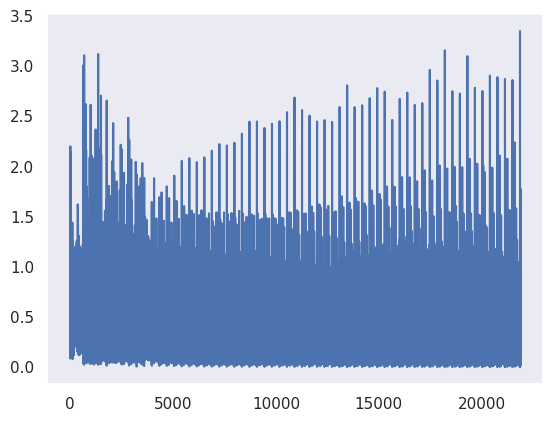

In [40]:
plt.plot(train_losses)

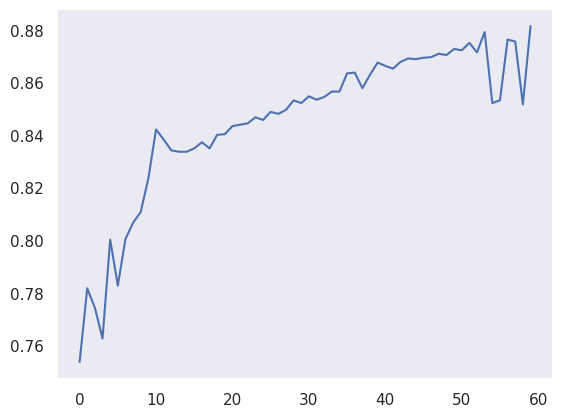

In [41]:
plt.plot(test_accuracy)

In [42]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3428/3872 (0.8853)
{'acc_detail': tensor([0.6943, 0.9468], device='cuda:0'),
 'acc_unweighted': tensor(0.8205, device='cuda:0'),
 'acc_weighted': tensor(0.8853, device='cuda:0'),
 'f1s': tensor(0.8362, device='cuda:0'),
 'f1s_detail': tensor([0.7466, 0.9259], device='cuda:0'),
 'precision_detail': tensor([0.8074, 0.9059], device='cuda:0'),
 'recall_detail': tensor([0.6943, 0.9468], device='cuda:0'),
 'rocauc': tensor([0.9156, 0.9156], device='cuda:0'),
 'uar': tensor(0.8205, device='cuda:0'),
 'wap': tensor(0.8820, device='cuda:0')}


tensor([[ 654,  288],
        [ 156, 2774]], device='cuda:0')

In [47]:
np.save('../physio16k_fold2_m13_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../physio16k_fold2_m13s_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [48]:
EPOCH = 60
PATH = '../physio16k_fold2_m13_60epochs_state.pt' 
LOSS = train_losses[-1]

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [49]:
layer21 = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer21)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [50]:
[print(p.grad) for p in layer21.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-6.2410e-15],
        [-4.6388e-15],
        [-7.7112e-15],
        [ 4.7686e-16],
        [-7.8923e-16],
        [ 5.6706e-17],
        [ 2.3929e-16],
        [ 6.0718e-15],
        [ 2.3038e-14],
        [-6.7254e-17],
        [ 2.7814e-16],
        [ 4.4883e-16],
        [-9.5845e-15],
        [-2.0302e-13],
        [ 1.4944e-17],
        [-7.8822e-17],
        [ 7.2978e-15],
        [ 1.4819e-15],
        [ 1.8473e-16],
        [-1.2178e-15],
        [ 8.7167e-16],
        [ 1.7995e-14],
        [ 1.9391e-16],
        [ 1.1774e-19],
        [-2.0295e-16],
        [-1.0059e-17],
        [-9.6704e-19],
        [ 1.6947e-16],
        [-2.1114e-12],
        [-8.6448e-13],
        [-2.3522e-17],
        [ 0.0000e+00],
        [-1.2342e-15],
        [-8.3885e-17],
        [ 9.5784e-15],
        [ 1.9521e-13],
        [ 5.9067e-16],
        [ 5.2948e-15],
        [ 1.5338e-15],
        [-5.0702e-17],
        [ 2.3001e-16],
        [ 8.9686e-17],
        [ 6

[None, None, None]

(array([11.,  7.,  5.,  6.,  4.,  7.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         1.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  3.,  2.,
         1.,  4.,  0.,  4.,  0.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,
         3.]),
 array([0.        , 0.01191887, 0.02383774, 0.03575661, 0.04767548,
        0.05959435, 0.07151322, 0.08343209, 0.09535096, 0.10726982,
        0.1191887 , 0.13110757, 0.14302644, 0.1549453 , 0.16686417,
        0.17878304, 0.19070192, 0.20262079, 0.21453965, 0.22645852,
        0.23837739, 0.25029626, 0.26221514, 0.27413401, 0.28605288,
        0.29797173, 0.3098906 , 0.32180947, 0.33372834, 0.34564722,
        0.35756609, 0.36948496, 0.38140383, 0.39332271, 0.40524158,
        0.41716045, 0.42907929, 0.44099817, 0.45291704, 0.46483591,
        0.47675478]),
 <BarContainer object of 40 artists>)

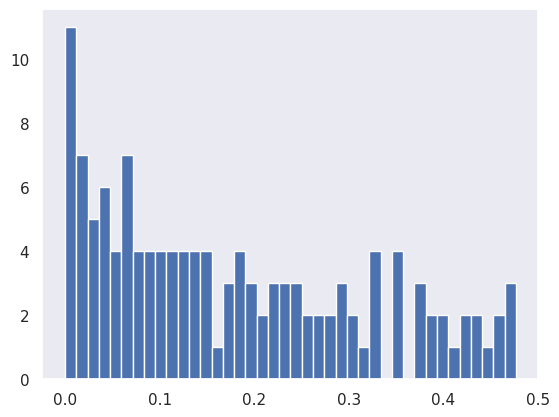

In [51]:
named_params21 = [p for p in layer21.named_parameters()]
lowbands21 = named_params21[0][1].detach().cpu().numpy()
plt.hist(lowbands21.flatten(), bins=40)

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   5., 113.,   3.,   1.,   1.]),
 array([-2.11136902e-12, -2.05370443e-12, -1.99603984e-12, -1.93837524e-12,
        -1.88071065e-12, -1.82304627e-12, -1.76538157e-12, -1.70771708e-12,
        -1.65005249e-12, -1.59238790e-12, -1.53472330e-12, -1.47705871e-12,
        -1.41939422e-12, -1.36172963e-12, -1.30406504e-12, -1.24640044e-12,
        -1.18873596e-12, -1.13107137e-12, -1.07340677e-12, -1.01574218e-12,
        -9.58077584e-13, -9.00413045e-13, -8.42748506e-13, -7.85083912e-13,
        -7.27419373e-13, -6.69754779e-13, -6.12090240e-13, -5.54425646e-13,
        -4.96761052e-13, -4.39096513e-13, -3.81431947e-13, -3.23767380e-13,
        -2.66102787e-13, -2.08438234e-13, -1.50773654e-13, -9.31090871e-14,
        -3.54445206e-14,  2.22200510e-14, 

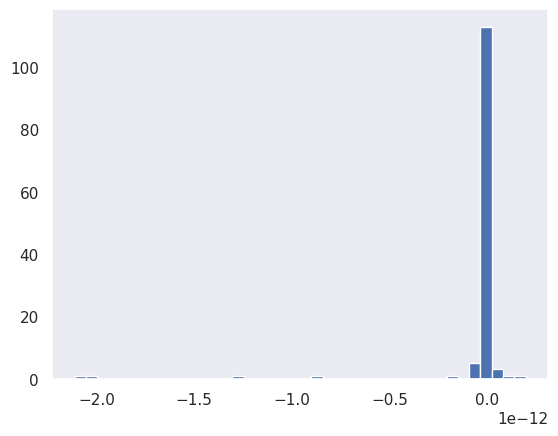

In [52]:
lowbands21 = named_params21[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands21.flatten(), bins=40)

In [57]:
lowbands21.flatten() > float('-inf')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]

/tmp/ipykernel_2908535/1944103232.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands21.flatten())
/tmp/ipykernel_2908535/1944103232.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands21.flatten())


(array([1., 1., 1., 1., 0., 0., 1., 0., 1., 2., 0., 1., 0., 0., 0., 1., 2.,
        3., 0., 0., 2., 1., 4., 5., 6., 6., 4., 3., 4., 0., 3., 2., 4., 2.,
        4., 1., 1., 0., 1., 1.]),
 array([-46.41947174, -45.99060059, -45.56173325, -45.13286209,
        -44.70399094, -44.2751236 , -43.84625244, -43.4173851 ,
        -42.98851395, -42.55964279, -42.13077545, -41.7019043 ,
        -41.27303314, -40.8441658 , -40.41529465, -39.98642349,
        -39.55755615, -39.128685  , -38.69981766, -38.2709465 ,
        -37.84207535, -37.41320801, -36.98433685, -36.5554657 ,
        -36.12659836, -35.6977272 , -35.26885605, -34.83998871,
        -34.41111755, -33.98225021, -33.55337906, -33.1245079 ,
        -32.69564056, -32.26676941, -31.83790016, -31.40902901,
        -30.98015976, -30.55129051, -30.12242126, -29.69355011,
        -29.26468086]),
 <BarContainer object of 40 artists>)

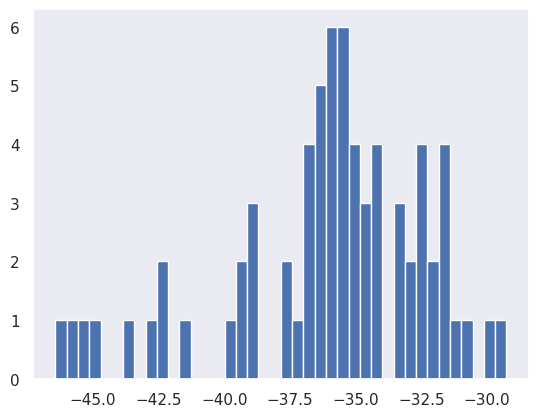

In [59]:
grad_log = np.log(lowbands21.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([3., 4., 4., 5., 6., 6., 7., 8., 7., 5., 8., 6., 5., 5., 6., 3., 4.,
        5., 4., 4., 3., 3., 1., 3., 2., 2., 1., 0., 2., 0., 2., 0., 1., 1.,
        0., 0., 1., 0., 0., 1.]),
 array([0.0035846 , 0.00452443, 0.00546425, 0.00640408, 0.0073439 ,
        0.00828373, 0.00922356, 0.01016338, 0.01110321, 0.01204303,
        0.01298286, 0.01392268, 0.01486251, 0.01580233, 0.01674216,
        0.01768199, 0.01862181, 0.01956164, 0.02050146, 0.02144129,
        0.02238112, 0.02332094, 0.02426077, 0.02520059, 0.02614042,
        0.02708025, 0.02802007, 0.0289599 , 0.02989972, 0.03083955,
        0.03177937, 0.0327192 , 0.03365903, 0.03459885, 0.03553868,
        0.0364785 , 0.03741833, 0.03835815, 0.03929798, 0.0402378 ,
        0.04117763]),
 <BarContainer object of 40 artists>)

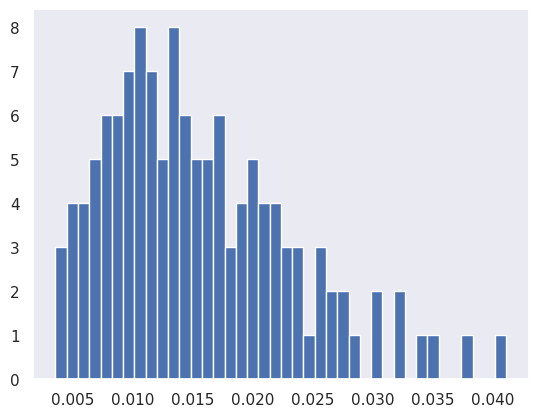

In [60]:
bandwidths21 = named_params21[1][1].detach().cpu().numpy()
plt.hist(bandwidths21.flatten(), bins=40)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2., 123.,   2.]),
 array([-2.04638259e-12, -1.99337769e-12, -1.94037256e-12, -1.88736765e-12,
        -1.83436274e-12, -1.78135772e-12, -1.72835270e-12, -1.67534769e-12,
        -1.62234278e-12, -1.56933776e-12, -1.51633274e-12, -1.46332783e-12,
        -1.41032281e-12, -1.35731780e-12, -1.30431289e-12, -1.25130787e-12,
        -1.19830296e-12, -1.14529794e-12, -1.09229292e-12, -1.03928801e-12,
        -9.86282995e-13, -9.33277977e-13, -8.80273014e-13, -8.27268050e-13,
        -7.74263032e-13, -7.21258068e-13, -6.68253105e-13, -6.15248141e-13,
        -5.62243123e-13, -5.09238159e-13, -4.56233196e-13, -4.03228205e-13,
        -3.50223214e-13, -2.97218223e-13, -2.44213260e-13, -1.91208269e-13,
        -1.38203292e-13, -8.51983143e-14, 

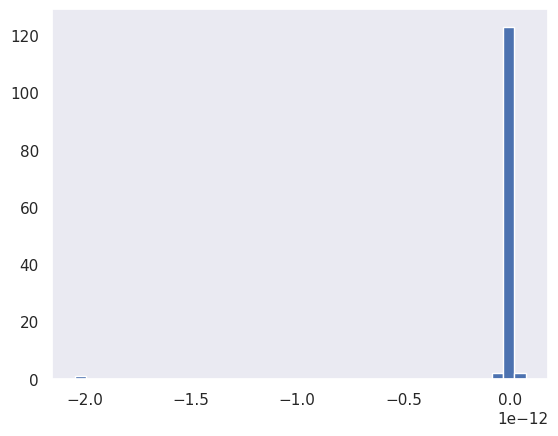

In [61]:
bandwidths21 = named_params21[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths21.flatten(), bins=40)

/tmp/ipykernel_2908535/1282254287.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths21.flatten()), bins=40)


(array([1., 0., 0., 0., 0., 1., 0., 3., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 2., 4., 4., 4., 7., 5., 8., 2., 4., 5., 1., 1., 2., 0.,
        1., 2., 0., 0., 0., 2.]),
 array([-48.56087112, -48.10277939, -47.64468765, -47.18659592,
        -46.72850418, -46.27041245, -45.81232071, -45.35422897,
        -44.89613342, -44.43804169, -43.97994995, -43.52185822,
        -43.06376648, -42.60567474, -42.14758301, -41.68949127,
        -41.23139954, -40.7733078 , -40.31521606, -39.85712433,
        -39.39903259, -38.94094086, -38.48284912, -38.02475739,
        -37.56666565, -37.1085701 , -36.65047836, -36.19238663,
        -35.73429489, -35.27620316, -34.81811142, -34.36001968,
        -33.90192795, -33.44383621, -32.98574448, -32.52765274,
        -32.069561  , -31.61146736, -31.15337563, -30.69528389,
        -30.23719215]),
 <BarContainer object of 40 artists>)

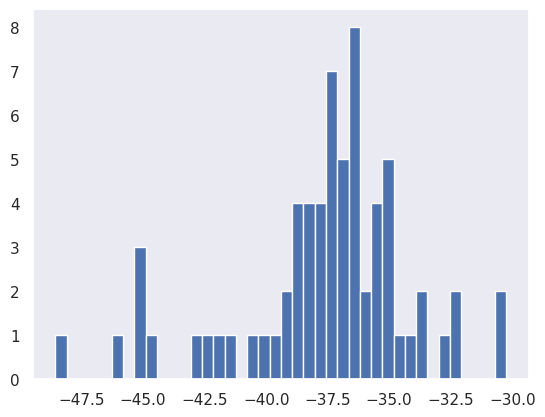

In [62]:
plt.hist(np.log(bandwidths21.flatten()), bins=40)

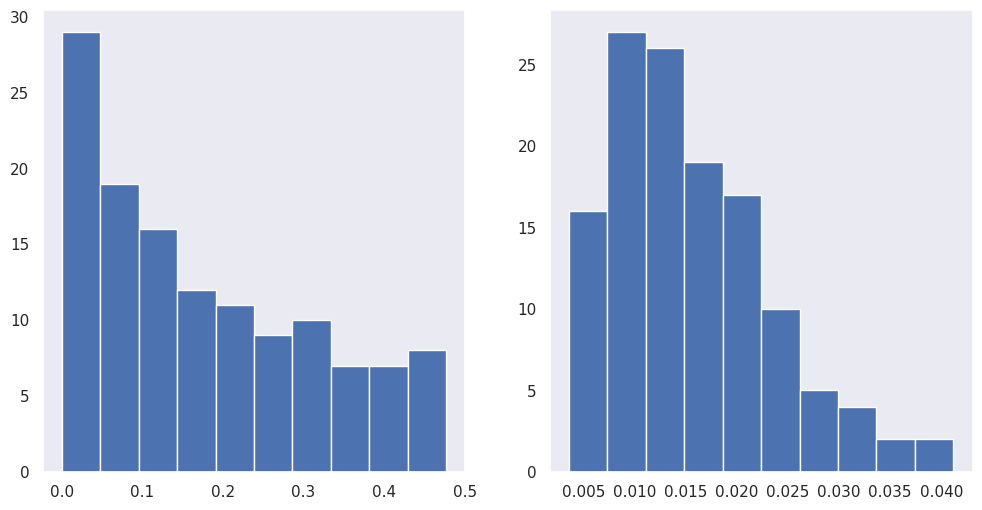

In [63]:
filtviz21 = visualize_model.FilterVisualizer(
    lowcut_bands = layer21.lowcut_bands, 
    bandwidths = layer21.bandwidths,
    window_params = layer21.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz21.visualize_bands()

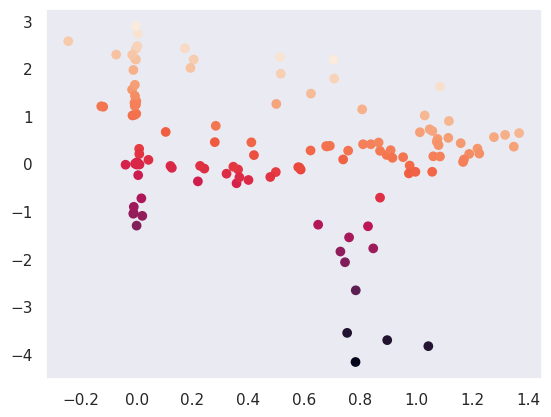

In [66]:
filtviz21.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


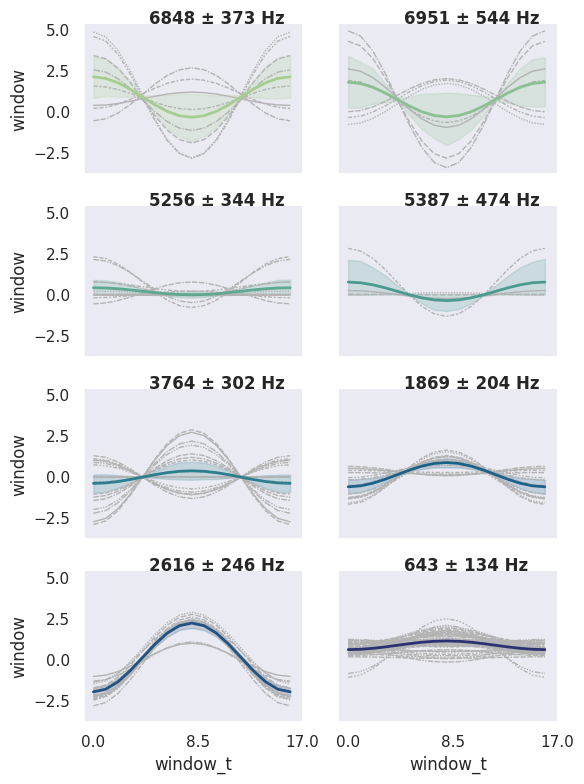

In [67]:
filtviz21.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


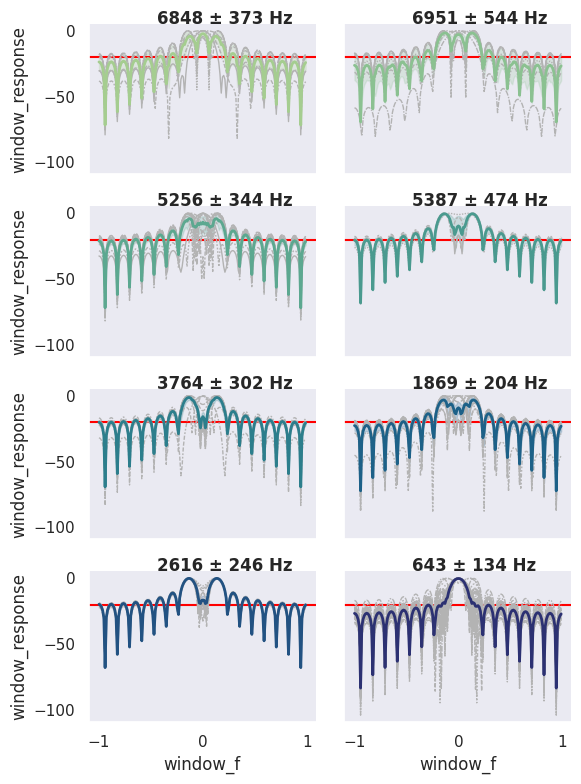

In [68]:
filtviz21.visualize_filters('freq')

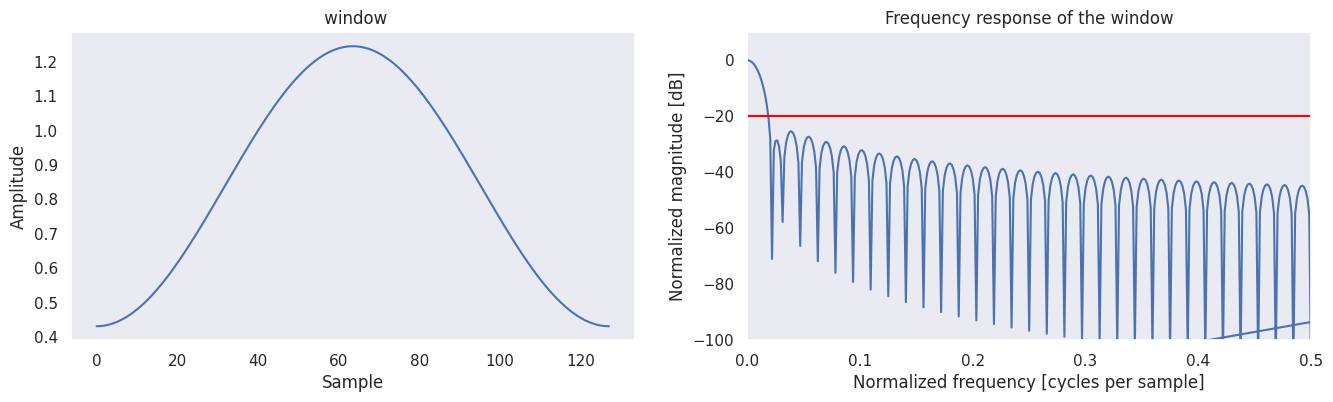

In [69]:
filtviz21.visualize_one_window()

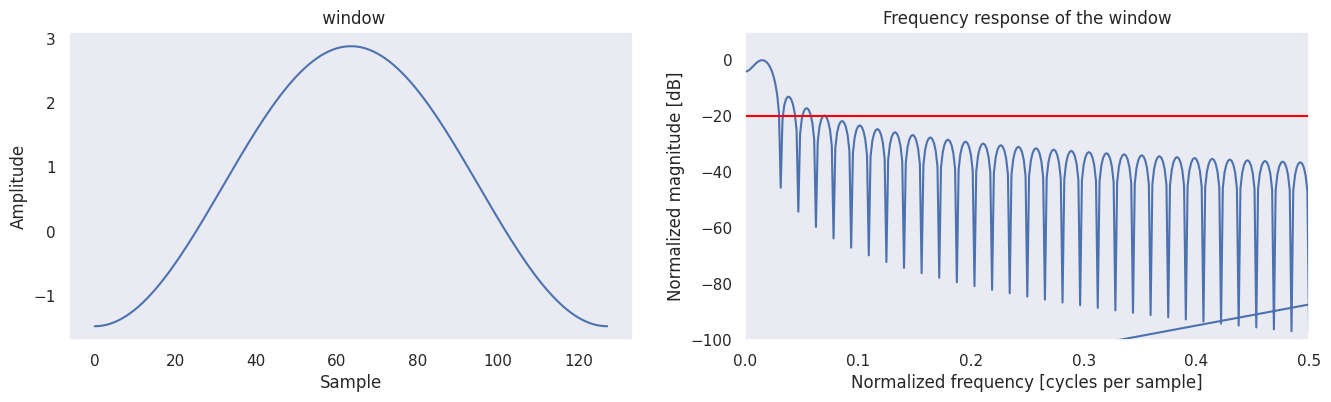

In [71]:
filtviz21.visualize_one_window(n_out=20)

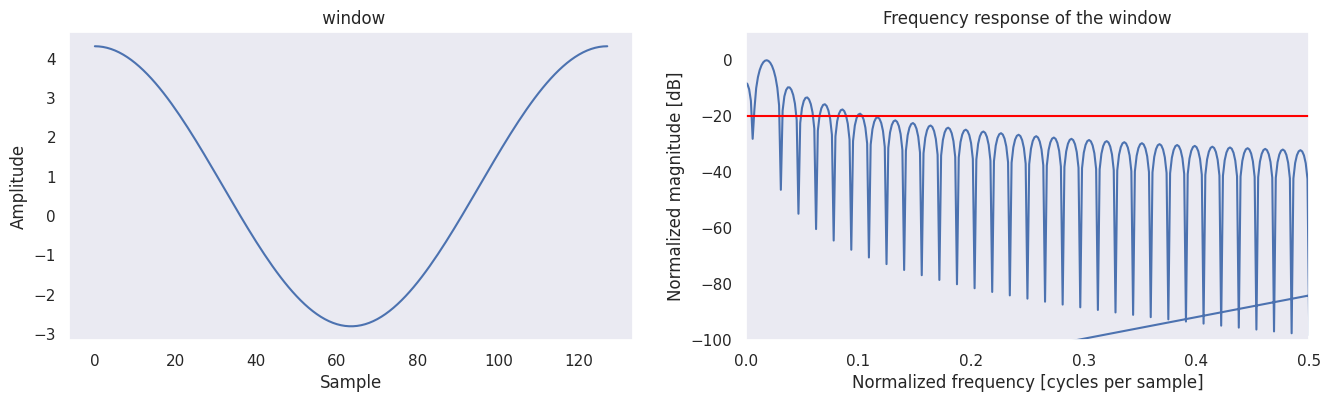

In [72]:
filtviz21.visualize_one_window(n_out=30)

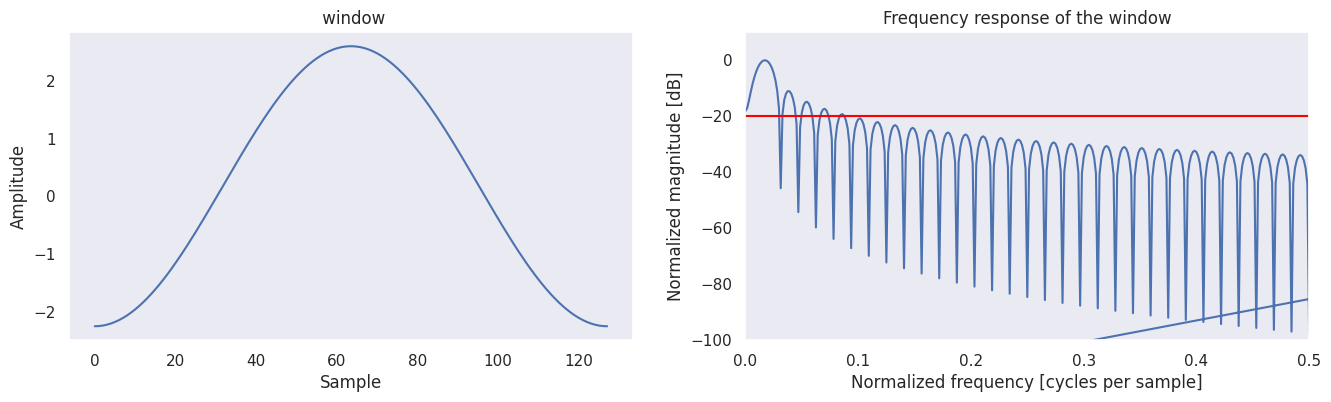

In [73]:
filtviz21.visualize_one_window(n_out=50)

In [74]:
layer22 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer22)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0384, 0.0384, 0.0384,  ..., 0.0384, 0.0384, 0.0384],
        ...,
        [0.2594, 0.2594, 0.2594,  ..., 0.2594, 0.2594, 0.2594],
        [0.3309, 0.3309, 0.3309,  ..., 0.3309, 0.3309, 0.3309],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        [0.0222, 0.0222, 0.0222,  ..., 0.0222, 0.0222, 0.0222],
        [0.0304, 0.0304, 0.0304,  ..., 0.0304, 0.0304, 0.0304],
        ...,
        [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
        [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
        [0.0892, 0.0892, 0.0892,  ..., 0.0892, 0.0892, 0.0892]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

(array([512., 128., 128., 384.,   0., 128., 256.,   0., 256.,   0., 128.,
        128.,   0., 256.,   0.,   0., 256.,   0.,   0., 256.,   0.,   0.,
        128., 128.,   0., 128.,   0., 128.,   0., 128.,   0.,   0., 128.,
          0., 128.,   0., 128.,   0., 128., 128.]),
 array([0.        , 0.0102691 , 0.02053821, 0.03080731, 0.04107642,
        0.05134552, 0.06161463, 0.07188373, 0.08215284, 0.09242194,
        0.10269105, 0.11296015, 0.12322926, 0.13349836, 0.14376746,
        0.15403657, 0.16430567, 0.17457478, 0.18484388, 0.19511299,
        0.20538209, 0.2156512 , 0.2259203 , 0.23618941, 0.24645852,
        0.25672761, 0.26699671, 0.27726582, 0.28753492, 0.29780403,
        0.30807313, 0.31834224, 0.32861134, 0.33888045, 0.34914955,
        0.35941866, 0.36968777, 0.37995687, 0.39022598, 0.40049508,
        0.41076419]),
 <BarContainer object of 40 artists>)

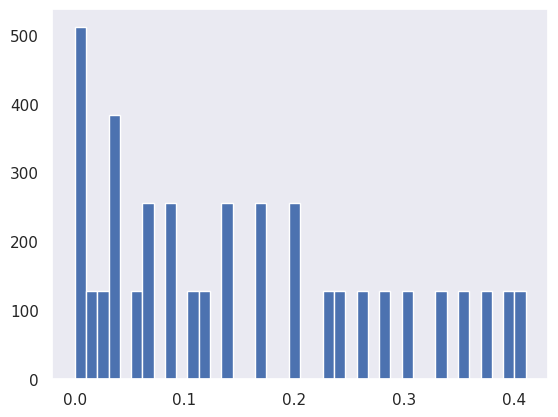

In [75]:
named_params22 = [p for p in layer22.named_parameters()]
lowbands22 = named_params22[0][1].detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

(array([3.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 1.000e+01, 7.000e+00,
        8.000e+00, 1.200e+01, 1.300e+01, 1.400e+01, 3.500e+01, 1.660e+02,
        3.558e+03, 1.180e+02, 2.600e+01, 2.000e+01, 1.700e+01, 1.600e+01,
        1.500e+01, 5.000e+00, 1.200e+01, 5.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([-2.11241038e-15, -1.94169788e-15, -1.77098527e-15, -1.60027277e-15,
        -1.42956027e-15, -1.25884766e-15, -1.08813516e-15, -9.17422656e-16,
        -7.46710100e-16, -5.75997598e-16, -4.05285042e-16, -2.34572513e-16,
        -6.38599712e-17,  1.06852558e-16,  2.77565100e-16,  4.48277629e-16,
         6.18990184e-16,  7.89702687e-16,  9.60415189e-16,  1.13112780e-15,
         1.30184030e-15,  1.47255280e-15,  1.64326541e-15,  1.81397781e-15,
         1.98469052e-15,  2.15540302e-15,  2.3

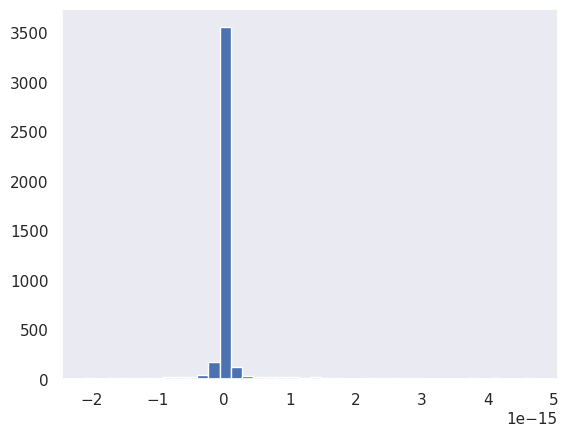

In [76]:
lowbands22 = named_params22[0][1].grad.detach().cpu().numpy()
plt.hist(lowbands22.flatten(), bins=40)

/tmp/ipykernel_2908535/1558741381.py:1: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands22.flatten())
/tmp/ipykernel_2908535/1558741381.py:1: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands22.flatten())


(array([  1.,   0.,   2.,   1.,   2.,   5.,   3.,   7.,  11.,  16.,  20.,
         23.,  19.,  30.,  38.,  46.,  49.,  90., 123.,  84.,  81.,  91.,
         80., 112., 117.,  90.,  63.,  45.,  67.,  78., 117., 100.,  80.,
         56.,  38.,  29.,  39.,  32.,  15.,  11.]),
 array([-53.09054947, -52.58798218, -52.08541107, -51.58284378,
        -51.08027267, -50.57770538, -50.07513809, -49.57256699,
        -49.06999969, -48.56742859, -48.0648613 , -47.56229401,
        -47.0597229 , -46.55715561, -46.0545845 , -45.55201721,
        -45.04944992, -44.54687881, -44.04431152, -43.54174042,
        -43.03917313, -42.53660583, -42.03403473, -41.53146744,
        -41.02889633, -40.52632904, -40.02376175, -39.52119064,
        -39.01862335, -38.51605225, -38.01348495, -37.51091766,
        -37.00834656, -36.50577927, -36.00320816, -35.50064087,
        -34.99807358, -34.49550247, -33.99293518, -33.49036407,
        -32.98779678]),
 <BarContainer object of 40 artists>)

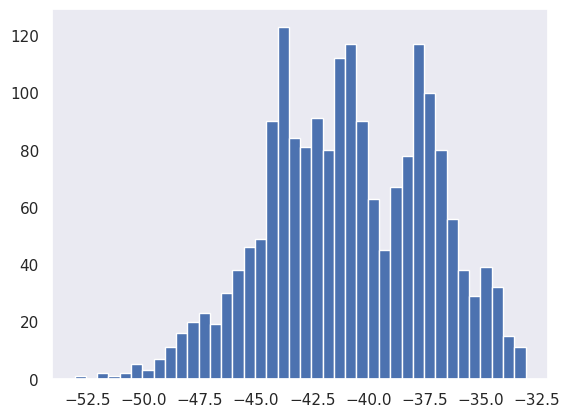

In [78]:
grad_log = np.log(lowbands22.flatten())
grad_log = grad_log[grad_log > float('-inf')]
plt.hist(grad_log, bins=40)

(array([128., 128., 128.,   0., 384.,   0., 256., 256., 128., 256., 128.,
        128., 256., 128., 256.,   0., 128., 128., 256., 128.,   0.,   0.,
        256.,   0.,   0., 128.,   0., 256.,   0.,   0.,   0.,   0.,   0.,
        128.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0.01619883, 0.01946704, 0.02273525, 0.02600346, 0.02927167,
        0.03253987, 0.03580808, 0.03907629, 0.0423445 , 0.04561271,
        0.04888092, 0.05214913, 0.05541734, 0.05868555, 0.06195376,
        0.06522197, 0.06849018, 0.07175838, 0.07502659, 0.0782948 ,
        0.08156301, 0.08483122, 0.08809943, 0.09136764, 0.09463584,
        0.09790406, 0.10117227, 0.10444047, 0.10770869, 0.11097689,
        0.1142451 , 0.11751331, 0.12078152, 0.12404973, 0.12731794,
        0.13058615, 0.13385436, 0.13712257, 0.14039077, 0.14365898,
        0.14692719]),
 <BarContainer object of 40 artists>)

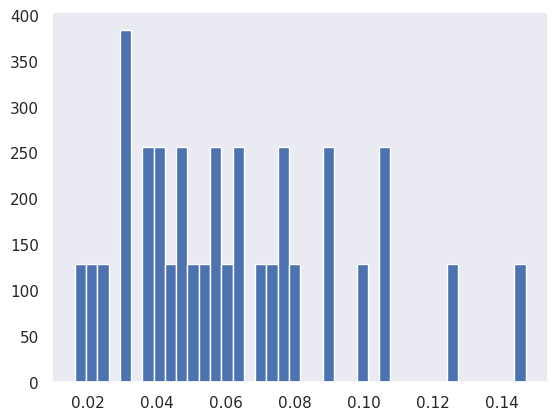

In [80]:
bandwidths22 = named_params22[1][1].detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        6.000e+00, 3.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        3.889e+03, 9.500e+01, 3.000e+01, 2.000e+00]),
 array([-3.09323253e-14, -3.00949586e-14, -2.92575920e-14, -2.84202254e-14,
        -2.75828588e-14, -2.67454922e-14, -2.59081273e-14, -2.50707607e-14,
        -2.42333941e-14, -2.33960275e-14, -2.25586609e-14, -2.17212943e-14,
        -2.08839277e-14, -2.00465611e-14, -1.92091944e-14, -1.83718278e-14,
        -1.75344612e-14, -1.66970946e-14, -1.58597297e-14, -1.50223631e-14,
        -1.41849956e-14, -1.33476299e-14, -1.25102633e-14, -1.16728967e-14,
        -1.08355301e-14, -9.99816346e-15, -9.1

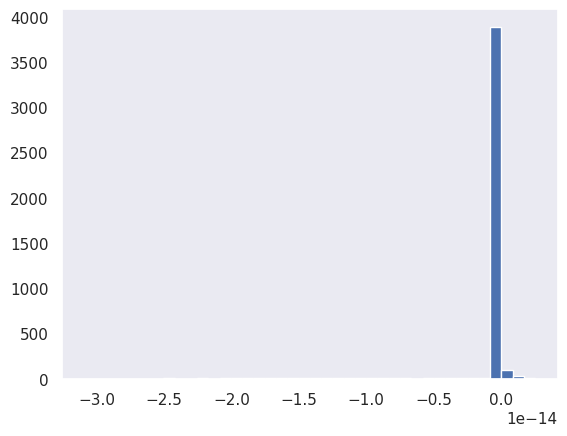

In [82]:
bandwidths22 = named_params22[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths22.flatten(), bins=40)

/tmp/ipykernel_2908535/636885685.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(bandwidths22.flatten()), bins=40)


(array([  1.,   1.,   0.,   1.,   5.,   2.,   3.,   5.,  12.,  10.,  19.,
         15.,  21.,  27.,  33.,  45.,  49.,  45.,  76.,  91., 108., 134.,
        111., 105., 120., 118.,  95.,  54.,  60.,  54.,  51.,  60.,  73.,
         35.,  22.,  10.,  20.,  20.,  33.,   6.]),
 array([-57.23532486, -56.64438629, -56.05345154, -55.46251678,
        -54.87157822, -54.28063965, -53.6897049 , -53.09877014,
        -52.50783157, -51.91689301, -51.32595825, -50.7350235 ,
        -50.14408493, -49.55314636, -48.96221161, -48.37127686,
        -47.78033829, -47.18939972, -46.59846497, -46.00753021,
        -45.41659164, -44.82565308, -44.23471832, -43.64378357,
        -43.052845  , -42.46190643, -41.87097168, -41.28003693,
        -40.68909836, -40.09815979, -39.50722504, -38.91629028,
        -38.32535172, -37.73441315, -37.14347839, -36.55254364,
        -35.96160507, -35.3706665 , -34.77973175, -34.188797  ,
        -33.59785843]),
 <BarContainer object of 40 artists>)

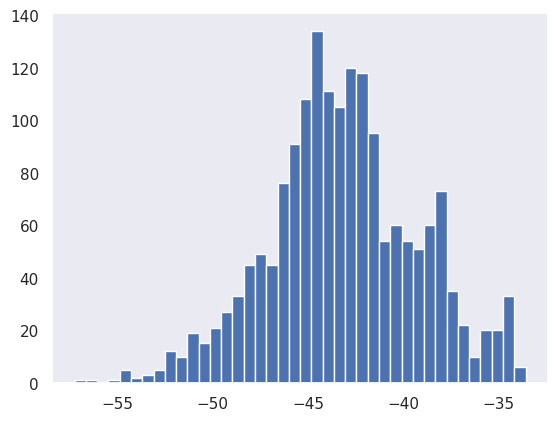

In [83]:
plt.hist(np.log(bandwidths22.flatten()), bins=40)

downsample_factor: 8 => new_sample_rate: 2000


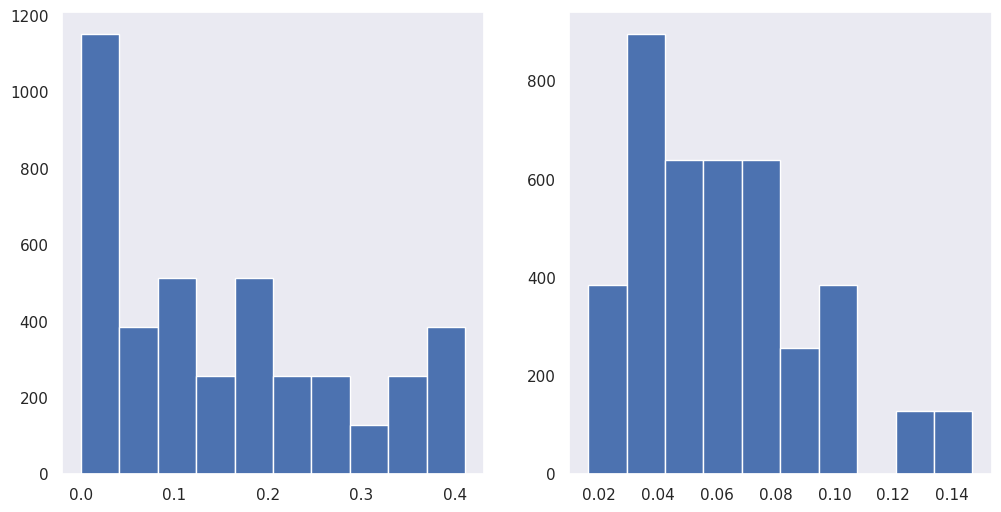

In [84]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz22 = visualize_model.FilterVisualizer(
    lowcut_bands = layer22.lowcut_bands, 
    bandwidths = layer22.bandwidths,
    window_params = layer22.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz22.visualize_bands()

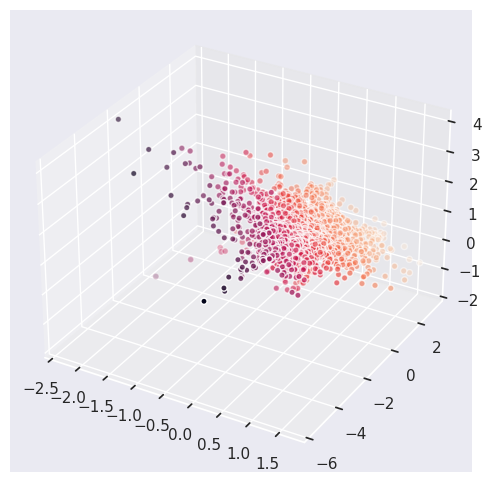

In [85]:
filtviz22.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


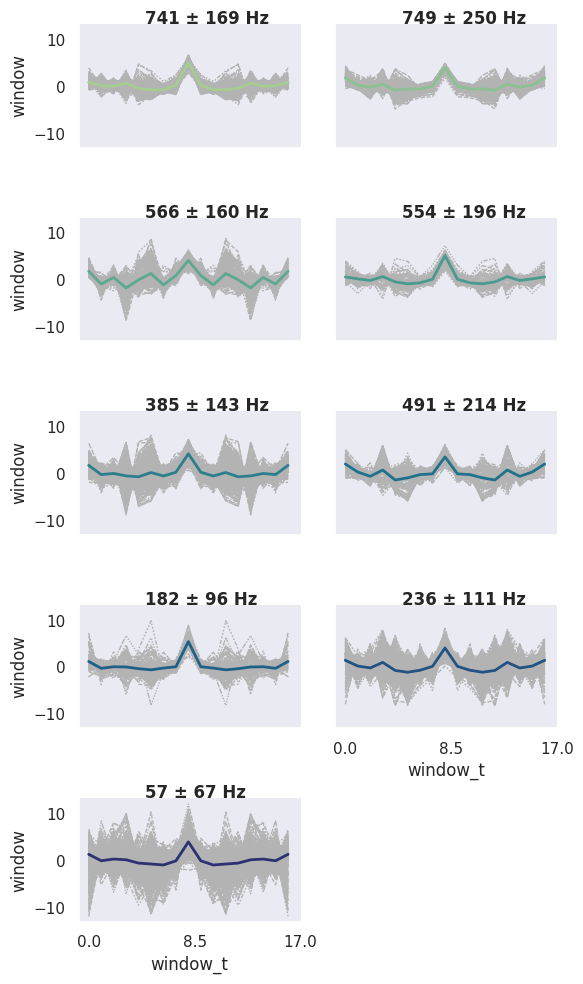

In [86]:
filtviz22.visualize_filters('time')

Frequency domain: Filters' shapes vary by frequency bins


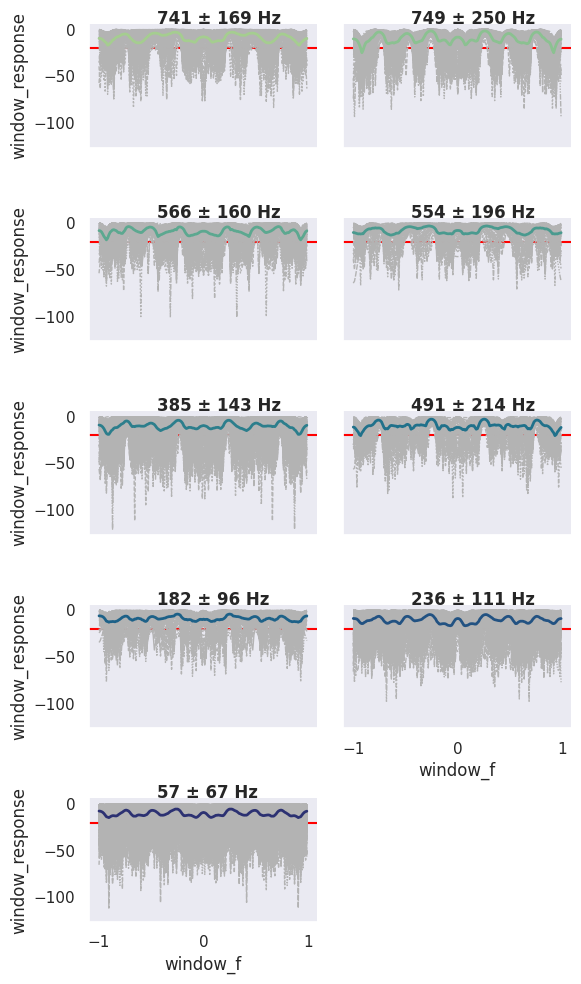

In [87]:
filtviz22.visualize_filters('freq')

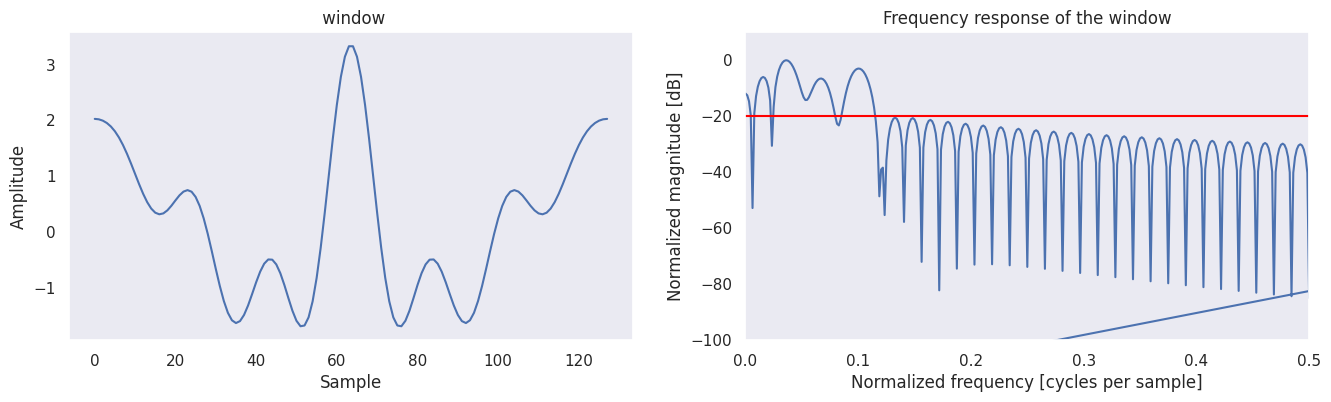

In [89]:
filtviz22.visualize_one_window(n_inp=0, n_out=0)

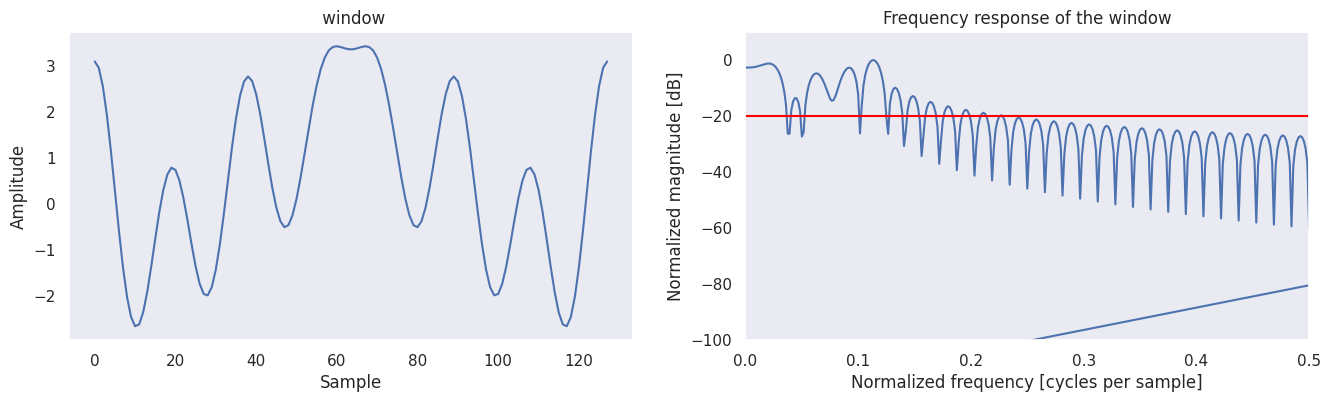

In [90]:
filtviz22.visualize_one_window(n_inp=0, n_out=10)

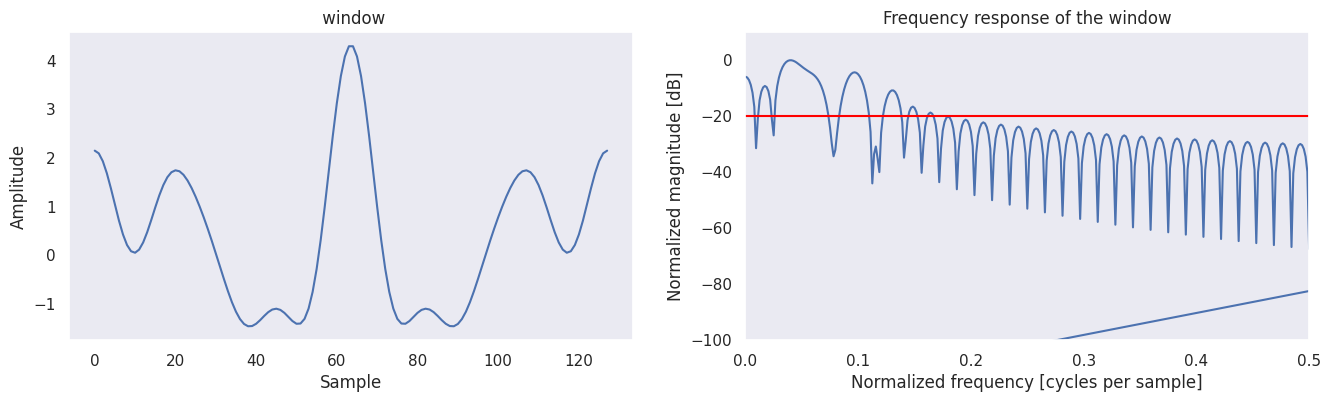

In [91]:
filtviz22.visualize_one_window(n_inp=10, n_out=10)

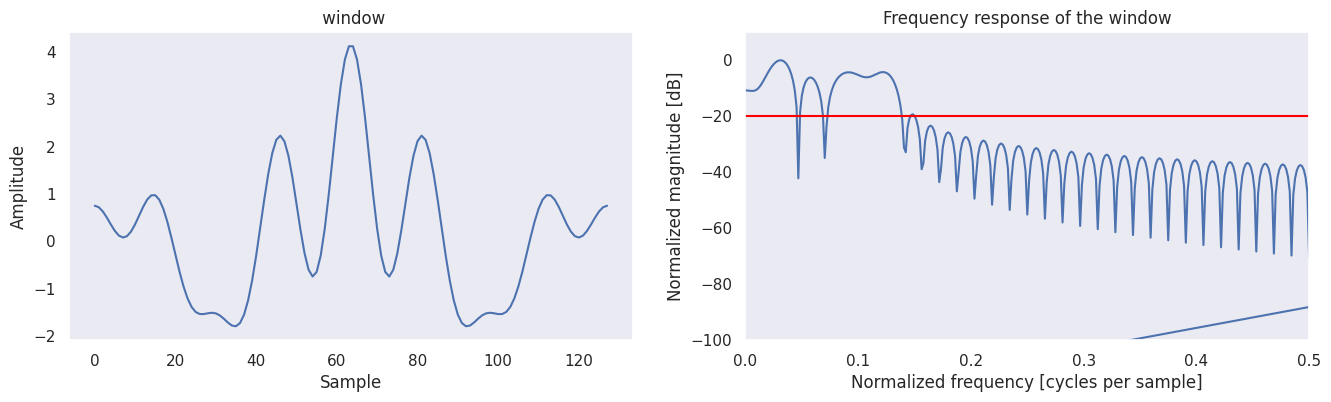

In [92]:
filtviz22.visualize_one_window(n_inp=60, n_out=10)